In [1]:
# !pip install pyarrow
# !pip install hdfs

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import psycopg2
from psycopg2 import connect
from dotenv import load_dotenv
from hdfs import InsecureClient
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# Load the Dataset from HDFS

In [3]:
client = InsecureClient('http://localhost:9870', user='jihadakbr')

In [4]:
with client.read('/user/jihadakbr/credit_risk/raw/application_train.csv', encoding='utf-8') as reader:
    train = pd.read_csv(reader)

In [5]:
with client.read('/user/jihadakbr/credit_risk/raw/application_test.csv', encoding='utf-8') as reader:
    test = pd.read_csv(reader)

In [6]:
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [7]:
test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [8]:
pd.set_option('display.max_info_columns', 200)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    SK_ID_CURR                    48744 non-null  int64  
 1    NAME_CONTRACT_TYPE            48744 non-null  object 
 2    CODE_GENDER                   48744 non-null  object 
 3    FLAG_OWN_CAR                  48744 non-null  object 
 4    FLAG_OWN_REALTY               48744 non-null  object 
 5    CNT_CHILDREN                  48744 non-null  int64  
 6    AMT_INCOME_TOTAL              48744 non-null  float64
 7    AMT_CREDIT                    48744 non-null  float64
 8    AMT_ANNUITY                   48720 non-null  float64
 9    AMT_GOODS_PRICE               48744 non-null  float64
 10   NAME_TYPE_SUITE               47833 non-null  object 
 11   NAME_INCOME_TYPE              48744 non-null  object 
 12   NAME_EDUCATION_TYPE           48744 non-null

# Concatenate Train and Test Sets

In [11]:
# Add an identifier so we know where each row came from
train['is_train'] = True
test['is_train'] = False

In [12]:
# Add a placeholder for the target in test so columns align
test['TARGET'] = None

In [13]:
# Combine the datasets, It will automatically order the column
df = pd.concat([train, test], ignore_index=True)

In [14]:
train.shape, test.shape, df.shape

((307511, 123), (48744, 123), (356255, 123))

In [15]:
df[df['is_train'] == True].head()

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002      1         Cash loans           M            N   
1      100003      0         Cash loans           F            N   
2      100004      0    Revolving loans           M            Y   
3      100006      0         Cash loans           F            N   
4      100007      0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0   
1  ...                 0                0                0   
2  ...                 0                0                0   
3  ...                 0                0                0   
4  ...                 0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  is_train  
0                        0.0                         1.0      True  
1                        0.0                         0.0      True  
2                        0.0                         0.0      True  
3                        NaN                         NaN      True  
4                        0.0                         0.0      True  

[5 rows x 123 columns]

In [16]:
df[df['is_train'] == False].head()

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
307511      100001   None         Cash loans           F            N   
307512      100005   None         Cash loans           M            N   
307513      100013   None         Cash loans           M            Y   
307514      100028   None         Cash loans           F            N   
307515      100038   None         Cash loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
307511               Y             0          135000.0    568800.0   
307512               Y             0           99000.0    222768.0   
307513               Y             0          202500.0    663264.0   
307514               Y             2          315000.0   1575000.0   
307515               N             1          180000.0    625500.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
307511      20560.5  ...                 0                0                0   
307512      17370.0  ...                 0                0                0   
307513      69777.0  ...                 0                0                0   
307514      49018.5  ...                 0                0                0   
307515      32067.0  ...                 0                0                0   

       AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
307511                        0.0                       0.0   
307512                        0.0                       0.0   
307513                        0.0                       0.0   
307514                        0.0                       0.0   
307515                        NaN                       NaN   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
307511                        0.0                        0.0   
307512                        0.0                        0.0   
307513                        0.0                        0.0   
307514                        0.0                        0.0   
307515                        NaN                        NaN   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  is_train  
307511                        0.0                         0.0     False  
307512                        0.0                         3.0     False  
307513                        1.0                         4.0     False  
307514                        0.0                         3.0     False  
307515                        NaN                         NaN     False  

[5 rows x 123 columns]

# Data Preprocessing I

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 123 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    356255 non-null  int64  
 1    TARGET                        307511 non-null  object 
 2    NAME_CONTRACT_TYPE            356255 non-null  object 
 3    CODE_GENDER                   356255 non-null  object 
 4    FLAG_OWN_CAR                  356255 non-null  object 
 5    FLAG_OWN_REALTY               356255 non-null  object 
 6    CNT_CHILDREN                  356255 non-null  int64  
 7    AMT_INCOME_TOTAL              356255 non-null  float64
 8    AMT_CREDIT                    356255 non-null  float64
 9    AMT_ANNUITY                   356219 non-null  float64
 10   AMT_GOODS_PRICE               355977 non-null  float64
 11   NAME_TYPE_SUITE               354052 non-null  object 
 12   NAME_INCOME_TYPE            

## Handling Duplicate Data

In [18]:
# Check duplicate data
df.duplicated().sum().sum()

0

There are no duplicates found.

## Converting Data Type

In [19]:
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype(str)

## Handling Error Data

Pandas DataFrame can automatically convert a numeric column to an object type if it contains even a single non-numeric value. Therefore, if a column retains its numeric type, its data distribution can be directly analyzed using `df.describe()`.

For categorical columns, data errors should be reviewed per column to ensure consistency and accuracy.

In [20]:
pd.set_option('display.max_columns', None)       # Show all columns
pd.set_option('display.float_format', '{:.3f}'.format)  # Disable scientific notation
pd.set_option('display.max_rows', None)

In [21]:
df.describe()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count    356255.000        356255.000  356255.000   356219.000   
mean          0.414        170116.060  587767.414    27425.561   
std           0.720        223506.819  398623.694    14732.808   
min           0.000         25650.000   45000.000     1615.500   
25%           0.000        112500.000  270000.000    16731.000   
50%           0.000        153000.000  500211.000    25078.500   
75%           1.000        202500.000  797557.500    34960.500   
max          20.000     117000000.000 4050000.000   258025.500   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count       355977.000                  356255.000  356255.000     356255.000   
mean        528019.998                       0.021  -16041.249      64317.231   
std         366064.986                       0.014    4358.804     141705.533   
min          40500.000                       0.000  -25229.000     -17912.000   
25%         234000.000                       0.010  -19676.000      -2781.000   
50%         450000.000                       0.019  -15755.000      -1224.000   
75%         675000.000                       0.029  -12425.000       -290.000   
max        4050000.000                       0.073   -7338.000     365243.000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
count         356255.000       356255.000   121014.000  356255.000   
mean           -4983.594        -3002.071       12.024       1.000   
std             3526.969         1517.902       11.881       0.002   
min           -24672.000        -7197.000        0.000       0.000   
25%            -7477.000        -4318.000        5.000       1.000   
50%            -4502.000        -3252.000        9.000       1.000   
75%            -1995.000        -1717.000       15.000       1.000   
max                0.000            0.000       91.000       1.000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      356255.000       356255.000        356255.000  356255.000   
mean            0.818            0.200             0.998       0.279   
std             0.385            0.400             0.043       0.448   
min             0.000            0.000             0.000       0.000   
25%             1.000            0.000             1.000       0.000   
50%             1.000            0.000             1.000       0.000   
75%             1.000            0.000             1.000       1.000   
max             1.000            1.000             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  356255.000       356253.000            356255.000   
mean        0.071            2.152                 2.051   
std         0.257            0.908                 0.511   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           21.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   356255.000               356255.000   
mean                         2.029                   12.056   
std                          0.505                    3.268   
min                         -1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  356255.000                  356255.000   
mean                        0.016                       0.051   
std                         0.124                       0.221   
min                         0.000

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 123 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    356255 non-null  object 
 1    TARGET                        307511 non-null  object 
 2    NAME_CONTRACT_TYPE            356255 non-null  object 
 3    CODE_GENDER                   356255 non-null  object 
 4    FLAG_OWN_CAR                  356255 non-null  object 
 5    FLAG_OWN_REALTY               356255 non-null  object 
 6    CNT_CHILDREN                  356255 non-null  int64  
 7    AMT_INCOME_TOTAL              356255 non-null  float64
 8    AMT_CREDIT                    356255 non-null  float64
 9    AMT_ANNUITY                   356219 non-null  float64
 10   AMT_GOODS_PRICE               355977 non-null  float64
 11   NAME_TYPE_SUITE               354052 non-null  object 
 12   NAME_INCOME_TYPE            

In [23]:
df["TARGET"].value_counts().sort_index()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [24]:
pd.reset_option('display.max_rows')

In [25]:
df["NAME_CONTRACT_TYPE"].value_counts().sort_index()

NAME_CONTRACT_TYPE
Cash loans         326537
Revolving loans     29718
Name: count, dtype: int64

In [26]:
df["CODE_GENDER"].value_counts().sort_index()

CODE_GENDER
F      235126
M      121125
XNA         4
Name: count, dtype: int64

In [27]:
df["NAME_TYPE_SUITE"].value_counts().sort_index()

NAME_TYPE_SUITE
Children             3675
Family              46030
Group of people       320
Other_A               975
Other_B              1981
Spouse, partner     12818
Unaccompanied      288253
Name: count, dtype: int64

In [28]:
df["NAME_INCOME_TYPE"].value_counts().sort_index()

NAME_INCOME_TYPE
Businessman                 11
Commercial associate     83019
Maternity leave              5
Pensioner                64635
State servant            25235
Student                     20
Unemployed                  23
Working                 183307
Name: count, dtype: int64

In [29]:
df["NAME_EDUCATION_TYPE"].value_counts().sort_index()

NAME_EDUCATION_TYPE
Academic degree                     205
Higher education                  87379
Incomplete higher                 12001
Lower secondary                    4291
Secondary / secondary special    252379
Name: count, dtype: int64

In [30]:
df["NAME_FAMILY_STATUS"].value_counts().sort_index()

NAME_FAMILY_STATUS
Civil marriage           34036
Married                 228715
Separated                22725
Single / not married     52480
Unknown                      2
Widow                    18297
Name: count, dtype: int64

In [31]:
df["NAME_HOUSING_TYPE"].value_counts().sort_index()

NAME_HOUSING_TYPE
Co-op apartment          1245
House / apartment      316513
Municipal apartment     12800
Office apartment         3024
Rented apartment         5599
With parents            17074
Name: count, dtype: int64

In [32]:
df["OCCUPATION_TYPE"].value_counts().sort_index()

OCCUPATION_TYPE
Accountants              11441
Cleaning staff            5309
Cooking staff             6840
Core staff               31931
Drivers                  21376
HR staff                   667
High skill tech staff    13234
IT staff                   607
Laborers                 63841
Low-skill Laborers        2365
Managers                 24945
Medicine staff            9853
Private service staff     3107
Realty agents              889
Sales staff              37174
Secretaries               1518
Security staff            7636
Waiters/barmen staff      1526
Name: count, dtype: int64

In [33]:
df["WEEKDAY_APPR_PROCESS_START"].value_counts().sort_index()

WEEKDAY_APPR_PROCESS_START
FRIDAY       57588
MONDAY       59120
SATURDAY     38455
SUNDAY       18040
THURSDAY     59009
TUESDAY      63652
WEDNESDAY    60391
Name: count, dtype: int64

In [34]:
df["ORGANIZATION_TYPE"].value_counts().sort_index()

ORGANIZATION_TYPE
Advertising                 500
Agriculture                2746
Bank                       2881
Business Entity Type 1     6871
Business Entity Type 2    12032
Business Entity Type 3    78832
Cleaning                    303
Construction               7760
Culture                     440
Electricity                1106
Emergency                   651
Government                11912
Hotel                      1100
Housing                    3393
Industry: type 1           1217
Industry: type 10           133
Industry: type 11          3120
Industry: type 12           446
Industry: type 13            73
Industry: type 2            535
Industry: type 3           3767
Industry: type 4           1044
Industry: type 5            696
Industry: type 6            139
Industry: type 7           1524
Industry: type 8             27
Industry: type 9           3867
Insurance                   677
Kindergarten               7918
Legal Services              358
Medicine              

In [35]:
df["FONDKAPREMONT_MODE"].value_counts().sort_index()

FONDKAPREMONT_MODE
not specified             6600
org spec account          6539
reg oper account         85954
reg oper spec account    14070
Name: count, dtype: int64

In [36]:
df["HOUSETYPE_MODE"].value_counts().sort_index()

HOUSETYPE_MODE
block of flats      175162
specific housing      1761
terraced house        1416
Name: count, dtype: int64

In [37]:
df["WALLSMATERIAL_MODE"].value_counts().sort_index()

WALLSMATERIAL_MODE
Block           10681
Mixed            2649
Monolithic       2068
Others           1909
Panel           77309
Stone, brick    75249
Wooden           6156
Name: count, dtype: int64

In [38]:
df["EMERGENCYSTATE_MODE"].value_counts().sort_index()

EMERGENCYSTATE_MODE
No     185607
Yes      2684
Name: count, dtype: int64

# Splitting the Dataset

In [39]:
# Recover the train and test sets
train = df[df['is_train']].copy().reset_index(drop=True)
test = df[~df['is_train']].copy().reset_index(drop=True)

In [40]:
# Drop helper columns
train = train.drop(columns=['is_train'])
test = test.drop(columns=['is_train', 'TARGET'])

In [41]:
train.head()

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0     100002      1         Cash loans           M            N   
1     100003      0         Cash loans           F            N   
2     100004      0    Revolving loans           M            Y   
3     100006      0         Cash loans           F            N   
4     100007      0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0       351000.000   Unaccompanied          Working   
1      1129500.000          Family    State servant   
2       135000.000   Unaccompanied          Working   
3       297000.000   Unaccompanied          Working   
4       513000.000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461           -637          -3648.000   
1                       0.004      -16765          -1188          -1186.000   
2                       0.010      -19046           -225          -4260.000   
3                       0.008      -19005          -3039          -9833.000   
4                       0.029      -19932          -3038          -4311.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531       26.000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers            1.000   
1                 1           1           0      Core staff            2.000   
2                 1           1           0        Laborers            1.000   
3                 1           0           0        Laborers            2.000   
4                 1           0           0      Core staff            1.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0       

In [42]:
test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0     100001         Cash loans           F            N               Y   
1     100005         Cash loans           M            N               Y   
2     100013         Cash loans           M            Y               Y   
3     100028         Cash loans           F            N               Y   
4     100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        135000.000  568800.000    20560.500       450000.000   
1             0         99000.000  222768.000    17370.000       180000.000   
2             0        202500.000  663264.000    69777.000       630000.000   
3             2        315000.000 1575000.000    49018.500      1575000.000   
4             1        180000.000  625500.000    32067.000       625500.000   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                       0.019   
1            Married  House / apartment                       0.036   
2            Married  House / apartment                       0.019   
3            Married  House / apartment                       0.026   
4            Married  House / apartment                       0.010   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329          -5170.000             -812          NaN   
1      -18064          -4469          -9118.000            -1623          NaN   
2      -20038          -4458          -2175.000            -3503        5.000   
3      -13976          -1866          -2000.000            -4208          NaN   
4      -13040          -2191          -4000.000            -4262       16.000   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN            2.000                     2   
1           0  Low-skill Laborers            2.000                     2   
2           0             Drivers            2.000                     2   
3           0         Sales staff            4.000                     2   
4           0                 NaN            3.000                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                        

In [43]:
train.shape, test.shape, df.shape

((307511, 122), (48744, 121), (356255, 123))

**TARGET column value percentages**

In [44]:
df["TARGET"].value_counts(normalize=True).sort_index() * 100

TARGET
0   91.927
1    8.073
Name: proportion, dtype: float64

In [45]:
train["TARGET"].value_counts(normalize=True).sort_index() * 100

TARGET
0   91.927
1    8.073
Name: proportion, dtype: float64

# Data Preprocessing II

## Handling Missing Values

In [46]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Calculate missing values and their percentages
    missing = train.isna().sum()
    missing_percent = (missing / len(train)) * 100
    
    # Filter for columns with missing values and print
    missing_data = pd.DataFrame({
        'Missing Count': missing[missing > 0],
        'Missing Percent': missing_percent[missing > 0]
    })
    print(missing_data)

                              Missing Count  Missing Percent
AMT_ANNUITY                              12            0.004
AMT_GOODS_PRICE                         278            0.090
NAME_TYPE_SUITE                        1292            0.420
OWN_CAR_AGE                          202929           65.991
OCCUPATION_TYPE                       96391           31.346
CNT_FAM_MEMBERS                           2            0.001
EXT_SOURCE_1                         173378           56.381
EXT_SOURCE_2                            660            0.215
EXT_SOURCE_3                          60965           19.825
APARTMENTS_AVG                       156061           50.750
BASEMENTAREA_AVG                     179943           58.516
YEARS_BEGINEXPLUATATION_AVG          150007           48.781
YEARS_BUILD_AVG                      204488           66.498
COMMONAREA_AVG                       214865           69.872
ELEVATORS_AVG                        163891           53.296
ENTRANCES_AVG           

### Rows with >=50% Missing values

In [47]:
# Set threshold
threshold = 0.5

**Train Set**

In [48]:
# Find rows where the fraction of missing values is >= 50%
mask_train = train.isnull().mean(axis=1) >= threshold

In [49]:
# Display those rows
rows_with_many_nans = train[mask_train]

In [50]:
rows_with_many_nans

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
69707      180861      0    Revolving loans           F            N   
116937     235599      0    Revolving loans           M            N   
133770     255145      0    Revolving loans           F            N   
150206     274127      0    Revolving loans           M            N   
185713     315294      0    Revolving loans           M            N   
197736     329262      0    Revolving loans           M            N   
244833     383369      0    Revolving loans           F            N   
269492     412312      0    Revolving loans           F            N   
269786     412671      0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
69707                Y             0         67500.000  202500.000   
116937               N             0        225000.000  720000.000   
133770               Y             0        225000.000  405000.000   
150206               N             0        450000.000 1237500.000   
185713               N             0         67500.000  135000.000   
197736               N             0        135000.000  180000.000   
244833               Y             2         67500.000  270000.000   
269492               N             0        450000.000 1350000.000   
269786               N             1         99000.000  247500.000   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
69707     10125.000       202500.000    Unaccompanied               Working   
116937    36000.000       720000.000    Unaccompanied             Pensioner   
133770    20250.000       405000.000    Unaccompanied             Pensioner   
150206    61875.000      1237500.000    Unaccompanied  Commercial associate   
185713     6750.000       135000.000           Family             Pensioner   
197736     9000.000       180000.000    Unaccompanied               Working   
244833    13500.000       270000.000  Spouse, partner         State servant   
269492    67500.000      1350000.000  Spouse, partner             Pensioner   
269786    12375.000       247500.000    Unaccompanied         State servant   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
69707   Secondary / secondary special                 Widow   
116937  Secondary / secondary special  Single / not married   
133770               Higher education               Married   
150206  Secondary / secondary special  Single / not married   
185713                Lower secondary               Married   
197736  Secondary / secondary special  Single / not married   
244833  Secondary / secondary special               Married   
269492               Higher education               Married   
269786  Secondary / secondary special  Single / not married   

          NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
69707     House / apartment                       0.031      -16787   
116937    House / apartment                       0.006      -10529   
133770    House / apartment                       0.046      -22597   
150206    House / apartment                       0.011      -10514   
185713  Municipal apartment                       0.025      -20542   
197736         With parents                       0.019       -8015   
244833    House / apartment                       0.003      -15731   
269492     Rented apartment                       0.010      -14945   
269786    House / apartment                       0.020      -16829   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
69707            -808          -2926.000             -314          NaN   
116937         365243          -2479.000            -2478          NaN   
133770         365243          -4115.000            -4413          NaN   
150206          -2480          -3968.000            -3198          NaN   
185713         365243          -6896.000            -4048          NaN   
197736  

In [51]:
# get the indices to drop them
indices_to_drop = train[mask_train].index

In [52]:
train = train.drop(index=indices_to_drop)

In [53]:
mask_train = train.isnull().mean(axis=1) >= threshold
rows_with_many_nans = train[mask_train]
rows_with_many_nans

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

**Test Set**

In [54]:
mask_test = test.isnull().mean(axis=1) >= threshold
rows_with_many_nans = test[mask_test]
rows_with_many_nans

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
45915     435535    Revolving loans           F            N               Y   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
45915             0        337500.000  360000.000    18000.000   

       AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
45915       360000.000   Unaccompanied        Pensioner   

                 NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
45915  Secondary / secondary special  Single / not married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
45915                       0.033      -18780         365243   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
45915           -204.000            -2312          NaN           1   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
45915               0                0                 0           0   

       FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
45915           0             NaN            1.000                     1   

       REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
45915                            1                  WEDNESDAY   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
45915                       16                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
45915                           0                            0   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
45915                       0                       0   

       LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  \
45915                        0               XNA           NaN         0.573   

       EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
45915           NaN             NaN               NaN   

       YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
45915                          NaN              NaN             NaN   

       ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
45915            NaN            NaN            NaN            NaN   

       LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
45915           NaN                   NaN             NaN   

       NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
45915                      NaN                NaN              NaN   

       BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
45915                NaN                           NaN               NaN   

       COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
45915              NaN             NaN             NaN             NaN   

       FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
45915             NaN            NaN                    NaN              NaN   

       NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
45915                       NaN                 NaN              NaN   

       BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
45915                NaN                           NaN               NaN   

       COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
45915              NaN             NaN             NaN             NaN   

       FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
45915             NaN            NaN                    NaN              NaN   

       NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  \
45915                       NaN                 NaN                NaN   

      HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
45915            NaN             NaN                NaN                 NaN   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
45915                       NaN                       NaN   

       OBS_60_CNT_SOCIAL_CIRCLE  D

In [55]:
indices_to_drop = test[mask_test].index
test = test.drop(index=indices_to_drop)

In [56]:
mask_test = test.isnull().mean(axis=1) >= threshold
rows_with_many_nans = test[mask_test]
rows_with_many_nans

Empty DataFrame
Columns: [SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, ...]
Index: []

### Columns with Minimal Missing Values (<1%)

Numerical: impute with median  
Categorical: impute with mode

Why? Negligible impact on model performance, simple imputation suffices.

In [57]:
missing = train.isna().sum()
missing_percent = (missing / len(train)) * 100

mask = (missing_percent > 0) & (missing_percent < 1)

missing_data = pd.DataFrame({
    'Missing Count': missing[mask],
    'Missing Percent': missing_percent[mask]
})
print(missing_data)

                          Missing Count  Missing Percent
AMT_ANNUITY                          12            0.004
AMT_GOODS_PRICE                     278            0.090
NAME_TYPE_SUITE                    1292            0.420
CNT_FAM_MEMBERS                       2            0.001
EXT_SOURCE_2                        660            0.215
OBS_30_CNT_SOCIAL_CIRCLE           1012            0.329
DEF_30_CNT_SOCIAL_CIRCLE           1012            0.329
OBS_60_CNT_SOCIAL_CIRCLE           1012            0.329
DEF_60_CNT_SOCIAL_CIRCLE           1012            0.329
DAYS_LAST_PHONE_CHANGE                1            0.000


In [58]:
# Columns with <1% missing values
low_missing_cols = [
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'NAME_TYPE_SUITE',
    'CNT_FAM_MEMBERS',
    'EXT_SOURCE_2',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'DAYS_LAST_PHONE_CHANGE'
]

In [59]:
# Separate into numerical and categorical
num_cols = train[low_missing_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train[low_missing_cols].select_dtypes(include=['object']).columns.tolist()

In [60]:
print("Numerical columns to impute:", num_cols)
print("Categorical columns to impute:", cat_cols)

Numerical columns to impute: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']
Categorical columns to impute: ['NAME_TYPE_SUITE']


In [61]:
# TRAIN N TEST - Impute numerical columns using MEDIAN from the training set
for col in num_cols:
    median_val = train[col].median()
    train[col].fillna(median_val, inplace=True)
    test[col].fillna(median_val, inplace=True)

In [62]:
# TRAIN N TEST - Impute categorical columns using MODE from the training set
for col in cat_cols:
    mode_val = train[col].mode()[0]  # Take the first mode if multiple exist
    train[col].fillna(mode_val, inplace=True)
    test[col].fillna(mode_val, inplace=True)

In [63]:
# Verify no missing values remain
print("TRAIN - Remaining missing values after imputation:")
print(train[low_missing_cols].isnull().sum())

TRAIN - Remaining missing values after imputation:
AMT_ANNUITY                 0
AMT_GOODS_PRICE             0
NAME_TYPE_SUITE             0
CNT_FAM_MEMBERS             0
EXT_SOURCE_2                0
OBS_30_CNT_SOCIAL_CIRCLE    0
DEF_30_CNT_SOCIAL_CIRCLE    0
OBS_60_CNT_SOCIAL_CIRCLE    0
DEF_60_CNT_SOCIAL_CIRCLE    0
DAYS_LAST_PHONE_CHANGE      0
dtype: int64


In [64]:
# Verify no missing values remain
print("TEST - Remaining missing values after imputation:")
print(test[low_missing_cols].isnull().sum())

TEST - Remaining missing values after imputation:
AMT_ANNUITY                 0
AMT_GOODS_PRICE             0
NAME_TYPE_SUITE             0
CNT_FAM_MEMBERS             0
EXT_SOURCE_2                0
OBS_30_CNT_SOCIAL_CIRCLE    0
DEF_30_CNT_SOCIAL_CIRCLE    0
OBS_60_CNT_SOCIAL_CIRCLE    0
DEF_60_CNT_SOCIAL_CIRCLE    0
DAYS_LAST_PHONE_CHANGE      0
dtype: int64


### Columns with Moderate Missingness (1-30%)

In [65]:
missing = train.isna().sum()
missing_percent = (missing / len(train)) * 100

mask = (missing_percent >= 1) & (missing_percent <= 30)

missing_data = pd.DataFrame({
    'Missing Count': missing[mask],
    'Missing Percent': missing_percent[mask]
})
print(missing_data)

                            Missing Count  Missing Percent
EXT_SOURCE_3                        60956           19.823
AMT_REQ_CREDIT_BUREAU_HOUR          41510           13.499
AMT_REQ_CREDIT_BUREAU_DAY           41510           13.499
AMT_REQ_CREDIT_BUREAU_WEEK          41510           13.499
AMT_REQ_CREDIT_BUREAU_MON           41510           13.499
AMT_REQ_CREDIT_BUREAU_QRT           41510           13.499
AMT_REQ_CREDIT_BUREAU_YEAR          41510           13.499


**Credit Bureau Request Columns (13.5% missing)**

columns: AMT_REQ_CREDIT_BUREAU_HOUR, _DAY, _WEEK, _MON, _QRT, _YEAR

Create a missing indicator flag (FLAG_CREDIT_BUREAU_MISSING)  
Impute missing values with 0 (assuming missing = no recent credit requests)

Why? Missingness likely systematic (e.g., no credit history). A flag captures this pattern.

**External Source 3 (19.8% missing)**

Create a missing indicator flag (FLAG_EXT_SOURCE_3_MISSING)  
Impute with median

Why? EXT_SOURCE features are critical risk predictors, flags preserve missingness signal.

In [66]:
moderate_missing_cols = [
    # Credit bureau requests (13.5% missing)
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
    
    # External sources
    'EXT_SOURCE_3'  # 19.8% missing
]

In [67]:
# Separate into numerical and categorical
num_cols = train[moderate_missing_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train[moderate_missing_cols].select_dtypes(include=['object']).columns.tolist()

In [68]:
print("Numerical cols:", num_cols)
print("Categorical cols:", cat_cols)

Numerical cols: ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_3']
Categorical cols: []


In [69]:
# TRAIN N TEST - Identify Credit Bureau columns
credit_bureau_cols = [col for col in train.columns if 'CREDIT_BUREAU' in col]

# Flag and impute with 0 in train
train['FLAG_CREDIT_BUREAU_MISSING'] = train[credit_bureau_cols].isnull().any(axis=1).astype(int)
train[credit_bureau_cols] = train[credit_bureau_cols].fillna(0)

# Flag and impute with 0 in test (using same columns)
test['FLAG_CREDIT_BUREAU_MISSING'] = test[credit_bureau_cols].isnull().any(axis=1).astype(int)
test[credit_bureau_cols] = test[credit_bureau_cols].fillna(0)

In [70]:
# df - Identify Credit Bureau columns

# Flag and impute in with 0 in df
df['FLAG_CREDIT_BUREAU_MISSING'] = df[credit_bureau_cols].isnull().any(axis=1).astype(int)
df[credit_bureau_cols] = df[credit_bureau_cols].fillna(0)

In [71]:
# TRAIN N TEST - EXT_SOURCE_3: Flag + Impute Median

# Compute median from train only
ext_source_3_median = train['EXT_SOURCE_3'].median()

# Flag + impute in train
train['FLAG_EXT_SOURCE_3_MISSING'] = train['EXT_SOURCE_3'].isnull().astype(int)
train['EXT_SOURCE_3'].fillna(ext_source_3_median, inplace=True)

# Flag + impute in test
test['FLAG_EXT_SOURCE_3_MISSING'] = test['EXT_SOURCE_3'].isnull().astype(int)
test['EXT_SOURCE_3'].fillna(ext_source_3_median, inplace=True)

In [72]:
print(f"ext_source_3_median: {ext_source_3_median}")

ext_source_3_median: 0.5352762504724826


In [73]:
# df - EXT_SOURCE_3: Flag + WITHOUT Imputing a Median

# Flag
df['FLAG_EXT_SOURCE_3_MISSING'] = df['EXT_SOURCE_3'].isnull().astype(int)

In [74]:
# Verify TRAIN
print("Missing values after imputation:")
print(train[moderate_missing_cols].isnull().sum())

Missing values after imputation:
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
EXT_SOURCE_3                  0
dtype: int64


In [75]:
# Verify TEST
print("Missing values after imputation:")
print(test[moderate_missing_cols].isnull().sum())

Missing values after imputation:
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
EXT_SOURCE_3                  0
dtype: int64


### Columns with High Missingness (>30%)

In [76]:
missing = train.isna().sum()
missing_percent = (missing / len(train)) * 100

mask = missing_percent > 30

missing_data = pd.DataFrame({
    'Missing Count': missing[mask],
    'Missing Percent': missing_percent[mask]
})
print(missing_data)

                              Missing Count  Missing Percent
OWN_CAR_AGE                          202920           65.990
OCCUPATION_TYPE                       96382           31.344
EXT_SOURCE_1                         173369           56.380
APARTMENTS_AVG                       156052           50.748
BASEMENTAREA_AVG                     179934           58.515
YEARS_BEGINEXPLUATATION_AVG          149998           48.780
YEARS_BUILD_AVG                      204479           66.497
COMMONAREA_AVG                       214856           69.871
ELEVATORS_AVG                        163882           53.295
ENTRANCES_AVG                        154819           50.347
FLOORSMAX_AVG                        153011           49.759
FLOORSMIN_AVG                        208633           67.848
LANDAREA_AVG                         182581           59.376
LIVINGAPARTMENTS_AVG                 210190           68.354
LIVINGAREA_AVG                       154341           50.192
NONLIVINGAPARTMENTS_AVG 

In [77]:
print(missing_data.index)

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLI

**OWN_CAR_AGE (66% missing)**

Create a binary flag (FLAG_NO_CAR = 1 if missing, else 0)  
Impute missing values with 0 (logical: no car → car age = 0)

Why? Missingness strongly indicates no car. Flag captures this, while 0 preserves logical consistency.

**OCCUPATION_TYPE (31.3% missing)**

Impute with "Unknown" category

Why? Occupational data is inherently categorical, a new category avoids biased imputation.

**EXT_SOURCE_1 (56.3% missing)**

Create a missing indicator flag (FLAG_EXT_SOURCE_1_MISSING)  
Impute with median

Why? Critical predictive feature, flags help the model utilize missingness patterns.

**Building Information Columns (48-70% missing)**

Numerical: Impute with -999 (extreme value detectable by tree-based models).
Categorical: Impute with "Missing" category.

Why?  
High missingness suggests systemic absence (e.g., no property data)  
Avoid creating 40+ flags; let tree models split on -999/"Missing"  

In [78]:
high_missing_cols = [
    # Personal/ownership info
    'OWN_CAR_AGE',
    'OCCUPATION_TYPE',
    
    # External sources
    'EXT_SOURCE_1',
    
    # Building/apartment info (all variants: AVG, MODE, MEDI)
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
    'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
    'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
    'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
    'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

In [79]:
# Separate into numerical and categorical
num_cols = train[high_missing_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train[high_missing_cols].select_dtypes(include=['object']).columns.tolist()

In [80]:
print("Numerical cols:", num_cols)
print("Categorical cols:", cat_cols)

Numerical cols: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE']
Categorical cols: ['OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSE

In [81]:
# ===== OWN_CAR_AGE =====
# Flag and impute: 0 = no car
train['FLAG_NO_CAR'] = train['OWN_CAR_AGE'].isnull().astype(int)
train['OWN_CAR_AGE'].fillna(0, inplace=True)

test['FLAG_NO_CAR'] = test['OWN_CAR_AGE'].isnull().astype(int)
test['OWN_CAR_AGE'].fillna(0, inplace=True)

df['FLAG_NO_CAR'] = df['OWN_CAR_AGE'].isnull().astype(int)
df['OWN_CAR_AGE'].fillna(0, inplace=True)

In [82]:
# ===== OCCUPATION_TYPE =====
# Impute missing occupation as 'Unknown'
train['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
test['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
df['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

In [83]:
# ===== EXT_SOURCE_1 =====
# Compute median from train
ext_source_1_median = train['EXT_SOURCE_1'].median()

# Flag + impute in train
train['FLAG_EXT_SOURCE_1_MISSING'] = train['EXT_SOURCE_1'].isnull().astype(int)
train['EXT_SOURCE_1'].fillna(ext_source_1_median, inplace=True)

# Flag + impute in test
test['FLAG_EXT_SOURCE_1_MISSING'] = test['EXT_SOURCE_1'].isnull().astype(int)
test['EXT_SOURCE_1'].fillna(ext_source_1_median, inplace=True)

In [84]:
print(f"ext_source_1_median: {ext_source_1_median}")

ext_source_1_median: 0.5059979305057544


In [85]:
# ===== EXT_SOURCE_1 =====
# Flag
df['FLAG_EXT_SOURCE_1_MISSING'] = df['EXT_SOURCE_1'].isnull().astype(int)

In [86]:
# ===== Building-Related Columns =====
# Global missingness flag for all building features

# Identify building-related columns once
building_cols = [col for col in num_cols + cat_cols if 'AVG' in col or 'MODE' in col or 'MEDI' in col]

# Global missingness flag for building features
train['FLAG_BUILDING_INFO_MISSING'] = train[building_cols].isnull().any(axis=1).astype(int)
test['FLAG_BUILDING_INFO_MISSING'] = test[building_cols].isnull().any(axis=1).astype(int)
df['FLAG_BUILDING_INFO_MISSING'] = df[building_cols].isnull().any(axis=1).astype(int)

In [87]:
# Impute numerical building features with -999
building_num_cols = [col for col in building_cols if col in num_cols]

for col in building_num_cols:
    train[col].fillna(-999, inplace=True)
    test[col].fillna(-999, inplace=True)
    df[col].fillna(-999, inplace=True)

In [88]:
# Impute categorical building features with "Missing"
building_cat_cols = [col for col in building_cols if col in cat_cols]

for col in building_cat_cols:
    train[col].fillna('Missing', inplace=True)
    test[col].fillna('Missing', inplace=True)
    df[col].fillna('Missing', inplace=True)

In [89]:
# ===== Verify =====
print("Remaining missing values in high-missing cols:")
print(f"Train: {train[high_missing_cols].isnull().sum().sum()}")  # Should be 0
print(f"Test: {test[high_missing_cols].isnull().sum().sum()}")  # Should be 0

Remaining missing values in high-missing cols:
Train: 0
Test: 0


**Check Missing Values in the DataFrame**

In [90]:
train.isna().sum().sum()

0

In [91]:
test.isna().sum().sum()

0

In [92]:
df.isna().sum().sum()

319675

In [93]:
df.isna().sum()[df.isna().sum() > 0]

TARGET                       48744
AMT_ANNUITY                     36
AMT_GOODS_PRICE                278
NAME_TYPE_SUITE               2203
CNT_FAM_MEMBERS                  2
EXT_SOURCE_1                193910
EXT_SOURCE_2                   668
EXT_SOURCE_3                 69633
OBS_30_CNT_SOCIAL_CIRCLE      1050
DEF_30_CNT_SOCIAL_CIRCLE      1050
OBS_60_CNT_SOCIAL_CIRCLE      1050
DEF_60_CNT_SOCIAL_CIRCLE      1050
DAYS_LAST_PHONE_CHANGE           1
dtype: int64

## Handling Outliers

In [94]:
train.describe()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count    307502.000        307502.000  307502.000   307502.000   
mean          0.417        168797.050  599028.093    27108.509   
std           0.722        237125.236  402489.380    14493.180   
min           0.000         25650.000   45000.000     1615.500   
25%           0.000        112500.000  270000.000    16524.000   
50%           0.000        147150.000  513531.000    24903.000   
75%           1.000        202500.000  808650.000    34596.000   
max          19.000     117000000.000 4050000.000   258025.500   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count       307502.000                  307502.000  307502.000     307502.000   
mean        538316.611                       0.021  -16037.021      63812.190   
std         369286.642                       0.014    4363.981     141273.404   
min          40500.000                       0.000  -25229.000     -17912.000   
25%         238500.000                       0.010  -19682.000      -2760.000   
50%         450000.000                       0.019  -15750.000      -1214.000   
75%         679500.000                       0.029  -12413.000       -289.000   
max        4050000.000                       0.073   -7489.000     365243.000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
count         307502.000       307502.000   307502.000  307502.000   
mean           -4986.138        -2994.224        4.102       1.000   
std             3522.920         1509.438        9.010       0.002   
min           -24672.000        -7197.000        0.000       0.000   
25%            -7480.000        -4299.000        0.000       1.000   
50%            -4504.000        -3254.000        0.000       1.000   
75%            -2009.000        -1720.000        5.000       1.000   
max                0.000            0.000       91.000       1.000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      307502.000       307502.000        307502.000  307502.000   
mean            0.820            0.199             0.998       0.281   
std             0.384            0.400             0.043       0.450   
min             0.000            0.000             0.000       0.000   
25%             1.000            0.000             1.000       0.000   
50%             1.000            0.000             1.000       0.000   
75%             1.000            0.000             1.000       1.000   
max             1.000            1.000             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307502.000       307502.000            307502.000   
mean        0.057            2.153                 2.052   
std         0.231            0.911                 0.509   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           20.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   307502.000               307502.000   
mean                         2.032                   12.063   
std                          0.503                    3.266   
min                          1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  307502.000                  307502.000   
mean                        0.015                       0.051   
std                         0.122                       0.220   
min                         0.000

In [95]:
train.describe().loc[['mean', 'min', 'max']]

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
mean         0.417        168797.050  599028.093    27108.509   
min          0.000         25650.000   45000.000     1615.500   
max         19.000     117000000.000 4050000.000   258025.500   

      AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
mean       538316.611                       0.021  -16037.021      63812.190   
min         40500.000                       0.000  -25229.000     -17912.000   
max       4050000.000                       0.073   -7489.000     365243.000   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
mean          -4986.138        -2994.224        4.102       1.000   
min          -24672.000        -7197.000        0.000       0.000   
max               0.000            0.000       91.000       1.000   

      FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
mean           0.820            0.199             0.998       0.281   
min            0.000            0.000             0.000       0.000   
max            1.000            1.000             1.000       1.000   

      FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
mean       0.057            2.153                 2.052   
min        0.000            1.000                 1.000   
max        1.000           20.000                 3.000   

      REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
mean                        2.032                   12.063   
min                         1.000                    0.000   
max                         3.000                   23.000   

      REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
mean                       0.015                       0.051   
min                        0.000                       0.000   
max                        1.000                       1.000   

      LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
mean                        0.041                   0.078   
min                         0.000                   0.000   
max                         1.000                   1.000   

      REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
mean                   0.230                    0.180         0.504   
min                    0.000                    0.000         0.015   
max                    1.000                    1.000         0.963   

      EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
mean         0.515         0.516        -506.918          -584.526   
min          0.000         0.001        -999.000          -999.000   
max          0.855         0.896           1.000             1.000   

      YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
mean                     -486.807         -664.051        -698.002   
min                      -999.000         -999.000        -999.000   
max                         1.000            1.000           1.000   

      ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
mean       -532.376       -502.895       -496.982       -677.724   
min        -999.000       -999.000       -999.000       -999.000   
max           1.000          1.000          1.000          1.000   

      LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
mean      -593.135              -682.825        -501.363   
min       -999.000              -999.000        -999.000   
max          1.000                 1.000           1.000   

      NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
mean                 -693.624           -551.214         -506.919   
min                  -999.000           -999.000         -999.000   
max                     1.000              1.000            1.000   

      BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
mean           -584.526                      -486.807          -664.049   
min            -999.000                      -999.000          -999.000   
max        

In [96]:
df.describe()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count    356255.000        356255.000  356255.000   356219.000   
mean          0.414        170116.060  587767.414    27425.561   
std           0.720        223506.819  398623.694    14732.808   
min           0.000         25650.000   45000.000     1615.500   
25%           0.000        112500.000  270000.000    16731.000   
50%           0.000        153000.000  500211.000    25078.500   
75%           1.000        202500.000  797557.500    34960.500   
max          20.000     117000000.000 4050000.000   258025.500   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count       355977.000                  356255.000  356255.000     356255.000   
mean        528019.998                       0.021  -16041.249      64317.231   
std         366064.986                       0.014    4358.804     141705.533   
min          40500.000                       0.000  -25229.000     -17912.000   
25%         234000.000                       0.010  -19676.000      -2781.000   
50%         450000.000                       0.019  -15755.000      -1224.000   
75%         675000.000                       0.029  -12425.000       -290.000   
max        4050000.000                       0.073   -7338.000     365243.000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
count         356255.000       356255.000   356255.000  356255.000   
mean           -4983.594        -3002.071        4.084       1.000   
std             3526.969         1517.902        8.965       0.002   
min           -24672.000        -7197.000        0.000       0.000   
25%            -7477.000        -4318.000        0.000       1.000   
50%            -4502.000        -3252.000        0.000       1.000   
75%            -1995.000        -1717.000        5.000       1.000   
max                0.000            0.000       91.000       1.000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
count      356255.000       356255.000        356255.000  356255.000   
mean            0.818            0.200             0.998       0.279   
std             0.385            0.400             0.043       0.448   
min             0.000            0.000             0.000       0.000   
25%             1.000            0.000             1.000       0.000   
50%             1.000            0.000             1.000       0.000   
75%             1.000            0.000             1.000       1.000   
max             1.000            1.000             1.000       1.000   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  356255.000       356253.000            356255.000   
mean        0.071            2.152                 2.051   
std         0.257            0.908                 0.511   
min         0.000            1.000                 1.000   
25%         0.000            2.000                 2.000   
50%         0.000            2.000                 2.000   
75%         0.000            3.000                 2.000   
max         1.000           21.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                   356255.000               356255.000   
mean                         2.029                   12.056   
std                          0.505                    3.268   
min                         -1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                  356255.000                  356255.000   
mean                        0.016                       0.051   
std                         0.124                       0.221   
min                         0.000

In [97]:
df.describe().loc[['mean', 'min', 'max']]

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
mean         0.414        170116.060  587767.414    27425.561   
min          0.000         25650.000   45000.000     1615.500   
max         20.000     117000000.000 4050000.000   258025.500   

      AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
mean       528019.998                       0.021  -16041.249      64317.231   
min         40500.000                       0.000  -25229.000     -17912.000   
max       4050000.000                       0.073   -7338.000     365243.000   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
mean          -4983.594        -3002.071        4.084       1.000   
min          -24672.000        -7197.000        0.000       0.000   
max               0.000            0.000       91.000       1.000   

      FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
mean           0.818            0.200             0.998       0.279   
min            0.000            0.000             0.000       0.000   
max            1.000            1.000             1.000       1.000   

      FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
mean       0.071            2.152                 2.051   
min        0.000            1.000                 1.000   
max        1.000           21.000                 3.000   

      REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
mean                        2.029                   12.056   
min                        -1.000                    0.000   
max                         3.000                   23.000   

      REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
mean                       0.016                       0.051   
min                        0.000                       0.000   
max                        1.000                       1.000   

      LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
mean                        0.041                   0.078   
min                         0.000                   0.000   
max                         1.000                   1.000   

      REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
mean                   0.230                    0.179         0.502   
min                    0.000                    0.000         0.013   
max                    1.000                    1.000         0.963   

      EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
mean         0.515         0.509        -504.547          -582.064   
min          0.000         0.001        -999.000          -999.000   
max          0.855         0.896           1.000             1.000   

      YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
mean                     -484.234         -662.389        -696.430   
min                      -999.000         -999.000        -999.000   
max                         1.000            1.000           1.000   

      ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
mean       -530.175       -500.209       -494.376       -676.033   
min        -999.000       -999.000       -999.000       -999.000   
max           1.000          1.000          1.000          1.000   

      LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
mean      -591.216              -681.322        -498.814   
min       -999.000              -999.000        -999.000   
max          1.000                 1.000           1.000   

      NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
mean                 -692.238           -548.949         -504.548   
min                  -999.000           -999.000         -999.000   
max                     1.000              1.000            1.000   

      BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
mean           -582.064                      -484.234          -662.387   
min            -999.000                      -999.000          -999.000   
max        

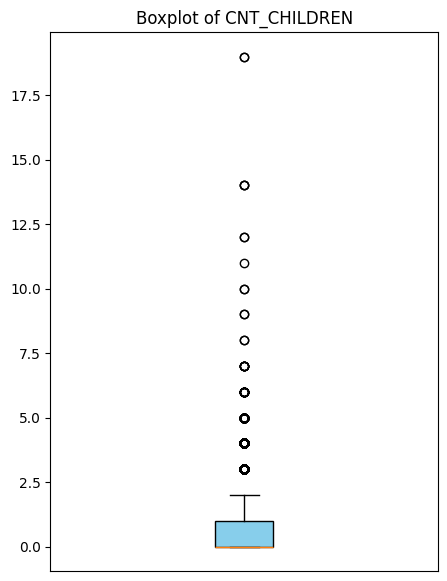

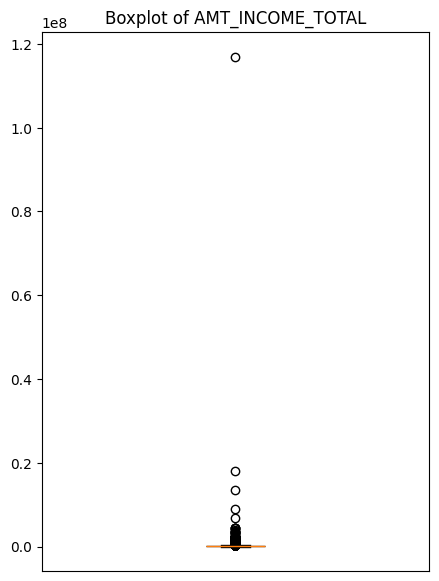

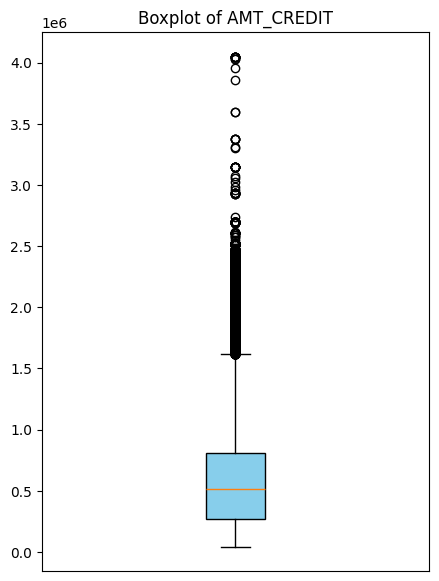

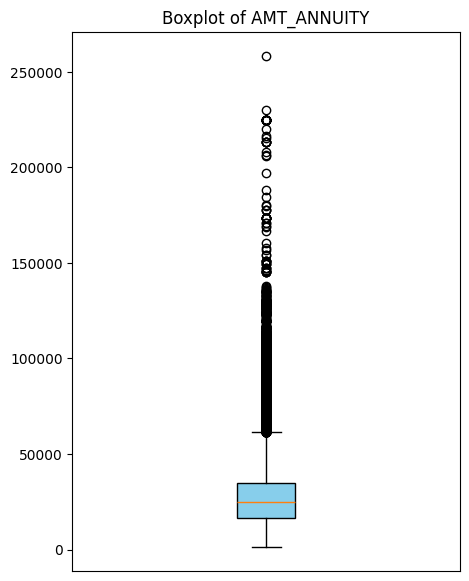

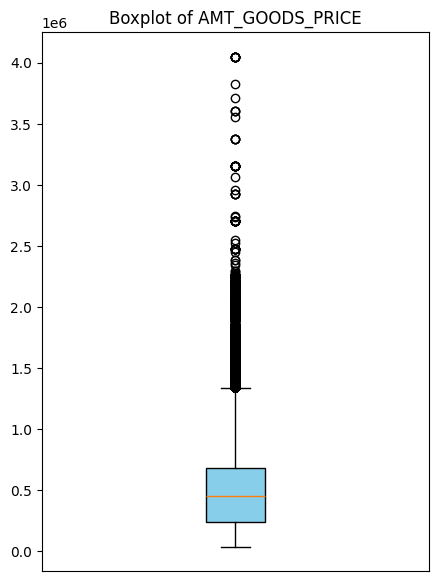

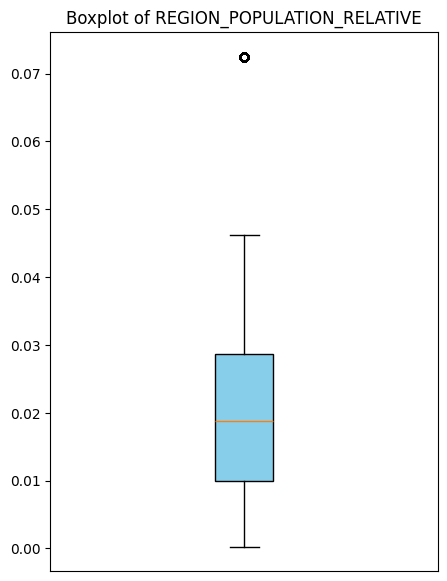

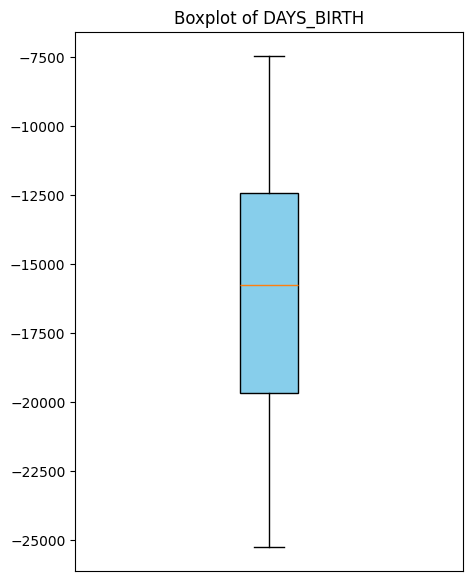

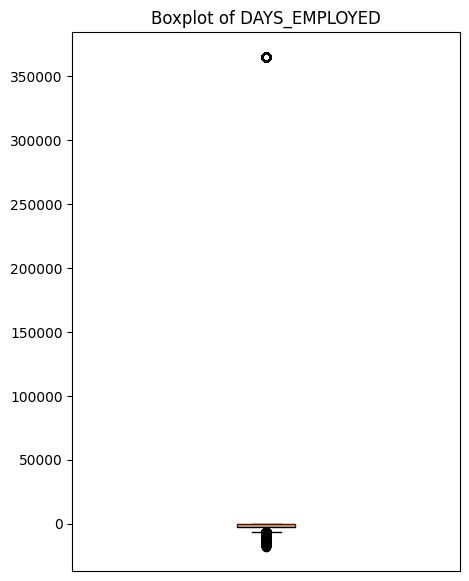

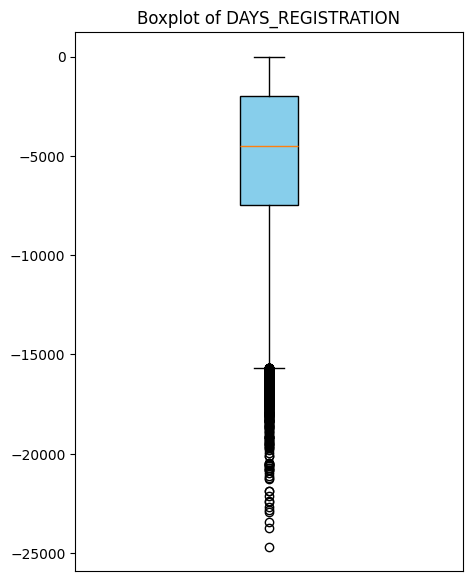

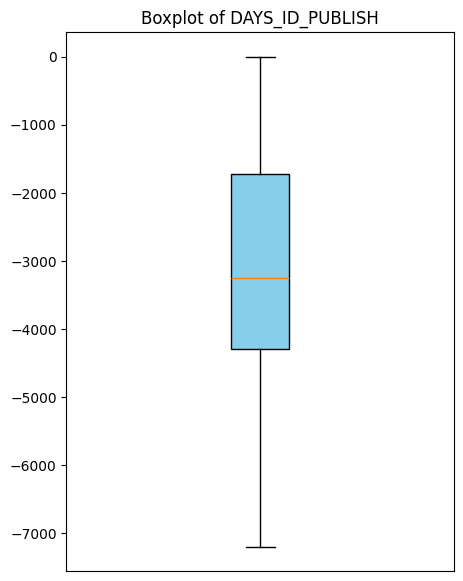

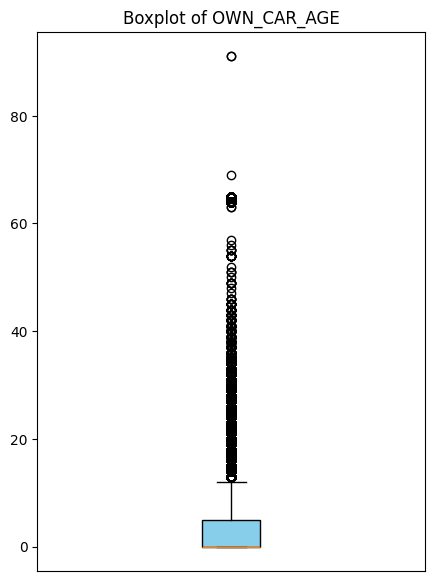

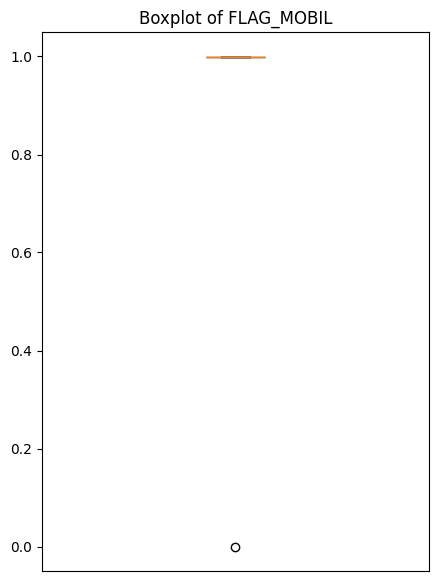

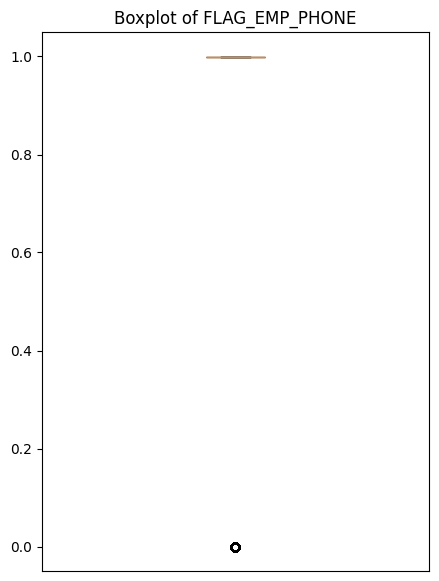

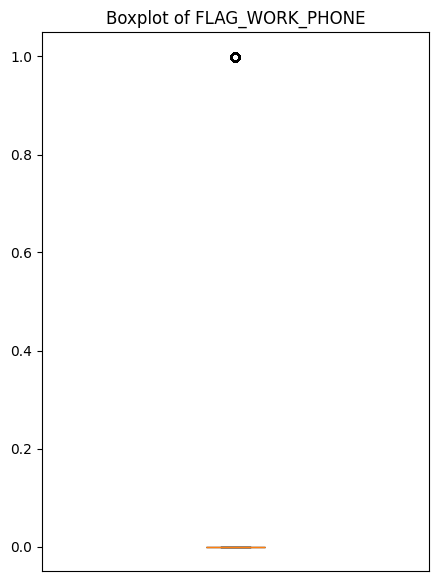

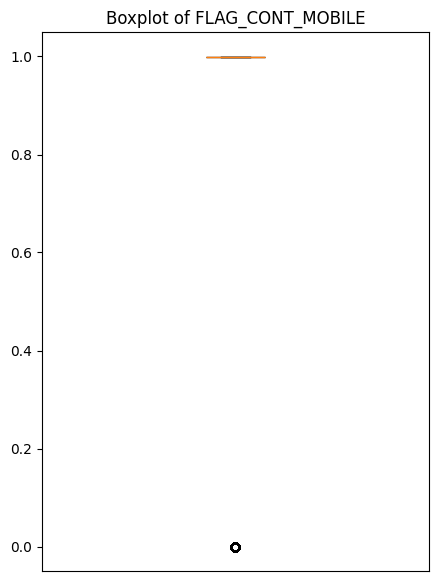

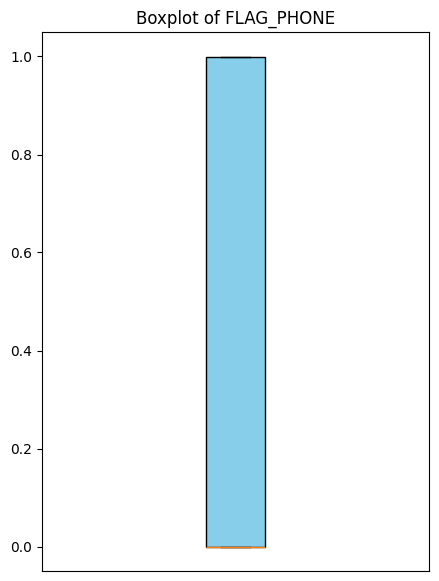

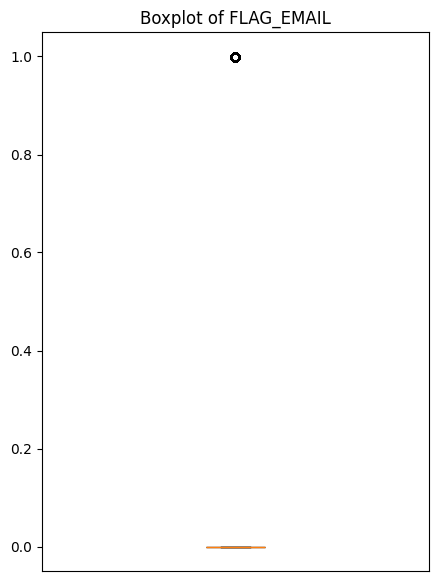

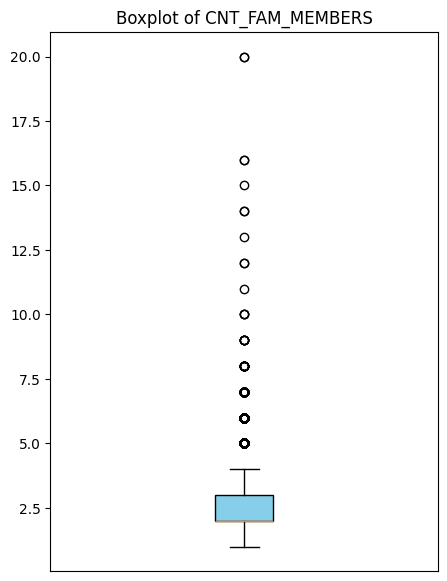

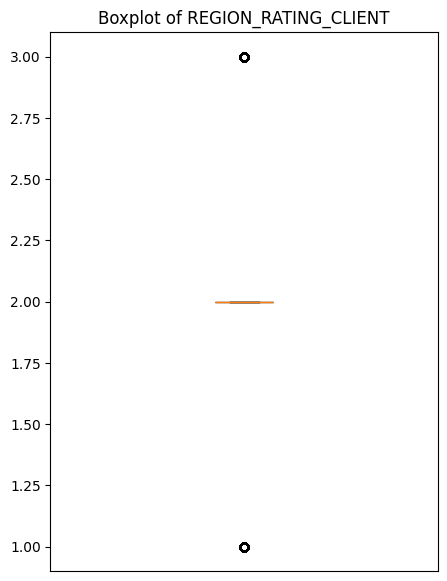

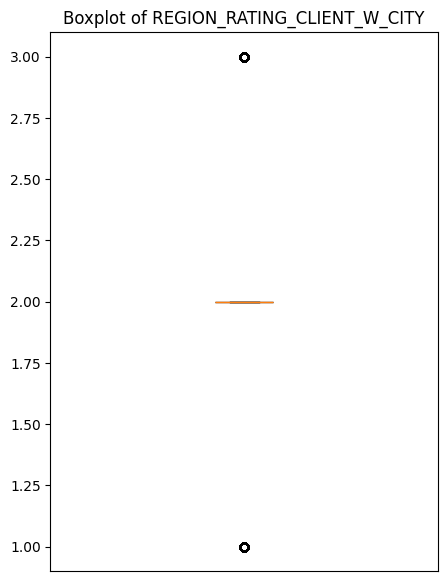

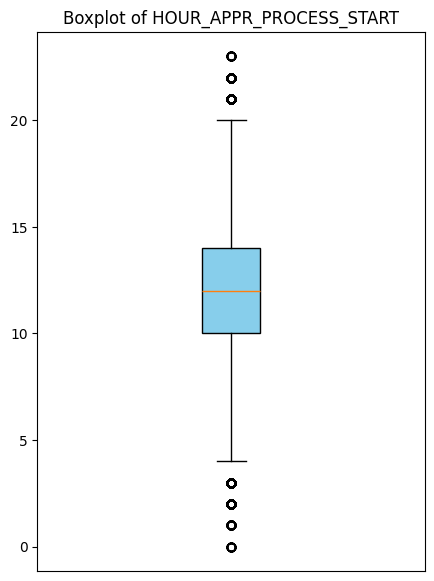

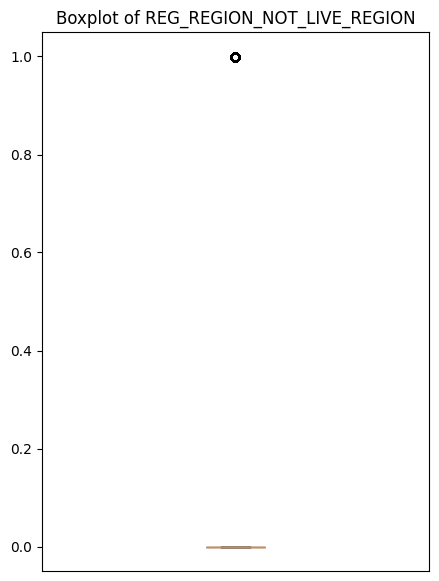

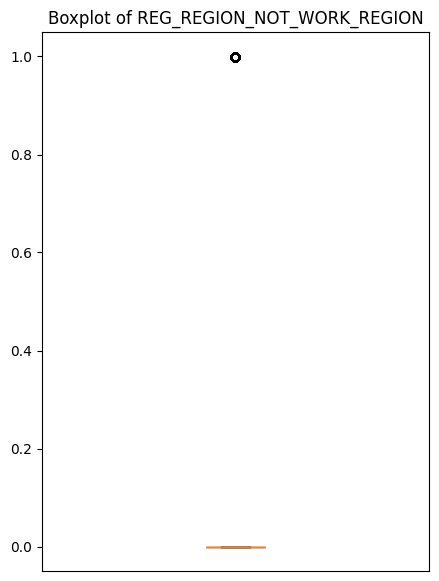

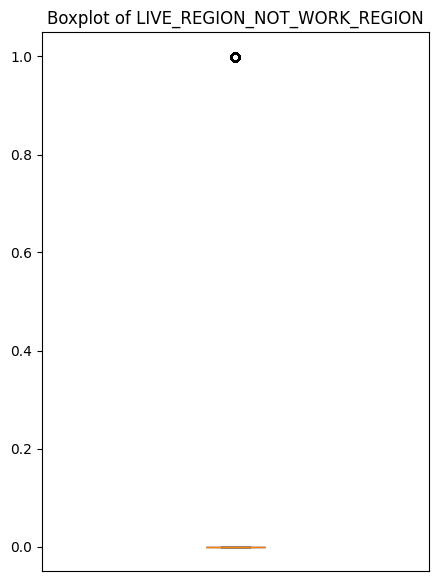

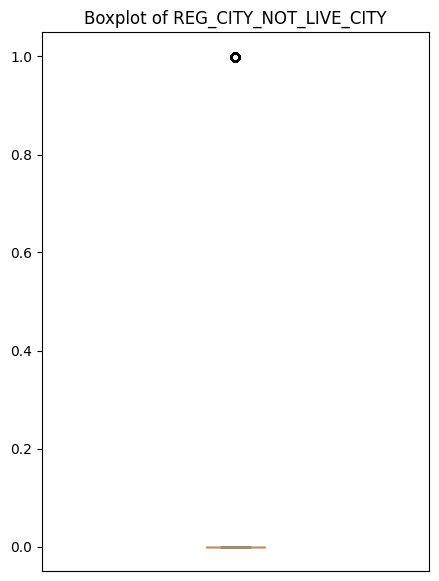

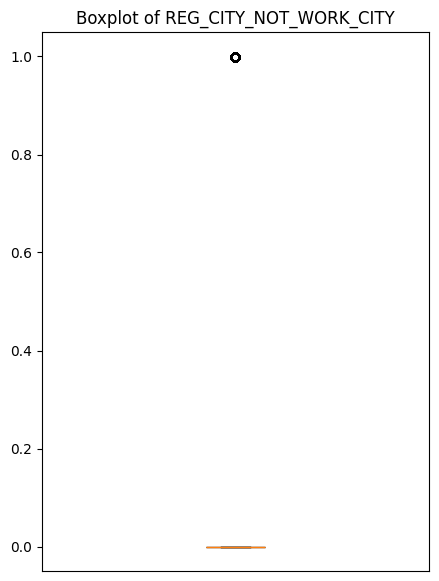

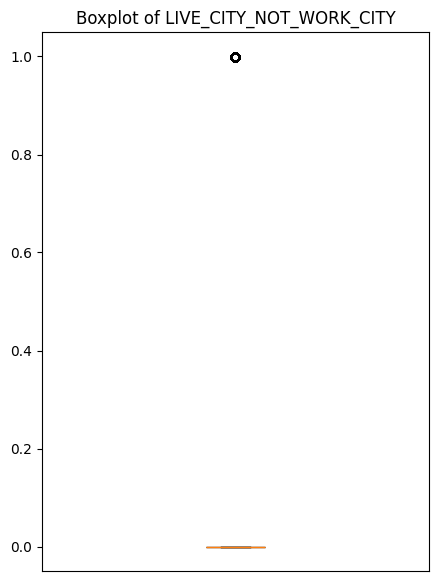

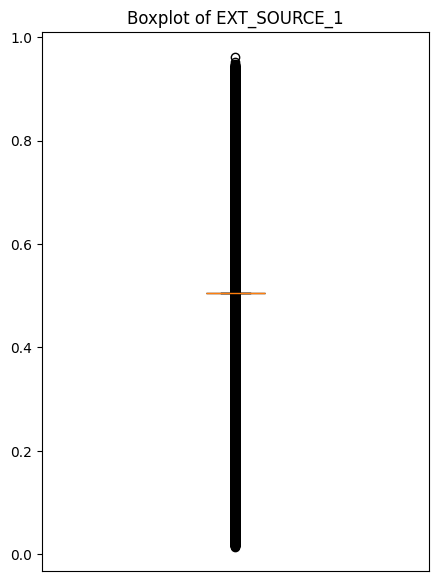

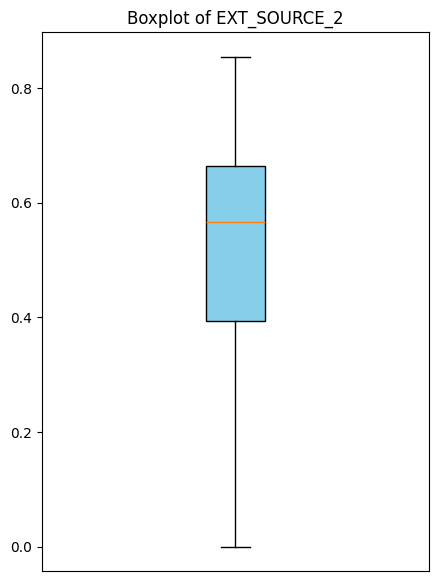

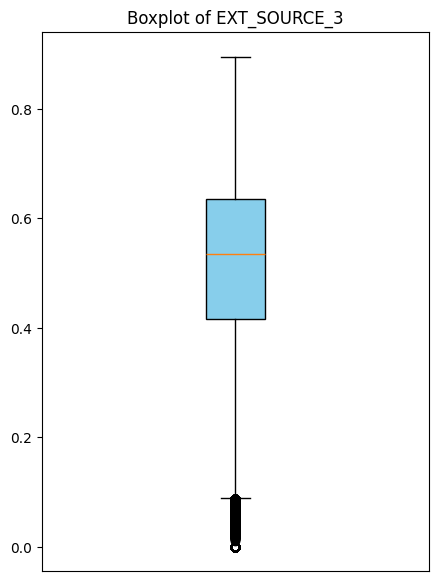

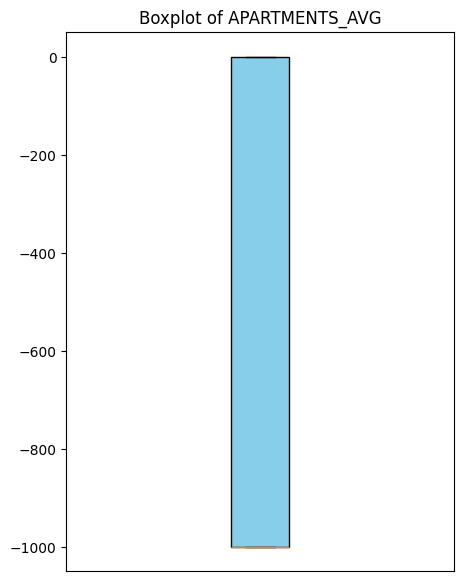

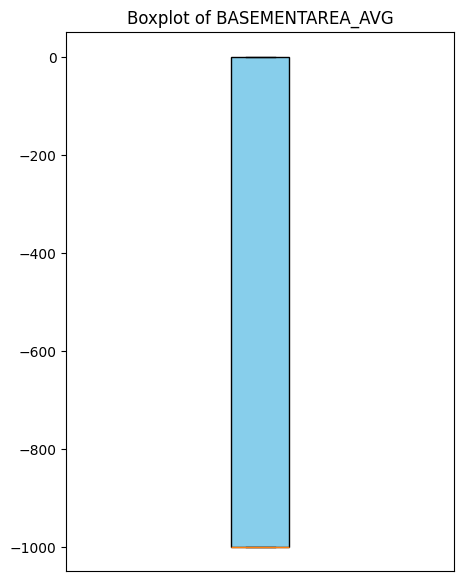

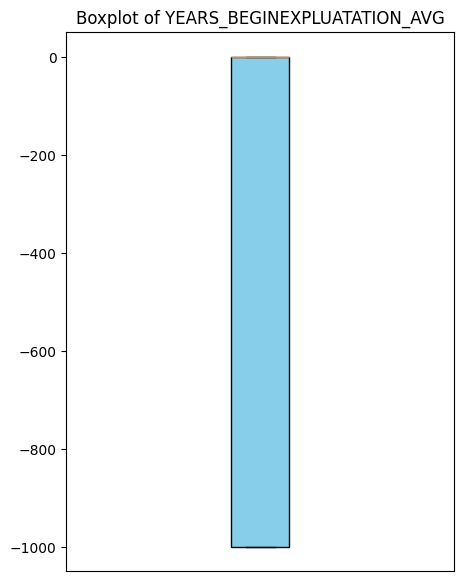

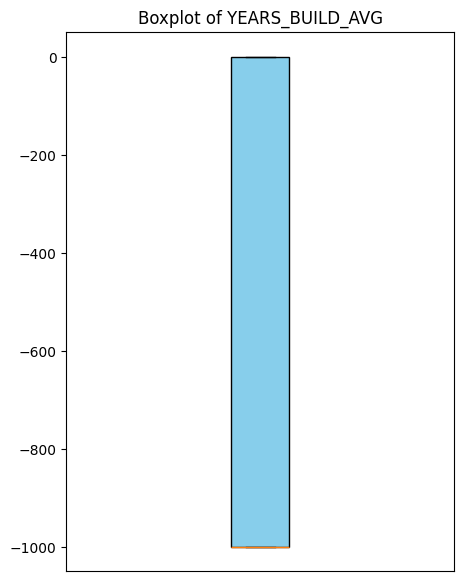

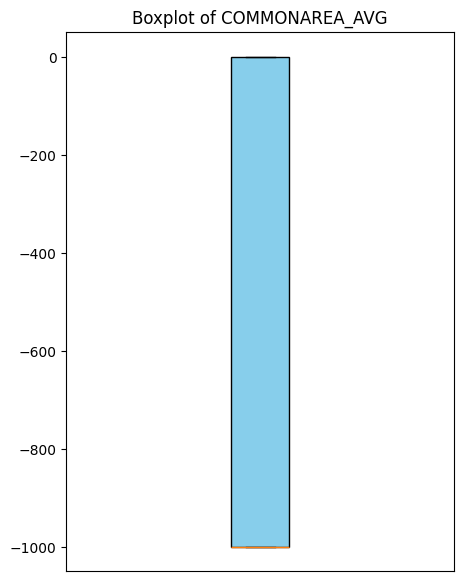

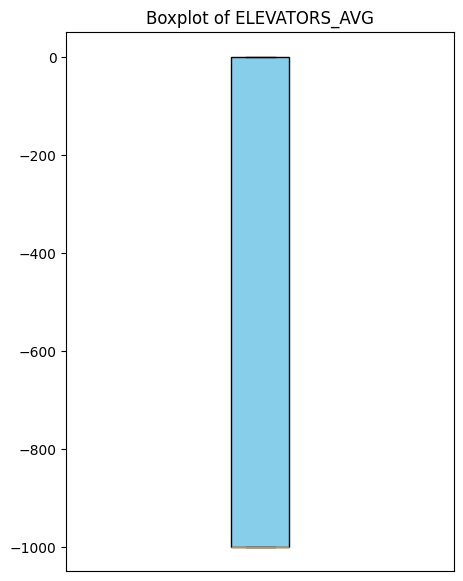

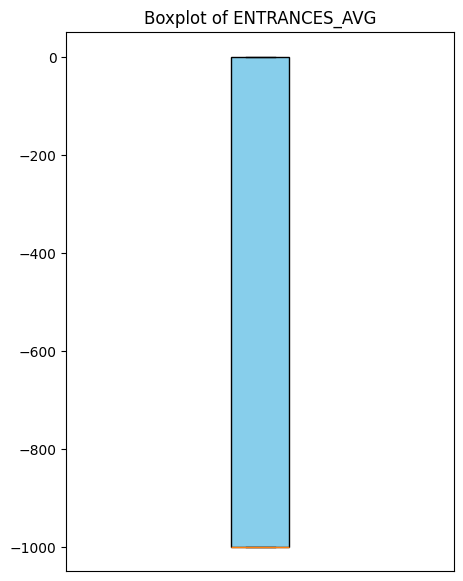

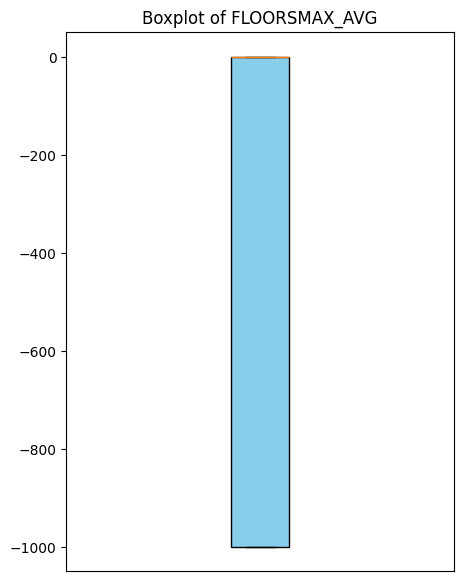

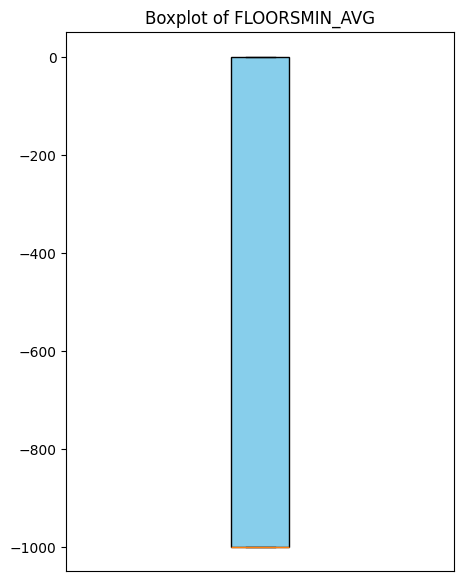

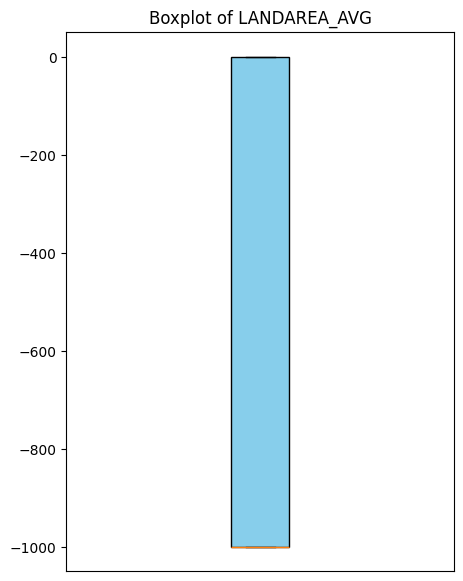

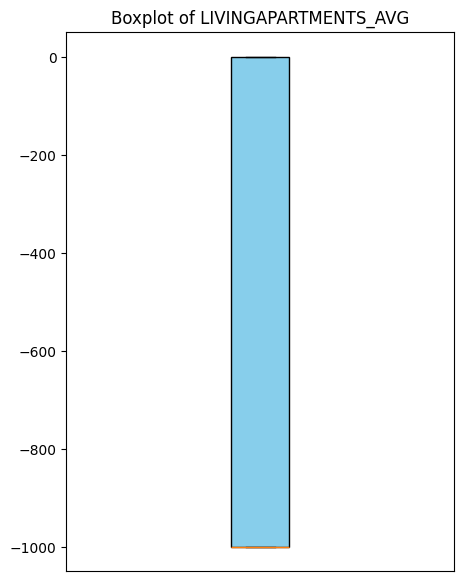

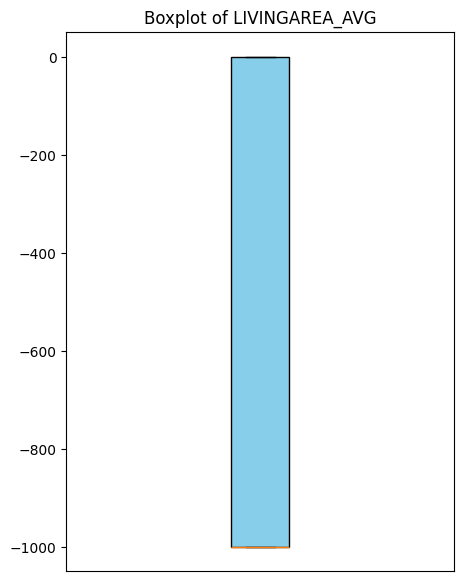

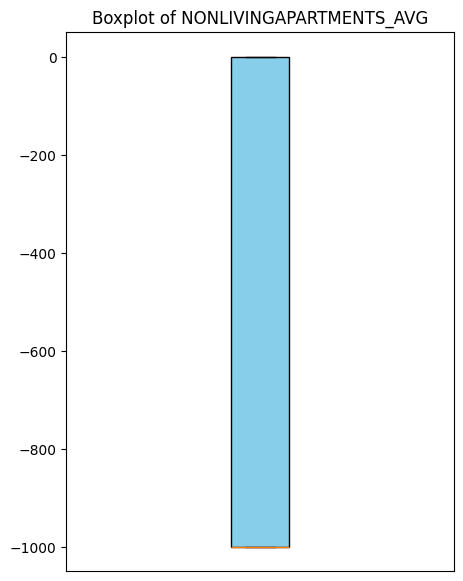

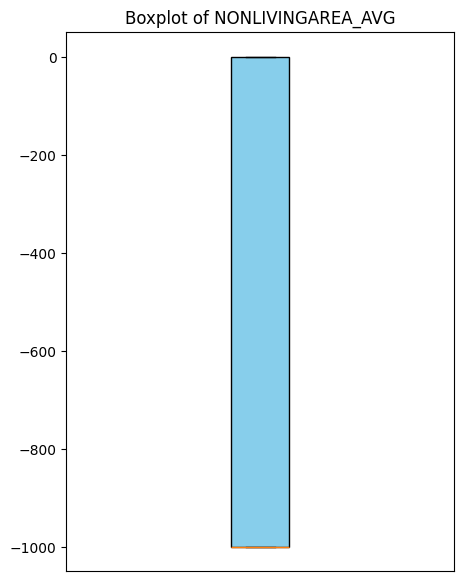

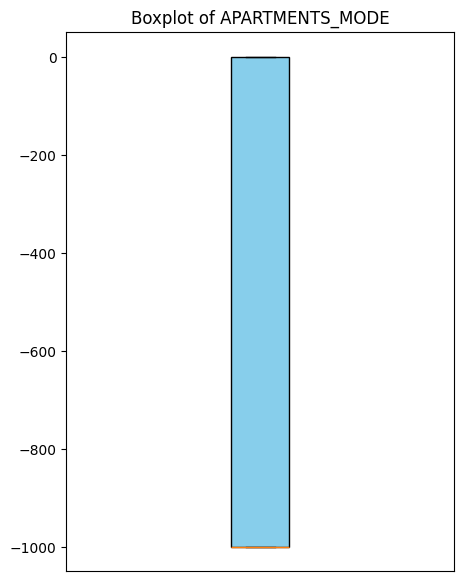

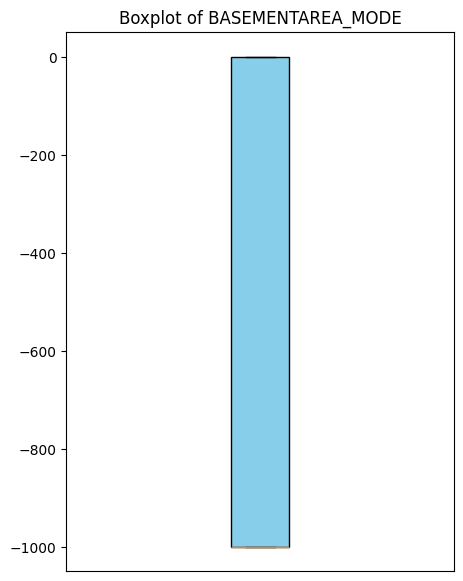

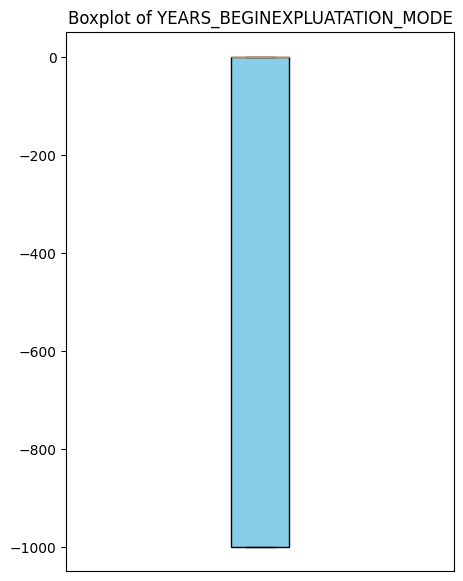

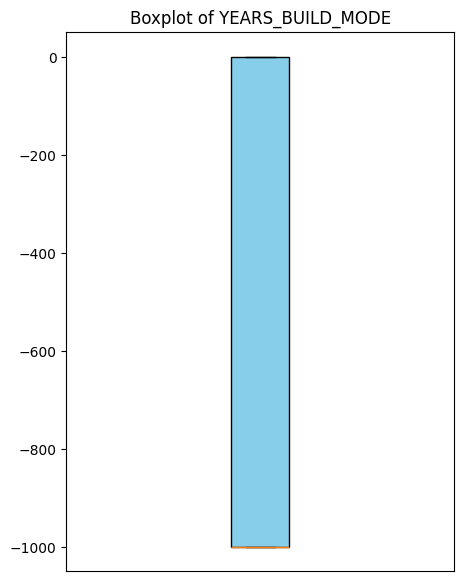

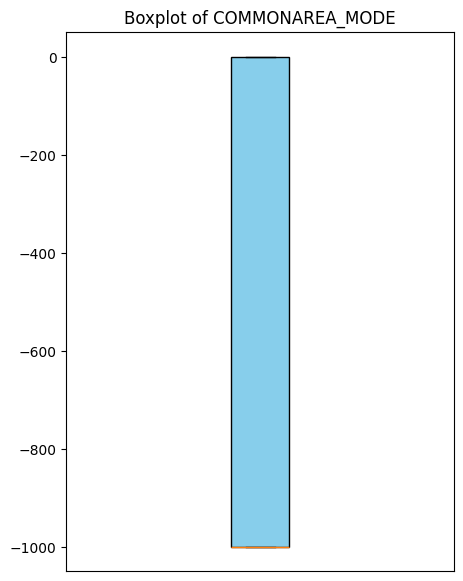

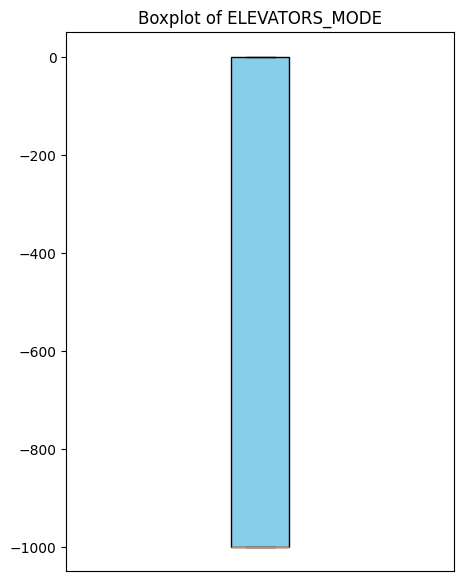

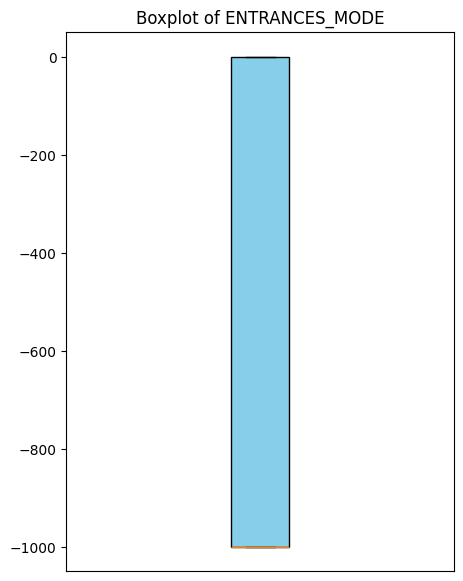

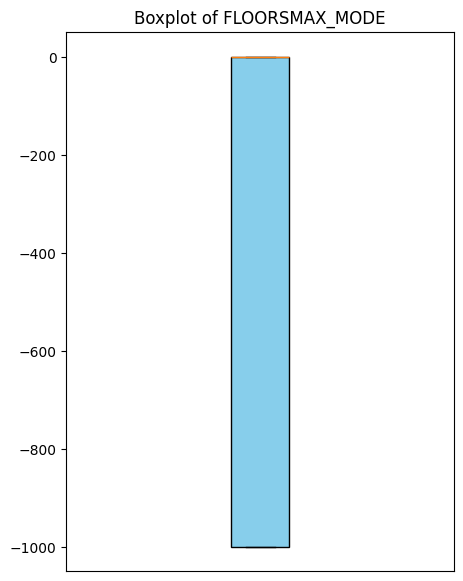

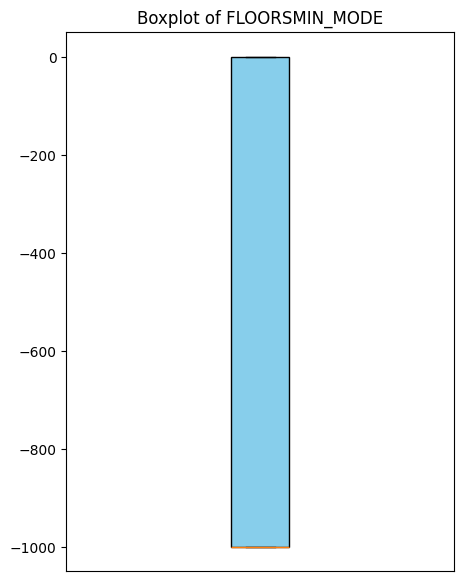

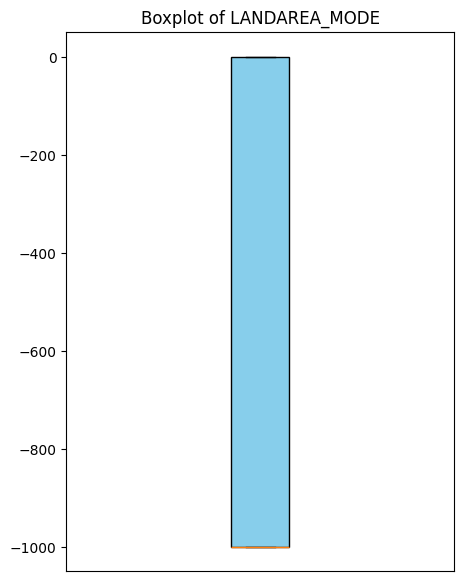

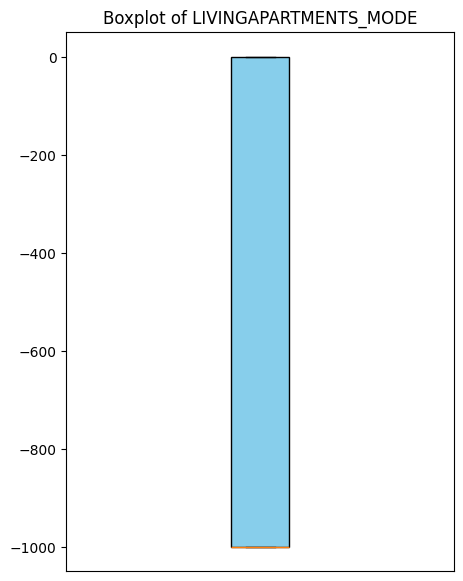

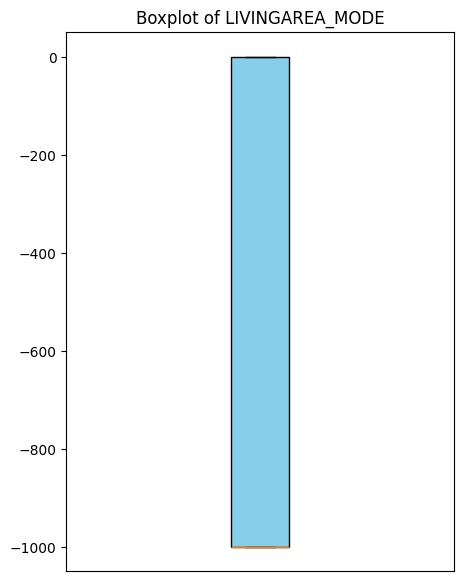

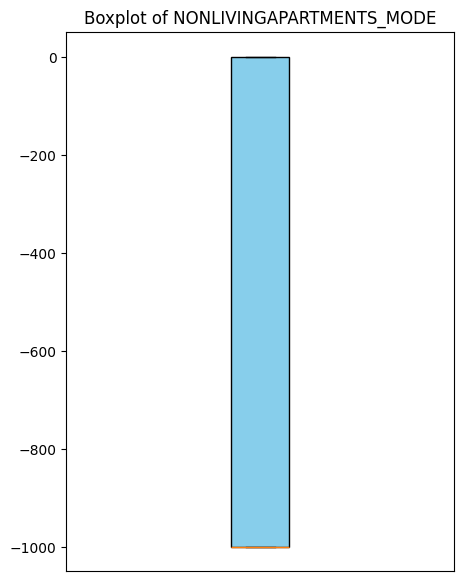

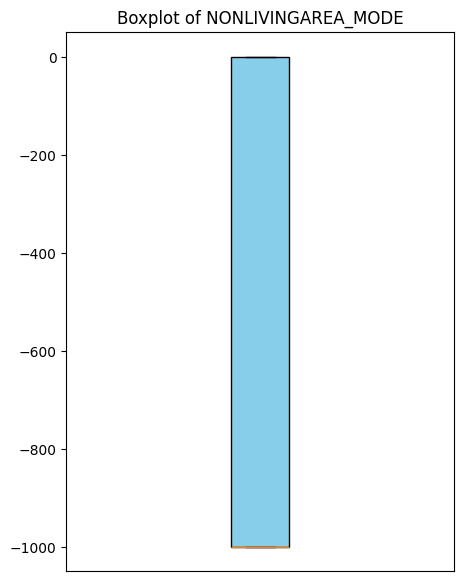

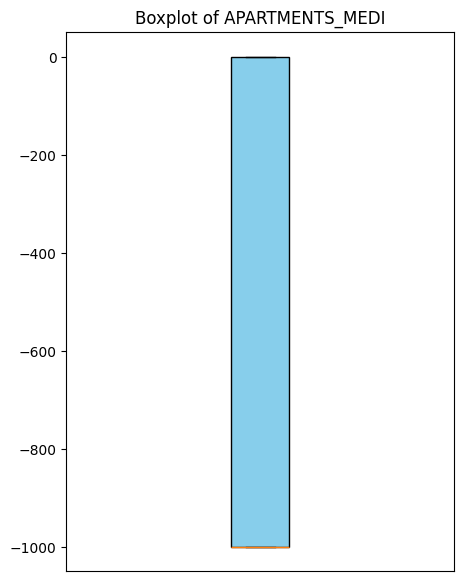

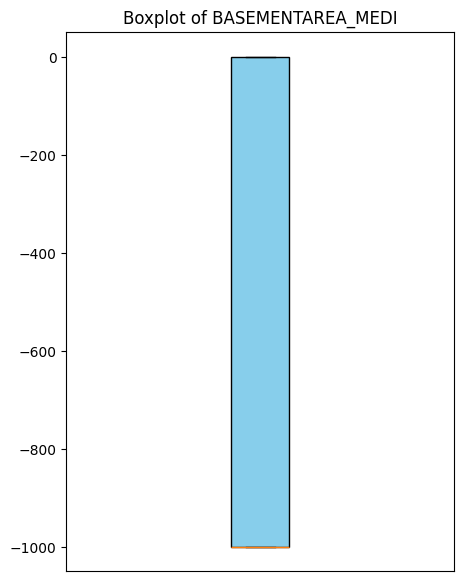

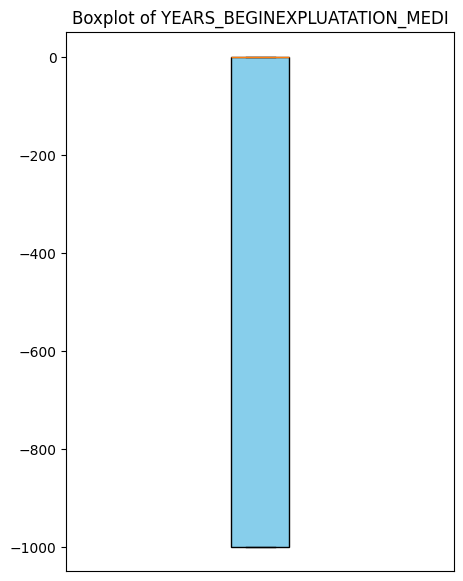

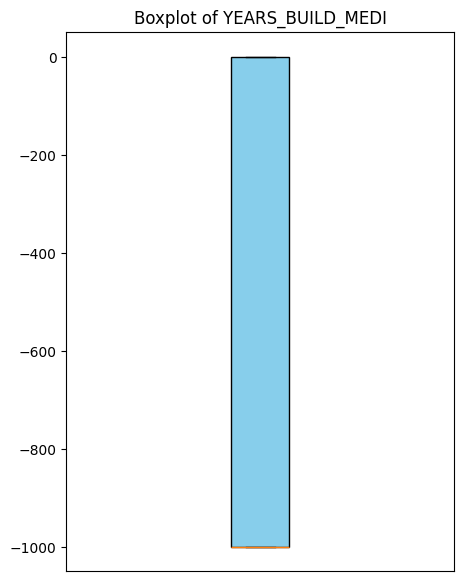

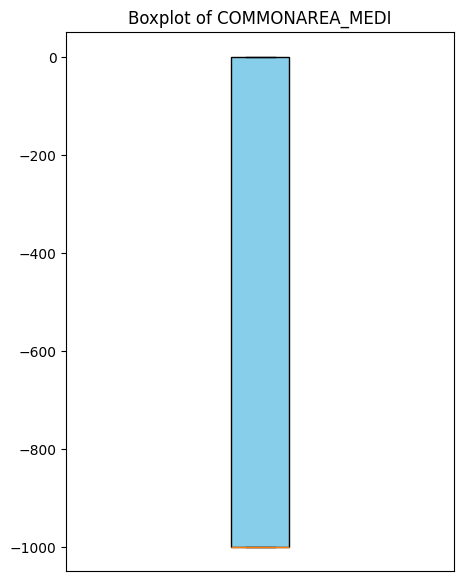

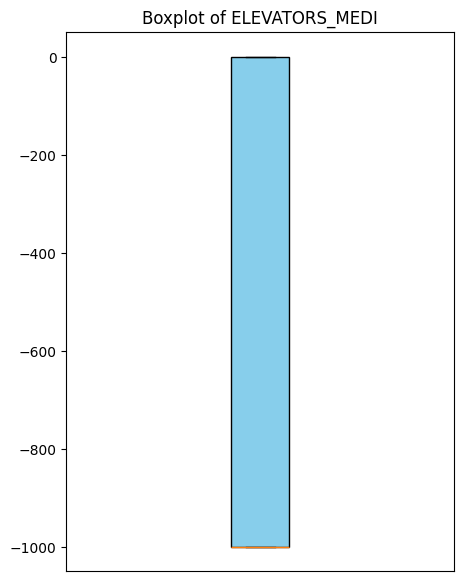

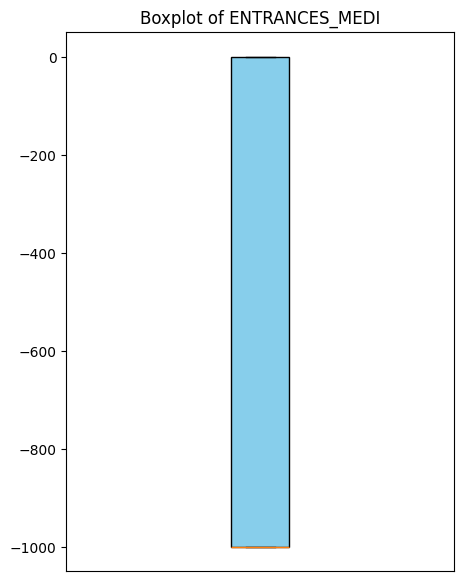

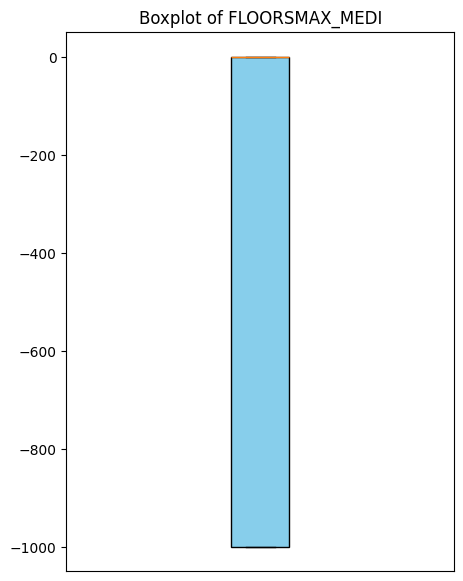

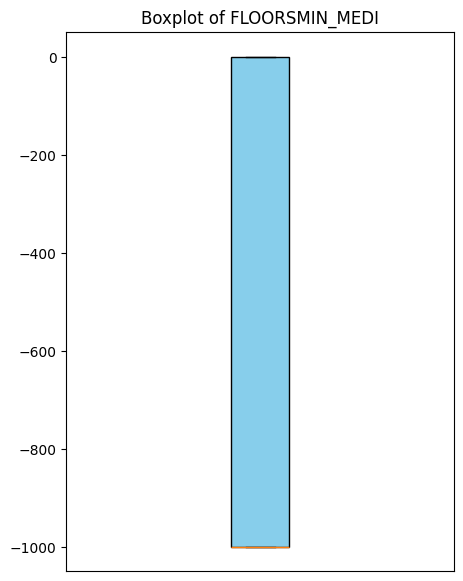

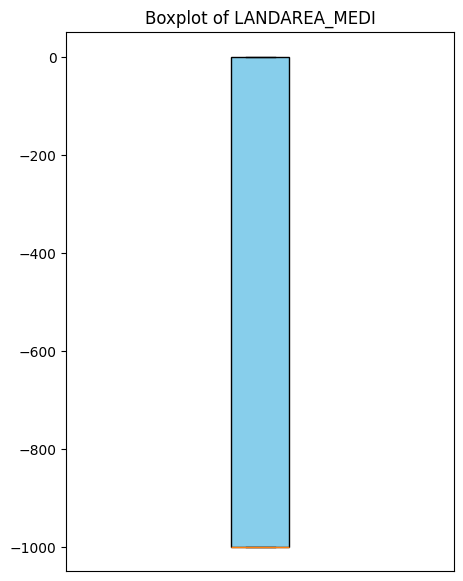

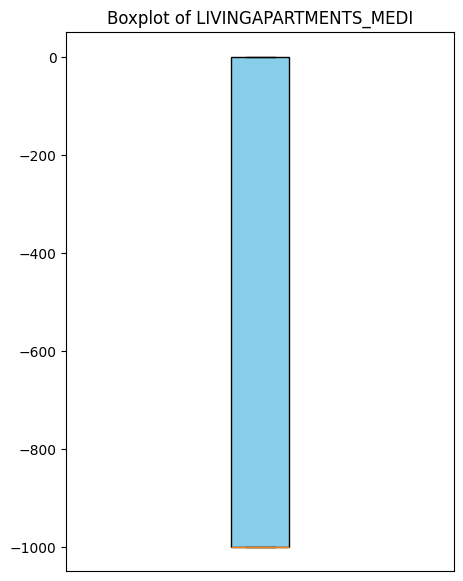

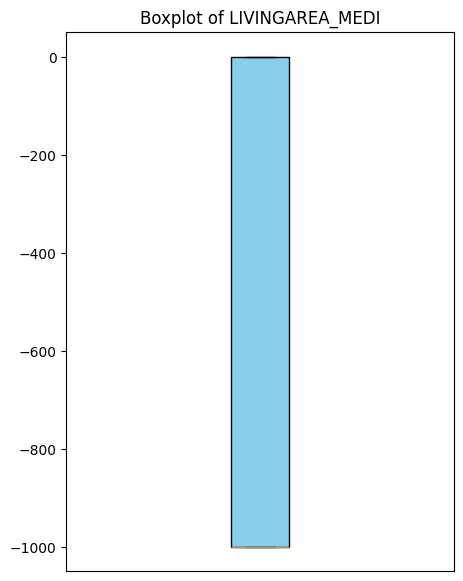

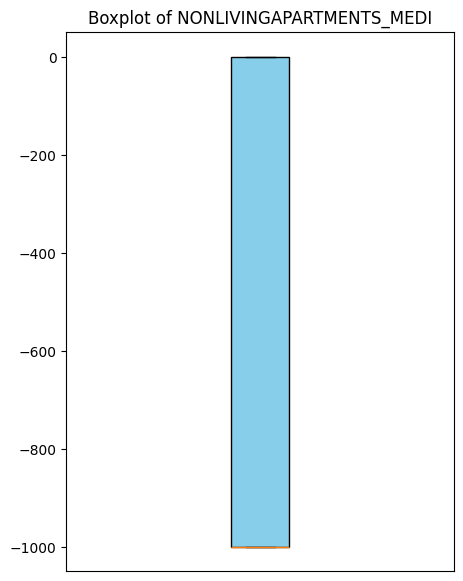

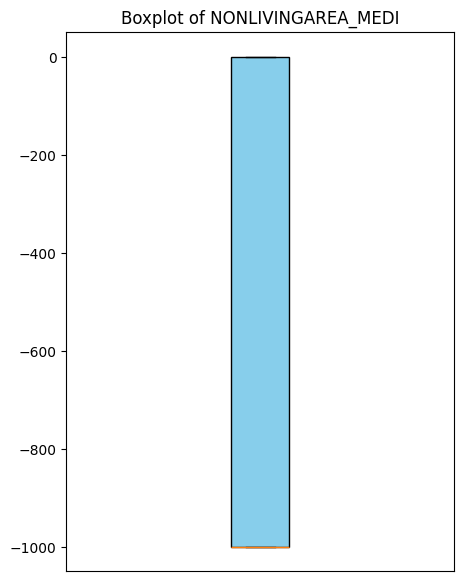

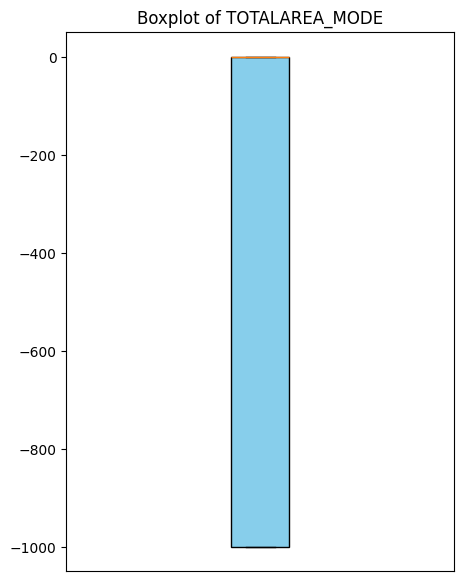

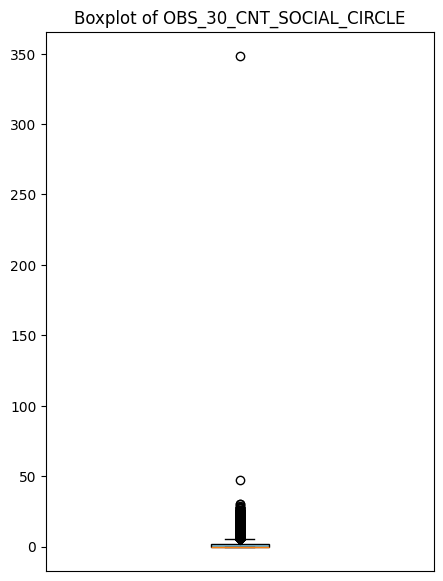

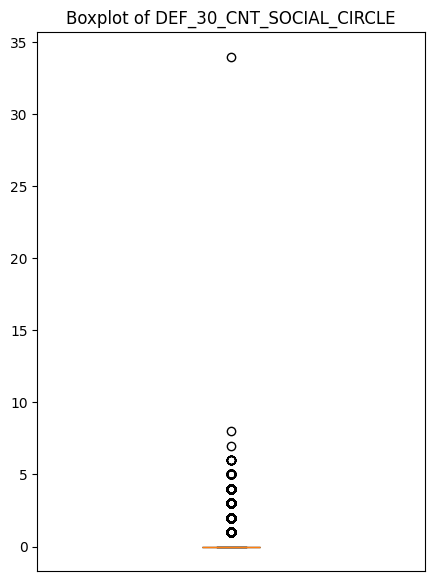

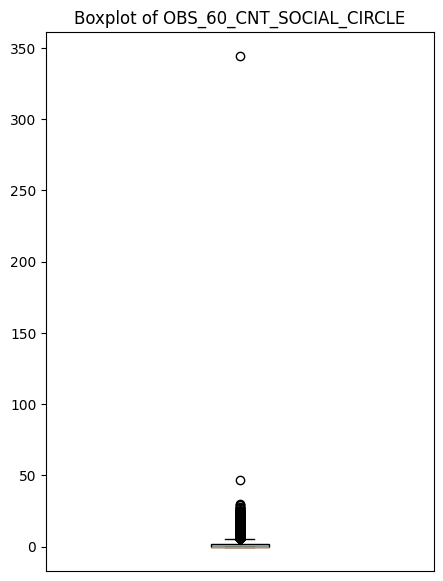

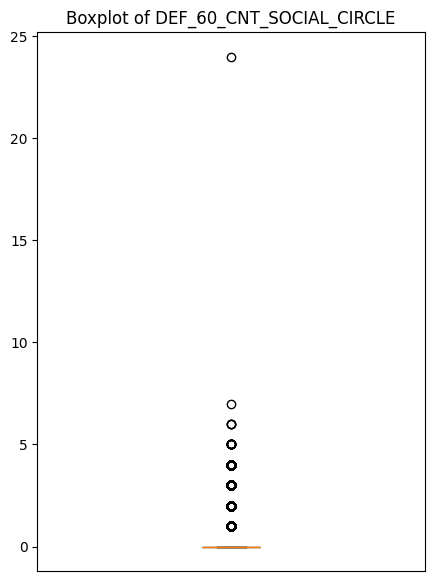

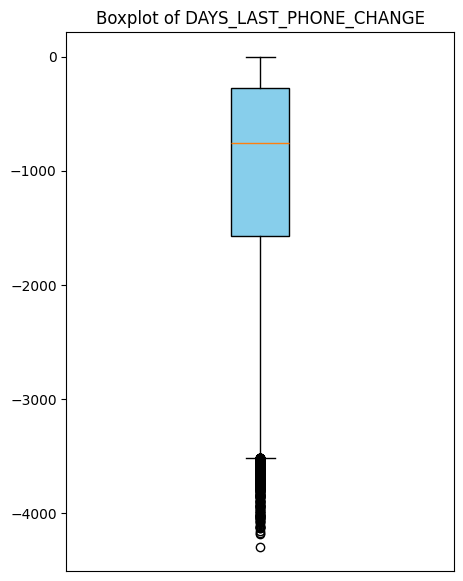

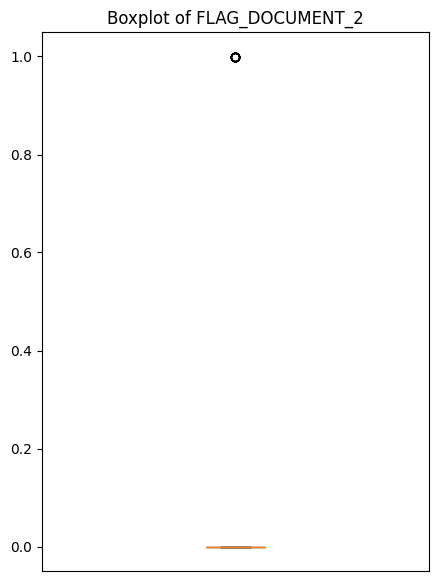

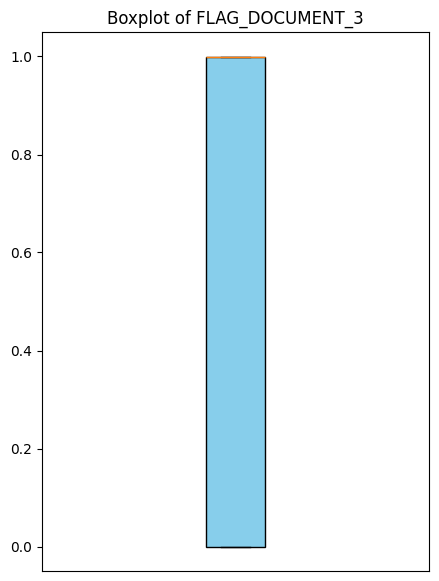

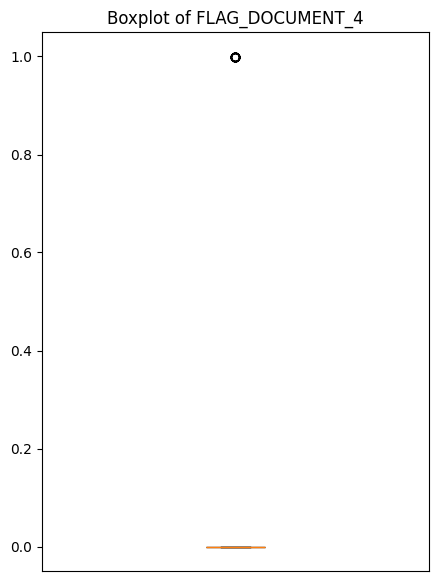

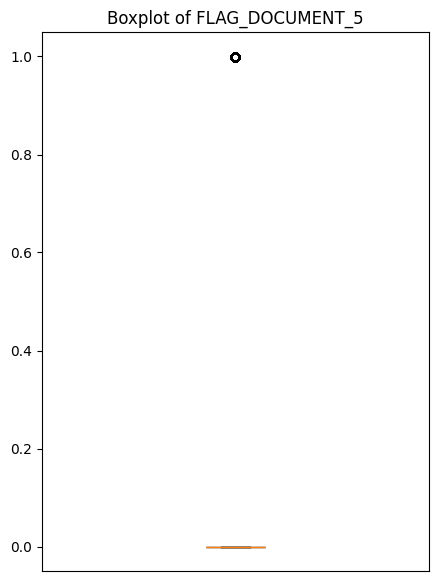

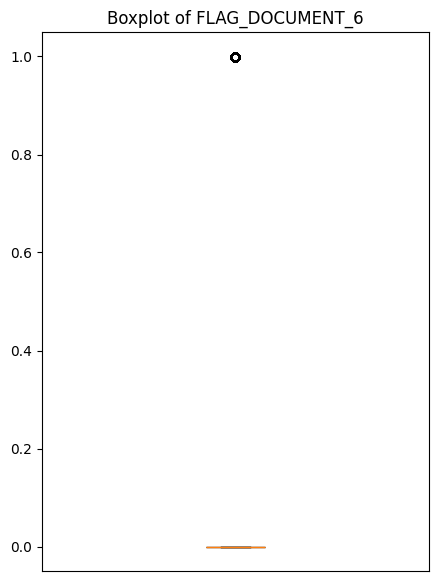

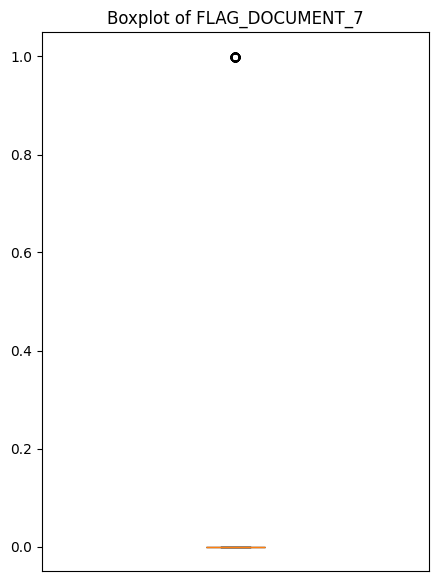

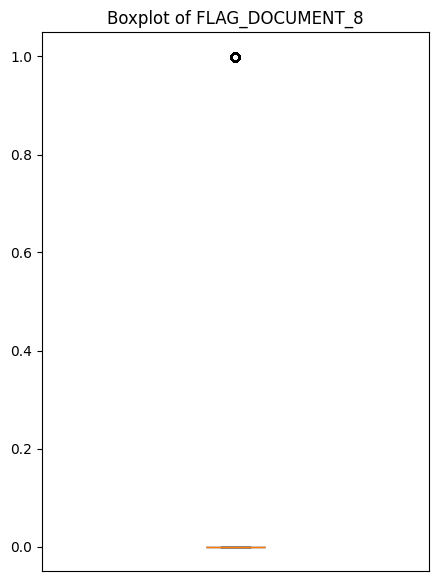

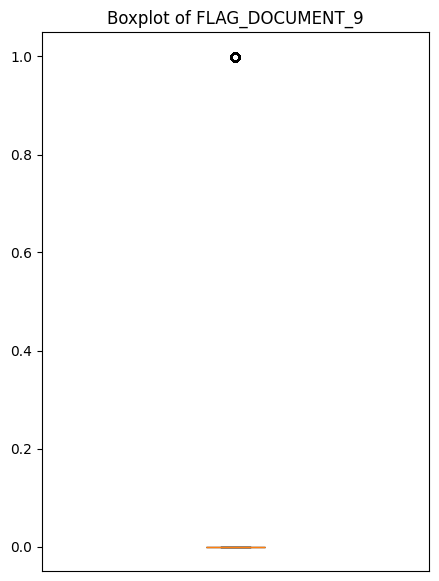

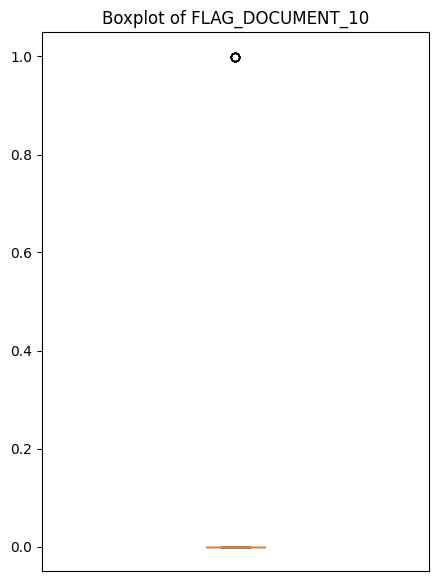

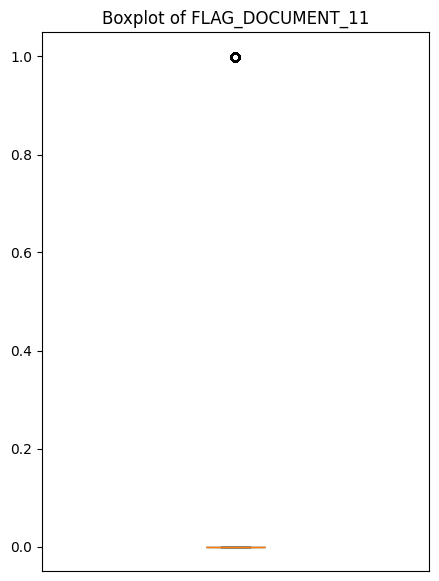

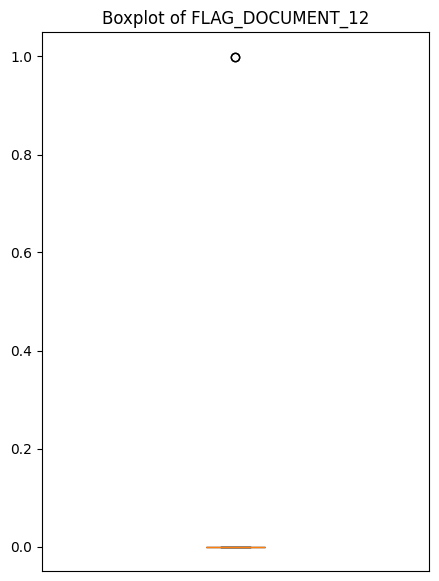

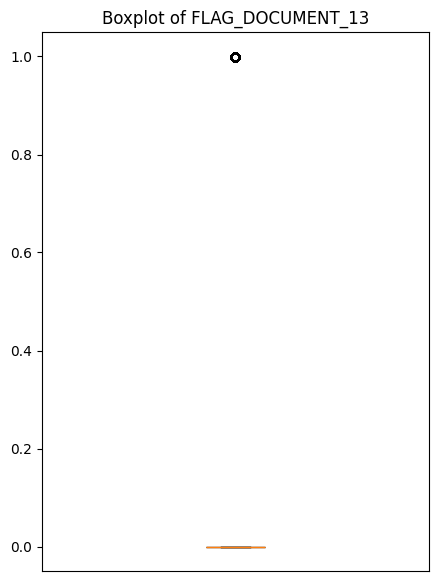

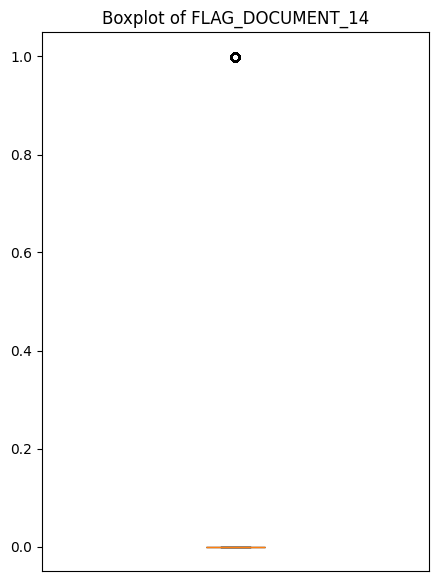

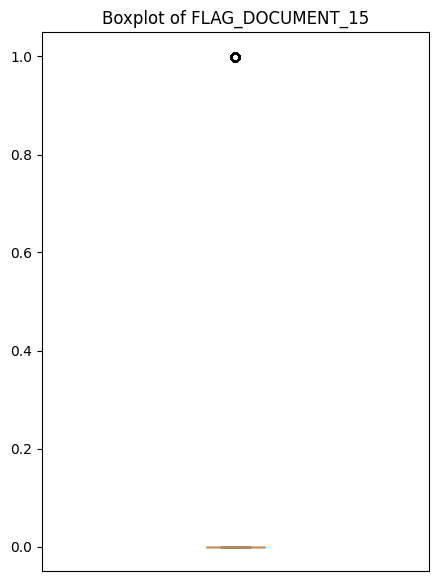

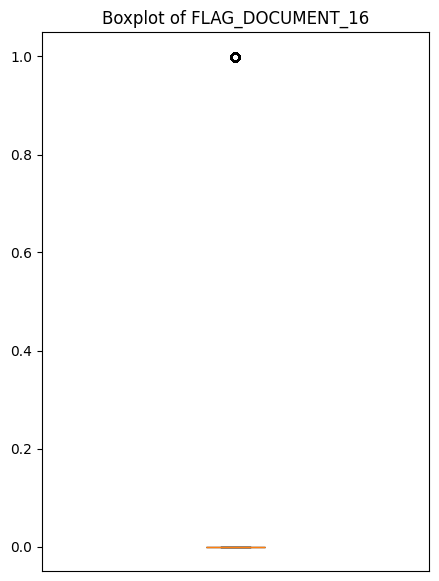

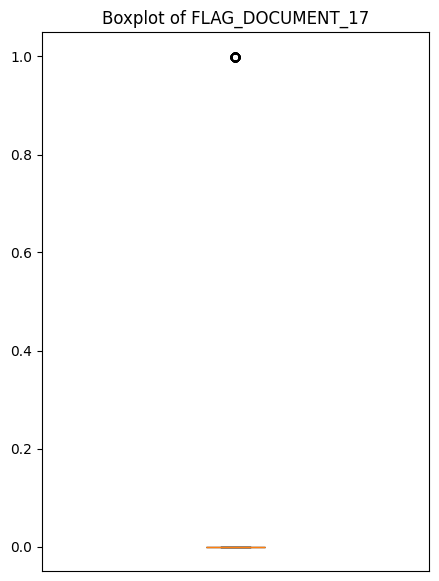

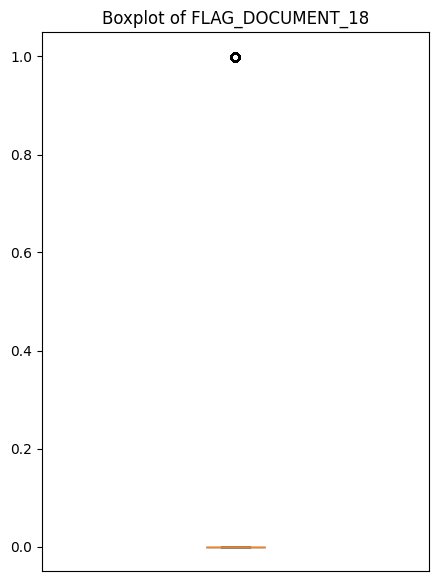

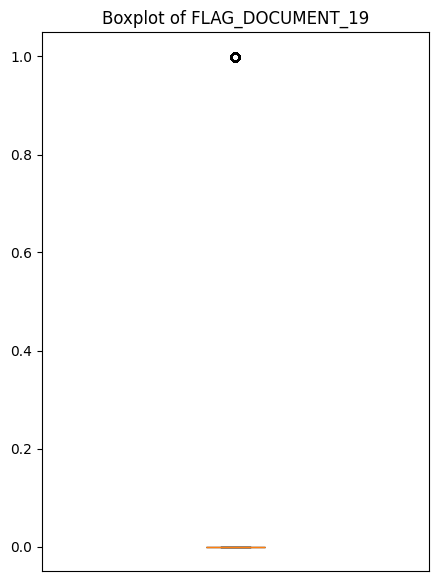

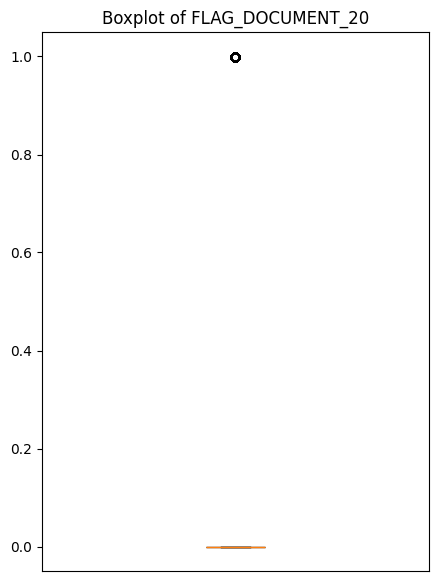

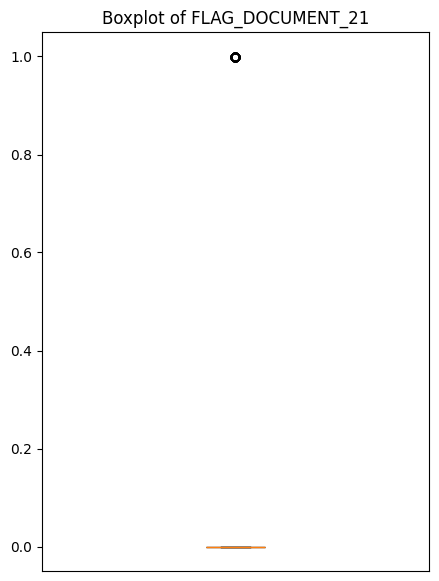

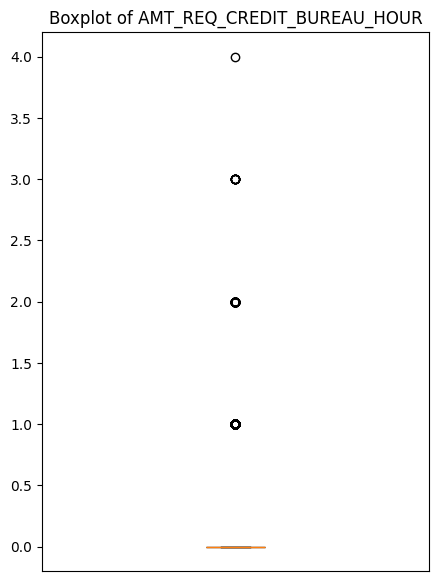

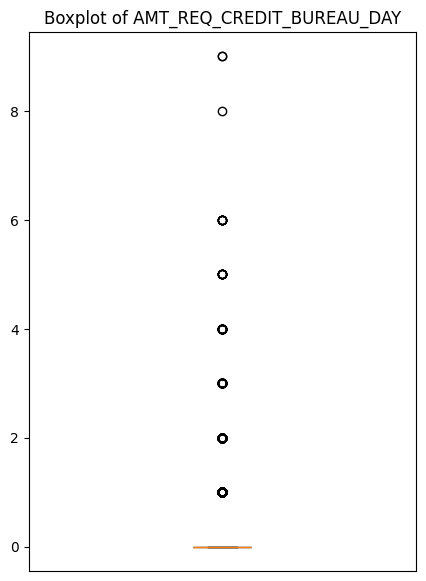

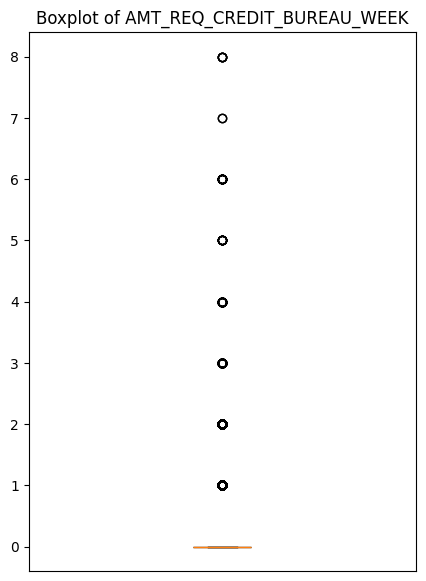

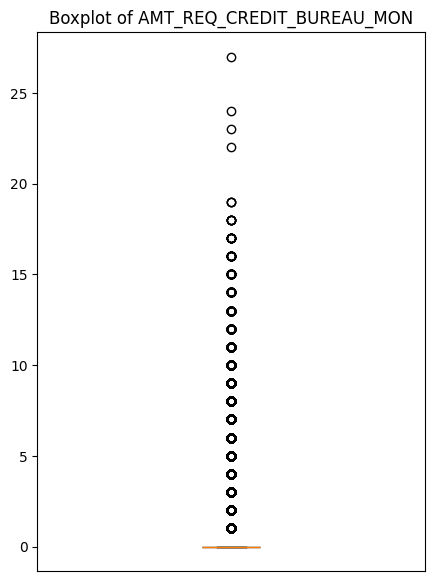

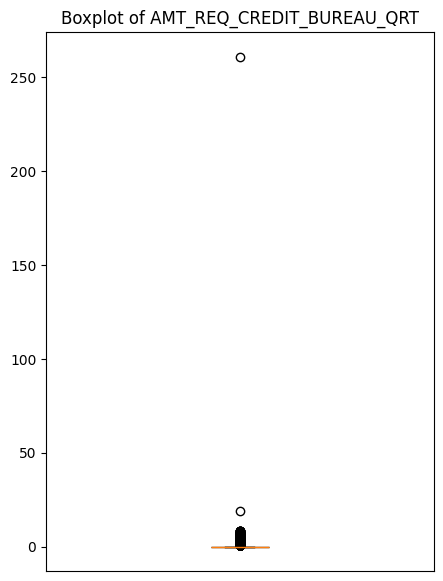

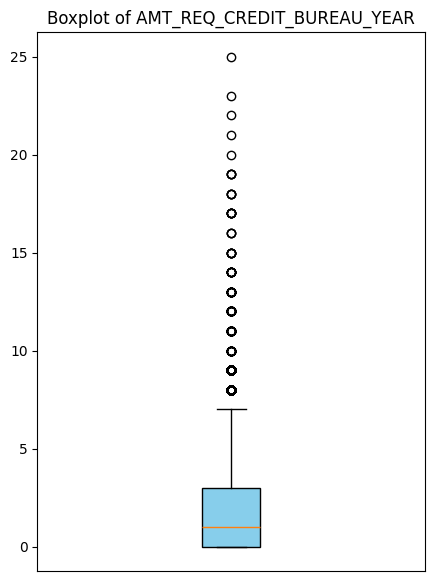

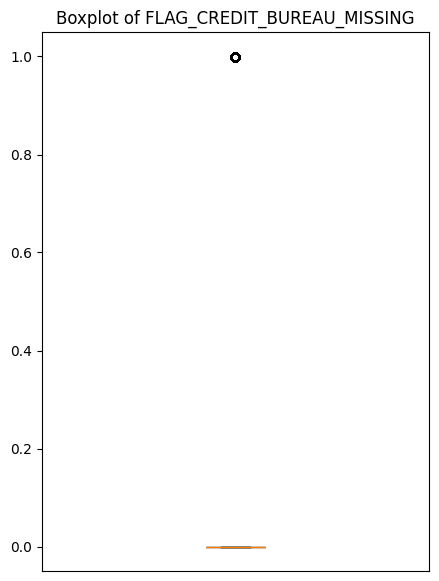

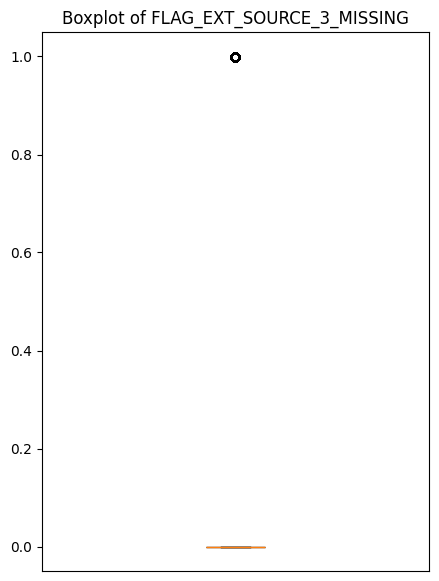

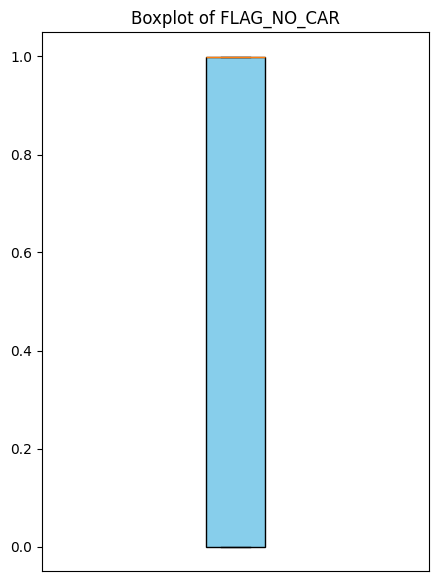

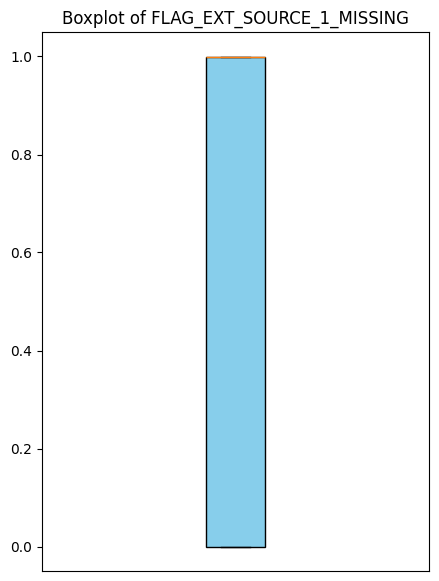

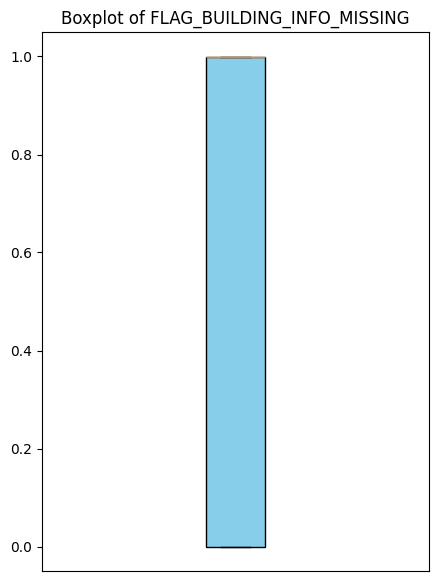

In [98]:
# Get only float-type columns
float_features = train.select_dtypes(include=['number']).columns

# Create individual boxplots
for feature in float_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

In [99]:
float_features = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "DAYS_EMPLOYED",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_QRT"
]

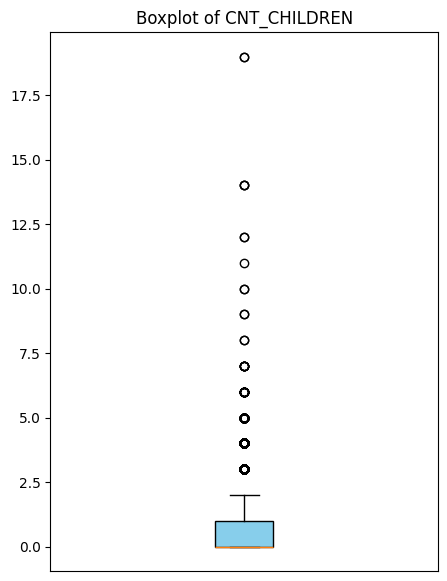

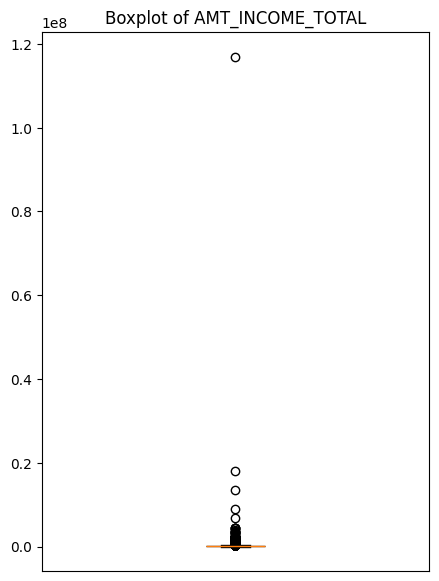

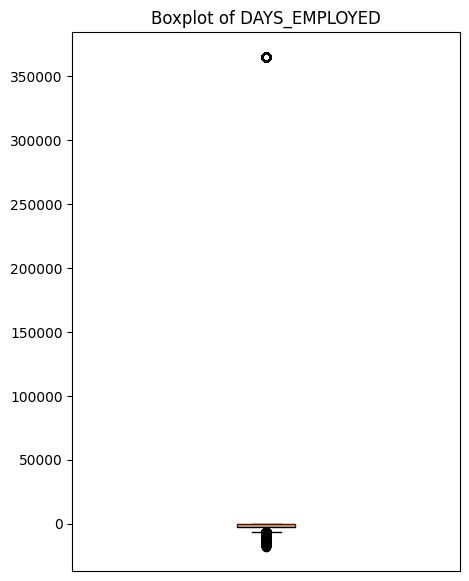

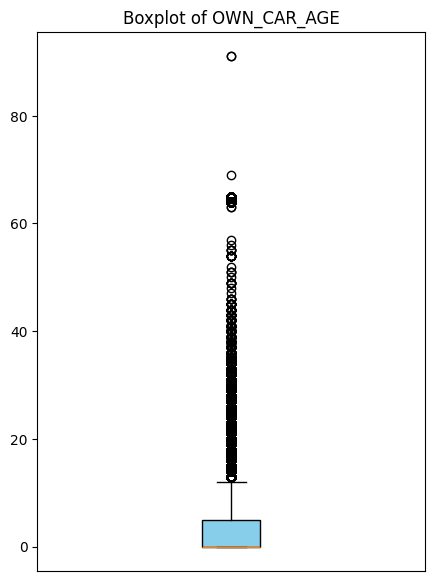

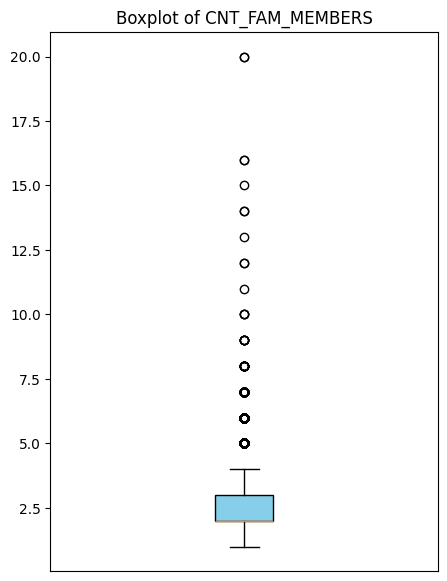

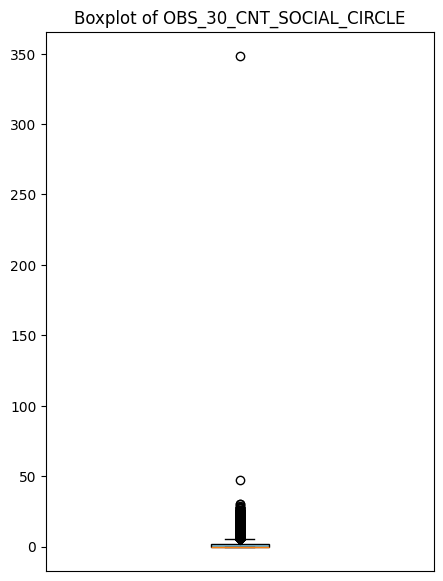

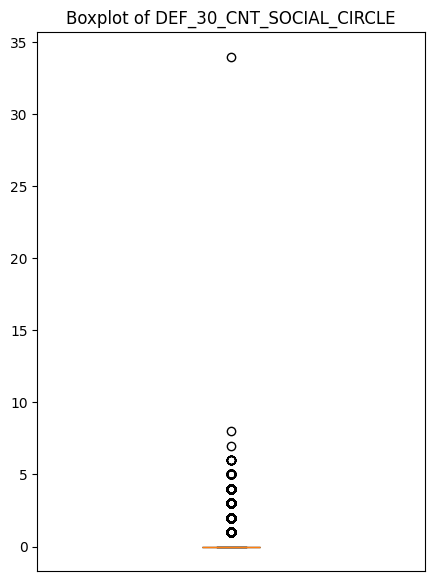

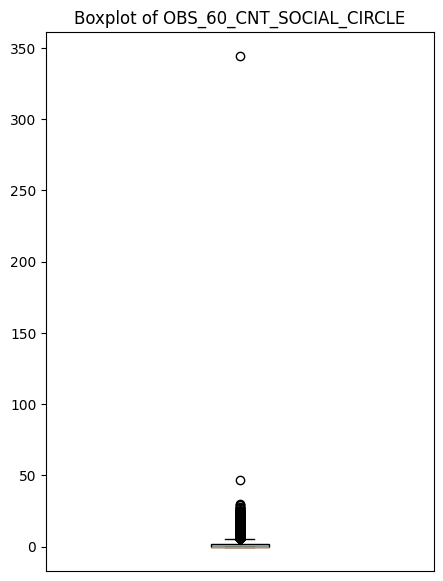

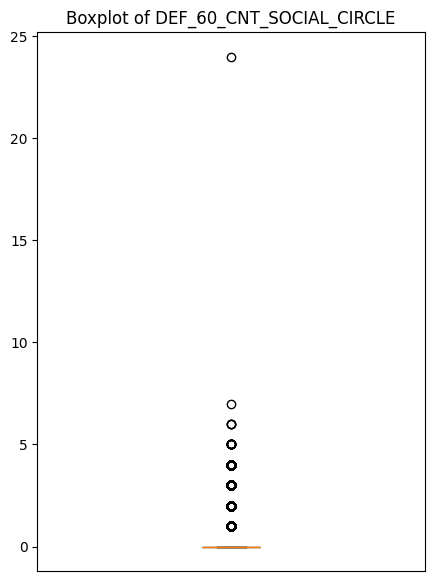

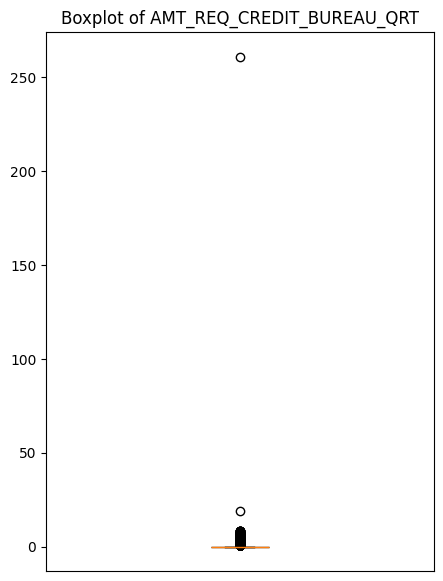

In [100]:
# Create individual boxplots
for feature in float_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

### AMT_INCOME_TOTAL

Currency &rightarrow; HUF (Hungarian Forint)

In [101]:
df.describe()['AMT_INCOME_TOTAL'].loc[['mean', 'min', '25%', '50%', '75%', 'max']]

mean      170116.060
min        25650.000
25%       112500.000
50%       153000.000
75%       202500.000
max    117000000.000
Name: AMT_INCOME_TOTAL, dtype: float64

In [102]:
train[train["AMT_INCOME_TOTAL"] > 0.3e8]

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
12840     114967      1         Cash loans           F            N   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
12840               Y             1     117000000.000  562491.000   

       AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
12840    26194.500       454500.000   Unaccompanied          Working   

                 NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
12840  Secondary / secondary special            Married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
12840                       0.011      -12615           -922   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
12840          -6762.000            -3643        0.000           1   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
12840               1                0                 1           0   

       FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
12840           0        Laborers            3.000                     2   

       REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
12840                            2                    TUESDAY   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
12840                       14                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
12840                           0                            0   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
12840                       0                       0   

       LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
12840                        0  Business Entity Type 3         0.461   

       EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
12840         0.113         0.146           0.103             0.095   

       YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
12840                        0.979         -999.000        -999.000   

       ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
12840          0.000          0.207          0.167       -999.000   

       LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
12840         0.069              -999.000           0.061   

       NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
12840                 -999.000           -999.000            0.105   

       BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
12840              0.098                         0.979          -999.000   

       COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
12840         -999.000           0.000           0.207           0.167   

       FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
12840        -999.000          0.070               -999.000            0.064   

       NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
12840                  -999.000            -999.000            0.104   

       BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
12840              0.095                         0.979          -999.000   

       COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
12840         -999.000           0.000           0.207           0.167   

       FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
12840        -999.000          0.070               -999.000            0.063   

       NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  \
12840                  -999.000            -999.000            Missing   

       HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
12840  block of flats           0.071       Stone, brick                  No   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
12840                     0.000                     0.000   

       OBS_6

In [103]:
train = train[train["AMT_INCOME_TOTAL"] <= 0.3e8]
test = test[test["AMT_INCOME_TOTAL"] <= 0.3e8]

In [104]:
train[train["AMT_INCOME_TOTAL"] > 0.3e8]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

### DAYS_EMPLOYED

In [105]:
train[train["DAYS_EMPLOYED"] > 350000][["DAYS_EMPLOYED"]]

DAYS_EMPLOYED
8              365243
11             365243
23             365243
38             365243
43             365243
...               ...
307469         365243
307483         365243
307487         365243
307505         365243
307507         365243

[55370 rows x 1 columns]

In [106]:
# Create a flag for unemployed/retired/pensioner
train['FLAG_UNEMPLOYED'] = (train['DAYS_EMPLOYED'] == 365243).astype(int)
test['FLAG_UNEMPLOYED'] = (test['DAYS_EMPLOYED'] == 365243).astype(int)
df['FLAG_UNEMPLOYED'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)

#### YEARS_EMPLOYED

In [107]:
# Convert days to years (negative → employed, NaN → unemployed)
train['YEARS_EMPLOYED'] = -train['DAYS_EMPLOYED'] / 365  # Negative because days are backwards
test['YEARS_EMPLOYED'] = -test['DAYS_EMPLOYED'] / 365  # Negative because days are backwards
df['YEARS_EMPLOYED'] = -df['DAYS_EMPLOYED'] / 365  # Negative because days are backwards

#### Employment Status Categories

In [108]:
# ===== Employment Status Binning =====

# TRAIN
conditions = [
    train['DAYS_EMPLOYED'] == 365243,   # Unemployed
    train['DAYS_EMPLOYED'] < -3650,     # Employed >10 years
    train['DAYS_EMPLOYED'] < -730,      # Employed 2–10 years
    train['DAYS_EMPLOYED'] < 0          # Employed <2 years
]
labels = ['Unemployed', 'Long_Term', 'Mid_Term', 'Short_Term']
train['EMPLOYMENT_STATUS'] = np.select(conditions, labels, default='Unknown')

# TEST
conditions = [
    test['DAYS_EMPLOYED'] == 365243,
    test['DAYS_EMPLOYED'] < -3650,
    test['DAYS_EMPLOYED'] < -730,
    test['DAYS_EMPLOYED'] < 0
]
test['EMPLOYMENT_STATUS'] = np.select(conditions, labels, default='Unknown')

# df
conditions = [
    df['DAYS_EMPLOYED'] == 365243,
    df['DAYS_EMPLOYED'] < -3650,
    df['DAYS_EMPLOYED'] < -730,
    df['DAYS_EMPLOYED'] < 0
]
df['EMPLOYMENT_STATUS'] = np.select(conditions, labels, default='Unknown')

### AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE

In [109]:
float_features = [
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE"
]

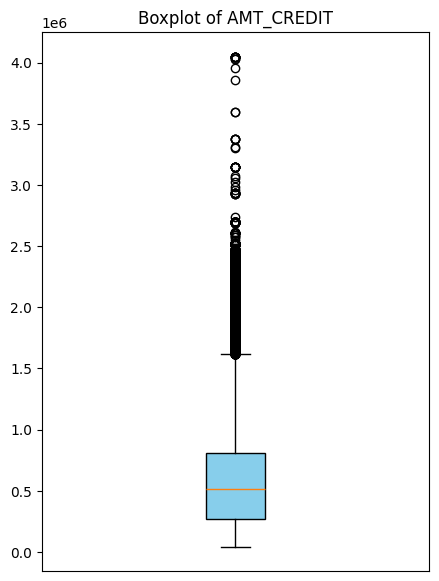

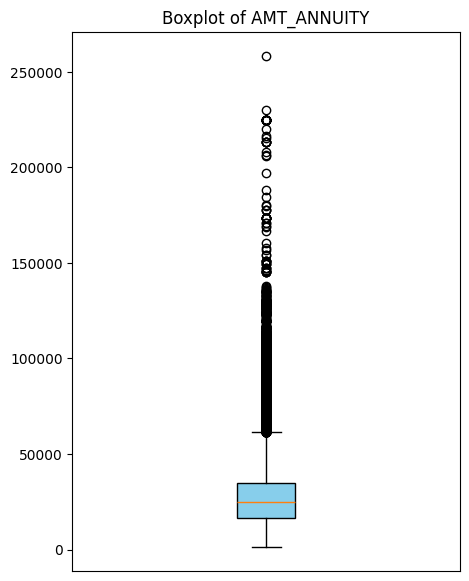

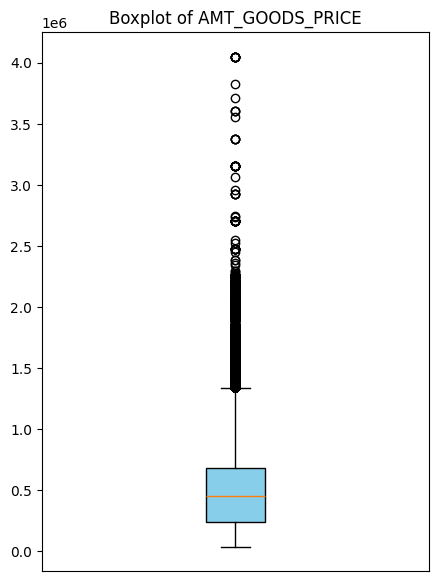

In [110]:
# Create individual boxplots
for feature in float_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

In [111]:
df.describe()[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']].loc[['mean', 'min', 'max']]

AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE
mean  587767.414    27425.561       528019.998
min    45000.000     1615.500        40500.000
max  4050000.000   258025.500      4050000.000

In [112]:
train.describe()[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']].loc[['mean', 'min', 'max']]

AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE
mean  599028.212    27108.512       538316.884
min    45000.000     1615.500        40500.000
max  4050000.000   258025.500      4050000.000

**Rule 1: AMT_ANNUITY should not exceed AMT_CREDIT**

In [113]:
train[train['AMT_ANNUITY'] > train['AMT_CREDIT']]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

**Rule 2: AMT_GOODS_PRICE should not exceed AMT_CREDIT**

In [114]:
train[train['AMT_GOODS_PRICE'] > train['AMT_CREDIT']]

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
724        100837      0    Revolving loans           F            N   
1942       102276      0    Revolving loans           M            Y   
2138       102512      0    Revolving loans           M            Y   
2808       103276      0    Revolving loans           M            N   
3769       104401      0    Revolving loans           M            Y   
...           ...    ...                ...         ...          ...   
304678     452992      0    Revolving loans           F            N   
304784     453120      0    Revolving loans           M            N   
305833     454341      0    Revolving loans           F            N   
306126     454683      0    Revolving loans           M            N   
306273     454852      0    Revolving loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
724                  Y             2         45000.000  135000.000   
1942                 Y             0        540000.000  315000.000   
2138                 Y             0        112500.000  135000.000   
2808                 Y             0        189000.000  337500.000   
3769                 Y             0        112500.000  135000.000   
...                ...           ...               ...         ...   
304678               Y             2         67500.000  202500.000   
304784               Y             1        112500.000  270000.000   
305833               Y             0        126000.000  270000.000   
306126               Y             0        135000.000  270000.000   
306273               Y             2         67500.000  202500.000   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
724        6750.000       450000.000   Unaccompanied  Commercial associate   
1942      15750.000       450000.000   Unaccompanied  Commercial associate   
2138       6750.000       202500.000   Unaccompanied               Working   
2808      16875.000       540000.000   Unaccompanied               Working   
3769       6750.000       382500.000   Unaccompanied  Commercial associate   
...             ...              ...             ...                   ...   
304678    10125.000       450000.000   Unaccompanied               Working   
304784    13500.000       450000.000   Unaccompanied               Working   
305833    13500.000       450000.000   Unaccompanied               Working   
306126    13500.000       450000.000   Unaccompanied  Commercial associate   
306273    10125.000       450000.000   Unaccompanied               Working   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
724     Secondary / secondary special               Married   
1942                 Higher education               Married   
2138    Secondary / secondary special               Married   
2808    Secondary / secondary special               Married   
3769    Secondary / secondary special               Married   
...                               ...                   ...   
304678               Higher education               Married   
304784  Secondary / secondary special               Married   
305833              Incomplete higher  Single / not married   
306126  Secondary / secondary special               Married   
306273               Higher education               Married   

          NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
724       House / apartment                       0.025      -10072   
1942      House / apartment                       0.073      -12613   
2138      House / apartment                       0.019      -13033   
2808      House / apartment                       0.017      -19293   
3769      House / apartment                       0.019      -17354   
...                     ...                         ...         ...   
304678    House / apartment                       0.025      -11313   
304784    House / apartment            

In [115]:
inconsistent_rows = train[train['AMT_GOODS_PRICE'] > train['AMT_CREDIT']]

In [116]:
inconsistent_rows['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Revolving loans    507
Name: count, dtype: int64

In [117]:
# Step 1: Flag the pattern
train['REVOLVING_GOODS_OVER_CREDIT'] = (
    (train['NAME_CONTRACT_TYPE'] == 'Revolving loans') & 
    (train['AMT_GOODS_PRICE'] > train['AMT_CREDIT'])
).astype(int)

test['REVOLVING_GOODS_OVER_CREDIT'] = (
    (test['NAME_CONTRACT_TYPE'] == 'Revolving loans') & 
    (test['AMT_GOODS_PRICE'] > test['AMT_CREDIT'])
).astype(int)

df['REVOLVING_GOODS_OVER_CREDIT'] = (
    (df['NAME_CONTRACT_TYPE'] == 'Revolving loans') & 
    (df['AMT_GOODS_PRICE'] > df['AMT_CREDIT'])
).astype(int)

In [118]:
# Step 2: Add a ratio feature
train['GOODS_CREDIT_RATIO'] = train['AMT_GOODS_PRICE'] / train['AMT_CREDIT']
test['GOODS_CREDIT_RATIO'] = test['AMT_GOODS_PRICE'] / test['AMT_CREDIT']
df['GOODS_CREDIT_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']

In [119]:
# Step 3: Optional capping (if values are errors)
train.loc[
    (train['NAME_CONTRACT_TYPE'] == 'Revolving loans') & 
    (train['AMT_GOODS_PRICE'] > train['AMT_CREDIT']),
    'AMT_GOODS_PRICE'
] = train['AMT_CREDIT']

test.loc[
    (test['NAME_CONTRACT_TYPE'] == 'Revolving loans') & 
    (test['AMT_GOODS_PRICE'] > test['AMT_CREDIT']),
    'AMT_GOODS_PRICE'
] = test['AMT_CREDIT']

df.loc[
    (df['NAME_CONTRACT_TYPE'] == 'Revolving loans') & 
    (df['AMT_GOODS_PRICE'] > df['AMT_CREDIT']),
    'AMT_GOODS_PRICE'
] = df['AMT_CREDIT']

In [120]:
train[train['AMT_GOODS_PRICE'] > train['AMT_CREDIT']]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

In [121]:
df[df['AMT_GOODS_PRICE'] > df['AMT_CREDIT']]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

**Rule 3: AMT_ANNUITY should be reasonable (e.g., < 30% of AMT_CREDIT)**

In [122]:
train['HIGH_ANNUITY_RATIO'] = (train['AMT_ANNUITY'] / train['AMT_CREDIT']) > 0.3
df['HIGH_ANNUITY_RATIO'] = (df['AMT_ANNUITY'] / df['AMT_CREDIT']) > 0.3

In [123]:
train[train['HIGH_ANNUITY_RATIO'] == True]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

In [124]:
df[df['HIGH_ANNUITY_RATIO'] == True]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

In [125]:
train = train.drop('HIGH_ANNUITY_RATIO', axis=1)
df = df.drop('HIGH_ANNUITY_RATIO', axis=1)

**Rule 4: Credit-to-Income Ratio (CTI)**

In [126]:
train['CTI_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['HIGH_CTI'] = train['CTI_RATIO'] > 20  # Flag if CTI > 20

test['CTI_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['HIGH_CTI'] = test['CTI_RATIO'] > 20  # Flag if CTI > 20

df['CTI_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['HIGH_CTI'] = df['CTI_RATIO'] > 20  # Flag if CTI > 20

In [127]:
train[train['HIGH_CTI'] == True]

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
678        100784      1         Cash loans           F            N   
1221       101442      0         Cash loans           F            N   
3000       103504      0         Cash loans           F            Y   
3836       104486      0         Cash loans           F            N   
4265       104990      0         Cash loans           F            N   
...           ...    ...                ...         ...          ...   
302944     450985      0         Cash loans           F            N   
303587     451741      0         Cash loans           F            N   
304814     453155      0         Cash loans           F            Y   
305573     454034      0         Cash loans           F            N   
307363     456088      1         Cash loans           F            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
678                  Y             0         54000.000 1885500.000   
1221                 N             0         36000.000  900000.000   
3000                 Y             0         56250.000 1288350.000   
3836                 N             0         45000.000 1097131.500   
4265                 Y             0         45000.000 1125000.000   
...                ...           ...               ...         ...   
302944               N             0         49500.000 1125000.000   
303587               N             0         34852.500  781920.000   
304814               Y             0         47250.000 1035832.500   
305573               Y             0         31500.000  675000.000   
307363               Y             0         29250.000  663093.000   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE NAME_INCOME_TYPE  \
678       74191.500      1885500.000    Unaccompanied        Pensioner   
1221      26311.500       900000.000    Unaccompanied        Pensioner   
3000      37800.000      1125000.000    Unaccompanied        Pensioner   
3836      43510.500       886500.000           Family        Pensioner   
4265      33025.500      1125000.000           Family    State servant   
...             ...              ...              ...              ...   
302944    33025.500      1125000.000    Unaccompanied        Pensioner   
303587    23836.500       675000.000    Unaccompanied        Pensioner   
304814    33543.000       904500.000  Spouse, partner        Pensioner   
305573    21775.500       675000.000           Family        Pensioner   
307363    21519.000       553500.000    Unaccompanied        Pensioner   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
678     Secondary / secondary special            Married    House / apartment   
1221    Secondary / secondary special            Married    House / apartment   
3000    Secondary / secondary special            Married    House / apartment   
3836    Secondary / secondary special            Married    House / apartment   
4265    Secondary / secondary special            Married  Municipal apartment   
...                               ...                ...                  ...   
302944  Secondary / secondary special            Married    House / apartment   
303587  Secondary / secondary special          Separated    House / apartment   
304814  Secondary / secondary special            Married    House / apartment   
305573  Secondary / secondary special            Married    House / apartment   
307363  Secondary / secondary special            Married    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
678                          0.031      -22181         365243   
1221                         0.019      -20395         365243   
3000                         0.010      -22449         365243   
3836                         0.036      -21465         365243   
4265                         0.009      -17590          -7642   
...                            ...         ...   

In [128]:
high_cti = train[train['HIGH_CTI']]
high_cti[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'CTI_RATIO']].describe()

AMT_INCOME_TOTAL  AMT_CREDIT  CTI_RATIO
count           235.000     235.000    235.000
mean          49865.591 1203445.245     24.477
std           16209.293  401263.393      5.632
min           25650.000  571500.000     20.005
25%           36000.000  896022.000     21.451
50%           46044.000 1125000.000     22.904
75%           58500.000 1443948.750     25.656
max          103500.000 2517300.000     84.737

In [129]:
high_cti['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans    235
Name: count, dtype: int64

In [130]:
high_cti['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Pensioner               148
Working                  59
State servant            11
Commercial associate     11
Unemployed                5
Maternity leave           1
Name: count, dtype: int64

In [131]:
high_cti['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Unknown                  167
Laborers                  18
Sales staff               13
Core staff                 7
Medicine staff             6
Managers                   5
Security staff             4
Accountants                4
Cleaning staff             3
Cooking staff              2
Drivers                    2
High skill tech staff      2
Low-skill Laborers         1
Waiters/barmen staff       1
Name: count, dtype: int64

In [132]:
train['HIGH_CTI_RISK'] = (train['CTI_RATIO'] > 20).astype(int)
test['HIGH_CTI_RISK'] = (test['CTI_RATIO'] > 20).astype(int)
df['HIGH_CTI_RISK'] = (df['CTI_RATIO'] > 20).astype(int)

In [133]:
if 'TARGET' in train.columns:
    print(train.groupby('HIGH_CTI')['TARGET'].mean())

HIGH_CTI
False   0.081
True    0.098
Name: TARGET, dtype: object


HIGH_CTI has a higher default rate (True == 1) it means the flag is somewhat predictive.

**Rule 5: Annuity-to-Income Ratio**

In [134]:
train['ATI_RATIO'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['HIGH_ATI'] = train['ATI_RATIO'] > 0.5  # Flag if ATI > 50%

test['ATI_RATIO'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['HIGH_ATI'] = test['ATI_RATIO'] > 0.5  # Flag if ATI > 50%

df['ATI_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['HIGH_ATI'] = df['ATI_RATIO'] > 0.5  # Flag if ATI > 50%

In [135]:
train[train['HIGH_ATI'] == True]

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
678        100784      1         Cash loans           F            N   
733        100846      0         Cash loans           F            N   
779        100893      0         Cash loans           F            N   
875        101004      0         Cash loans           F            Y   
925        101068      0         Cash loans           F            Y   
...           ...    ...                ...         ...          ...   
307131     455827      0         Cash loans           F            Y   
307207     455915      0         Cash loans           F            N   
307363     456088      1         Cash loans           F            Y   
307405     456138      0         Cash loans           M            N   
307443     456181      0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
678                  Y             0         54000.000 1885500.000   
733                  N             0         58500.000  888840.000   
779                  Y             0         90000.000  701730.000   
875                  Y             1        112500.000 1215000.000   
925                  Y             2         67500.000  900000.000   
...                ...           ...               ...         ...   
307131               N             2         45000.000  675000.000   
307207               Y             0         36000.000  225000.000   
307363               Y             0         29250.000  663093.000   
307405               Y             0         49500.000  432661.500   
307443               N             0         76500.000 1240614.000   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
678       74191.500      1885500.000   Unaccompanied             Pensioner   
733       29506.500       675000.000   Unaccompanied             Pensioner   
779       68490.000       675000.000        Children               Working   
875       84694.500      1215000.000   Unaccompanied  Commercial associate   
925       35824.500       900000.000   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307131    28597.500       675000.000   Unaccompanied               Working   
307207    20952.000       225000.000   Unaccompanied               Working   
307363    21519.000       553500.000   Unaccompanied             Pensioner   
307405    26419.500       373500.000   Unaccompanied             Pensioner   
307443    44559.000      1111500.000   Unaccompanied             Pensioner   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
678     Secondary / secondary special            Married  House / apartment   
733     Secondary / secondary special              Widow  House / apartment   
779                  Higher education            Married  House / apartment   
875     Secondary / secondary special            Married  House / apartment   
925     Secondary / secondary special            Married  House / apartment   
...                               ...                ...                ...   
307131               Higher education            Married  House / apartment   
307207  Secondary / secondary special            Married  House / apartment   
307363  Secondary / secondary special            Married  House / apartment   
307405  Secondary / secondary special            Married  House / apartment   
307443  Secondary / secondary special            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
678                          0.031      -22181         365243   
733                          0.023      -23491         365243   
779                          0.026      -16419          -3300   
875                          0.005      -15044           -197   
925                          0.029      -14300          -1264   
...                      

In [136]:
train['HIGH_ATI_RISK'] = (train['ATI_RATIO'] > 0.5).astype(int)
test['HIGH_ATI_RISK'] = (test['ATI_RATIO'] > 0.5).astype(int)
df['HIGH_ATI_RISK'] = (df['ATI_RATIO'] > 0.5).astype(int)

In [137]:
if 'TARGET' in train.columns:
    print("Default rate for HIGH_ATI vs Others:")
    print(train.groupby('HIGH_ATI')['TARGET'].mean())

Default rate for HIGH_ATI vs Others:
HIGH_ATI
False   0.081
True    0.075
Name: TARGET, dtype: object


Non-High-ATI Applicants (HIGH_ATI=False): Default rate = 8.1%  
High-ATI Applicants (HIGH_ATI=True): Default rate = 7.5%  

This is counterintuitive, we'd expect higher default rates for those spending >50% of income on loan repayments.

Keep the High-ATI Flag: Despite the lower default rate, it may interact with other features (e.g., loan type).

**Rule 6: Goods Price-to-Income Ratio**

In [138]:
train['GTI_RATIO'] = train['AMT_GOODS_PRICE'] / train['AMT_INCOME_TOTAL']
train['HIGH_GTI'] = train['GTI_RATIO'] > 25  # Flag if GTI > 25

test['GTI_RATIO'] = test['AMT_GOODS_PRICE'] / test['AMT_INCOME_TOTAL']
test['HIGH_GTI'] = test['GTI_RATIO'] > 25  # Flag if GTI > 25

df['GTI_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
df['HIGH_GTI'] = df['GTI_RATIO'] > 25  # Flag if GTI > 25

In [139]:
train[train['HIGH_GTI'] == True].shape

(38, 140)

In [140]:
train['HIGH_GTI_RISK'] = (train['GTI_RATIO'] > 25).astype(int)
test['HIGH_GTI_RISK'] = (test['GTI_RATIO'] > 25).astype(int)
df['HIGH_GTI_RISK'] = (df['GTI_RATIO'] > 25).astype(int)

In [141]:
if 'TARGET' in train.columns:
    print("Default rate for HIGH_GTI vs Others:")
    print(train.groupby('HIGH_GTI')['TARGET'].mean())

Default rate for HIGH_GTI vs Others:
HIGH_GTI
False   0.081
True    0.289
Name: TARGET, dtype: object


HIGH_GTI has a higher default rate (True == 1) it means the flag is predictive.

### DAYS_BIRTH

#### AGE_YEARS

In [142]:
# Convert DAYS_BIRTH to age in years
train['AGE_YEARS'] = abs(train['DAYS_BIRTH']) / 365.25
test['AGE_YEARS'] = abs(test['DAYS_BIRTH']) / 365.25
df['AGE_YEARS'] = abs(df['DAYS_BIRTH']) / 365.25

In [143]:
train['AGE_YEARS'].describe()

count   307501.000
mean        43.907
std         11.948
min         20.504
25%         33.985
50%         43.121
75%         53.886
max         69.073
Name: AGE_YEARS, dtype: float64

In [144]:
df['AGE_YEARS'].describe()

count   356255.000
mean        43.919
std         11.934
min         20.090
25%         34.018
50%         43.135
75%         53.870
max         69.073
Name: AGE_YEARS, dtype: float64

### OWN_CAR_AGE

In [145]:
train["OWN_CAR_AGE"].describe()

count   307501.000
mean         4.102
std          9.010
min          0.000
25%          0.000
50%          0.000
75%          5.000
max         91.000
Name: OWN_CAR_AGE, dtype: float64

In [146]:
df["OWN_CAR_AGE"].describe()

count   356255.000
mean         4.084
std          8.965
min          0.000
25%          0.000
50%          0.000
75%          5.000
max         91.000
Name: OWN_CAR_AGE, dtype: float64

Impossible Values (Negative or Too High)
- Negative values: Invalid (cars can’t have negative age).
- Cars older than 50-60 years: Likely data errors (classic cars are rare in loan datasets).

In [147]:
# Check for extremely old cars (e.g., > 50 years)
old_cars = train[train['OWN_CAR_AGE'] > 50]
print("Cars older than 50 years:", len(old_cars))

Cars older than 50 years: 3361


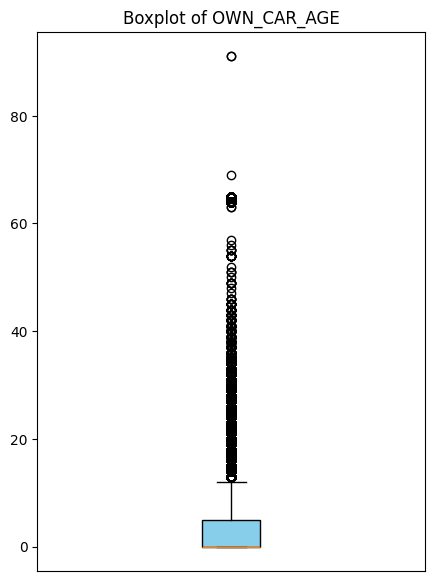

In [148]:
plt.figure(figsize=(5, 7))
plt.boxplot(train['OWN_CAR_AGE'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.title("Boxplot of OWN_CAR_AGE")
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.show()

In [149]:
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].clip(upper=60)
test['OWN_CAR_AGE'] = test['OWN_CAR_AGE'].clip(upper=60)

In [150]:
train["OWN_CAR_AGE"].describe()

count   307501.000
mean         4.055
std          8.704
min          0.000
25%          0.000
50%          0.000
75%          5.000
max         60.000
Name: OWN_CAR_AGE, dtype: float64

### CNT_CHILDREN, CNT_FAM_MEMBERS

In [151]:
train[["CNT_CHILDREN", "CNT_FAM_MEMBERS",]].describe()

CNT_CHILDREN  CNT_FAM_MEMBERS
count    307501.000       307501.000
mean          0.417            2.153
std           0.722            0.911
min           0.000            1.000
25%           0.000            2.000
50%           0.000            2.000
75%           1.000            3.000
max          19.000           20.000

Check if CNT_FAM_MEMBERS ≥ CNT_CHILDREN + 1 (at least 1 adult per family):

In [152]:
invalid_families = train[train['CNT_FAM_MEMBERS'] < (train['CNT_CHILDREN'] + 1)]
print(f"Invalid family records: {len(invalid_families)}")

Invalid family records: 0


In [153]:
invalid_families = df[df['CNT_FAM_MEMBERS'] < (df['CNT_CHILDREN'] + 1)]
print(f"Invalid family records: {len(invalid_families)}")

Invalid family records: 0


### OBS_30_CNT_SOCIAL_CIRCLE

In [154]:
float_features = [
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_QRT"
]

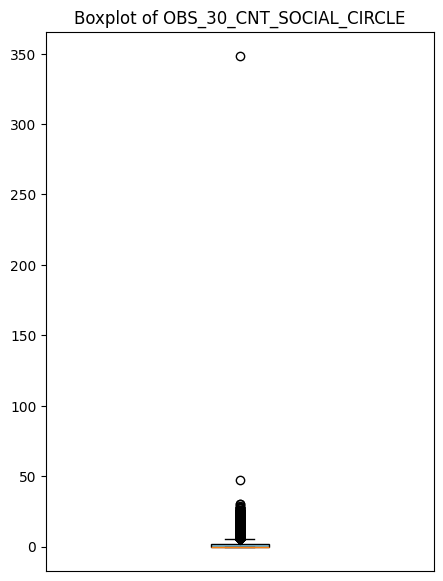

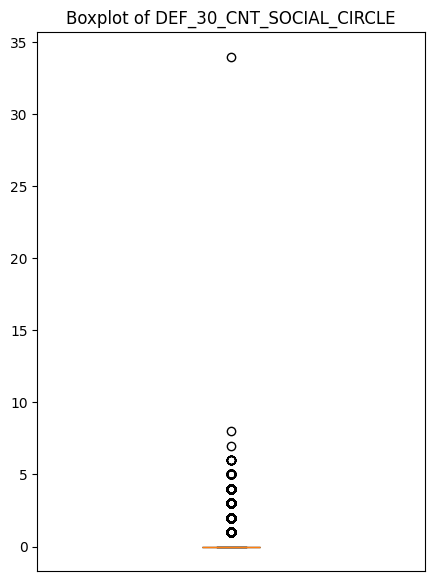

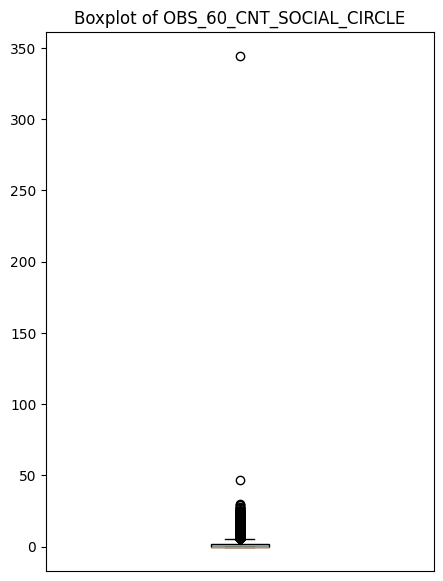

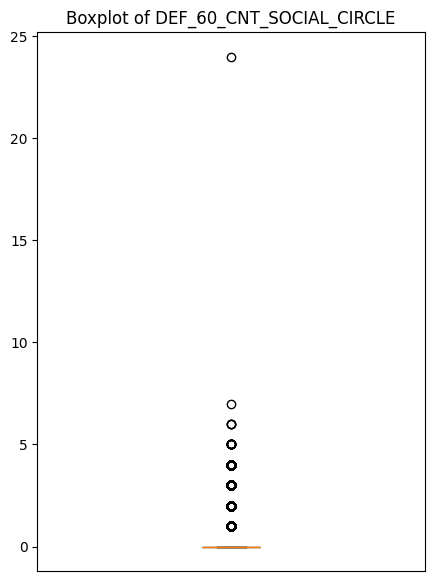

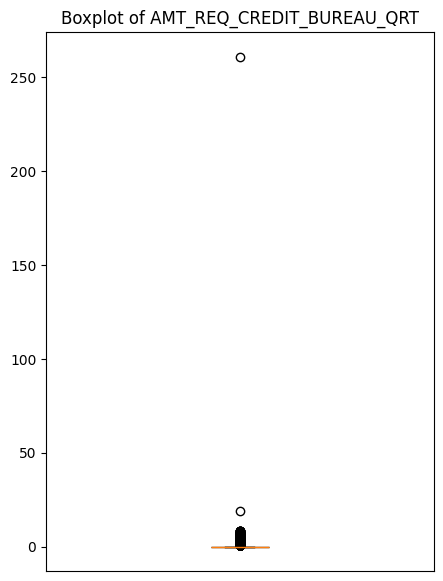

In [155]:
# Create individual boxplots
for feature in float_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

In [156]:
train[train['OBS_30_CNT_SOCIAL_CIRCLE'] > 40]

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
77497      189856      0         Cash loans           M            Y   
148403     272071      0    Revolving loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
77497                Y             1        157500.000  296280.000   
148403               Y             0        202500.000  180000.000   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
77497     23539.500       225000.000          Family          Working   
148403     9000.000       180000.000          Family    State servant   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
77497   Secondary / secondary special               Married   
148403               Higher education  Single / not married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
77497   House / apartment                       0.010      -14767   
148403  House / apartment                       0.020      -10111   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
77497           -2767         -13306.000            -4720       11.000   
148403          -1917          -2306.000            -2306        0.000   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
77497            1               1                0                 1   
148403           1               1                0                 1   

        FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
77497            0           1        Laborers            3.000   
148403           0           0      Core staff            1.000   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
77497                      2                            2   
148403                     3                            3   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
77497                      MONDAY                       17   
148403                   THURSDAY                        9   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
77497                            0                           0   
148403                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
77497                             0                       0   
148403                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  \
77497                        0                        0  Industry: type 4   
148403                       1                        1            Police   

        EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  \
77497          0.460         0.399         0.750           0.222   
148403         0.361         0.305         0.357        -999.000   

        BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  \
77497              0.174                        0.982         -999.000   
148403             0.031                        0.987            0.816   

        COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
77497         -999.000          0.240          0.207          0.333   
148403        -999.000          0.120          0.035          0.333   

        FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
77497        -999.000         0.110              -999.000           0.262   
148403          0.375      -999.000                 0.030           0.024   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
77497                  -999.000           -999.000            0.226   
148403                 -999.000           -999.000         -999.000   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
77497               0.181                         0.982          -999.000   
148403              0.032                         0.987             0.824   

    

In [157]:
train = train[train['OBS_30_CNT_SOCIAL_CIRCLE'] <= 40]
test = test[test['OBS_30_CNT_SOCIAL_CIRCLE'] <= 40]

In [158]:
train[train['OBS_30_CNT_SOCIAL_CIRCLE'] > 40]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

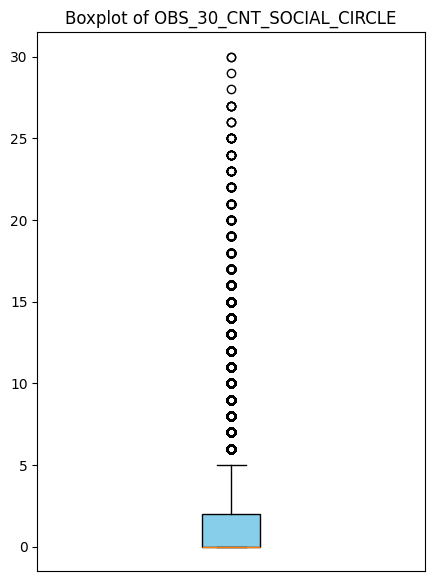

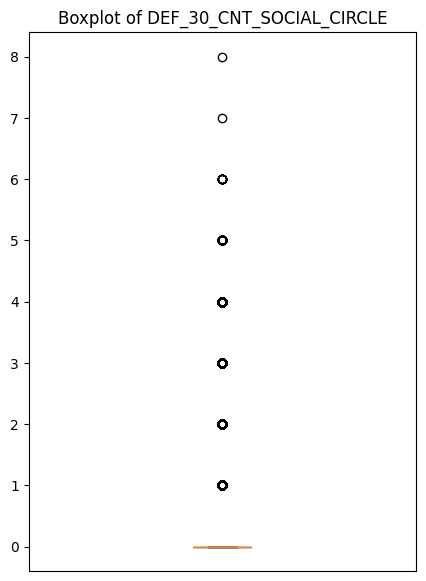

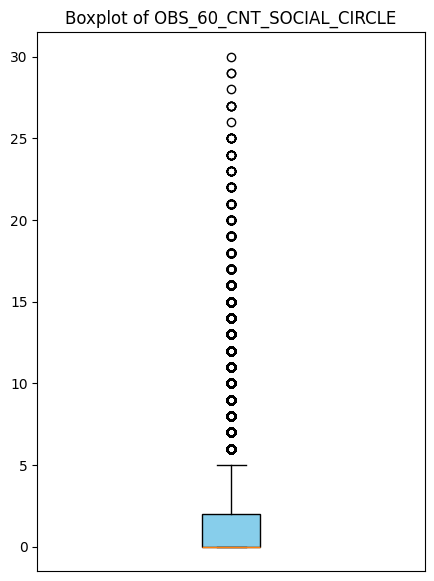

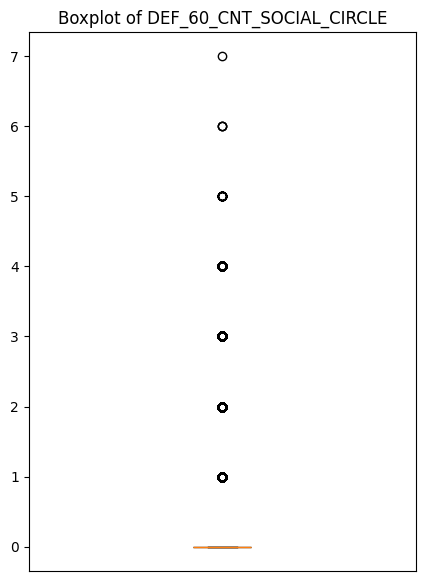

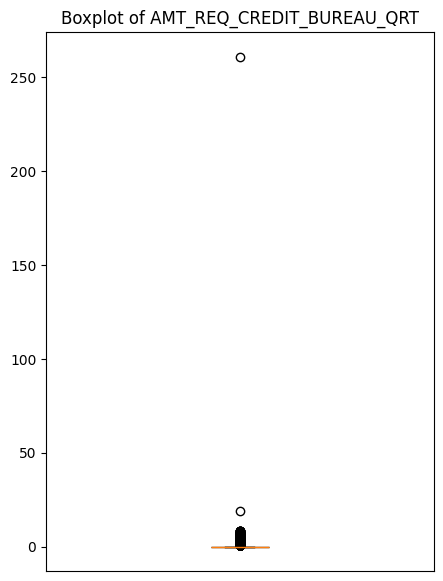

In [159]:
# Create individual boxplots
for feature in float_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

### AMT_REQ_CREDIT_BUREAU_QRT

In [160]:
train['AMT_REQ_CREDIT_BUREAU_QRT'].describe()

count   307499.000
mean         0.230
std          0.744
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        261.000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

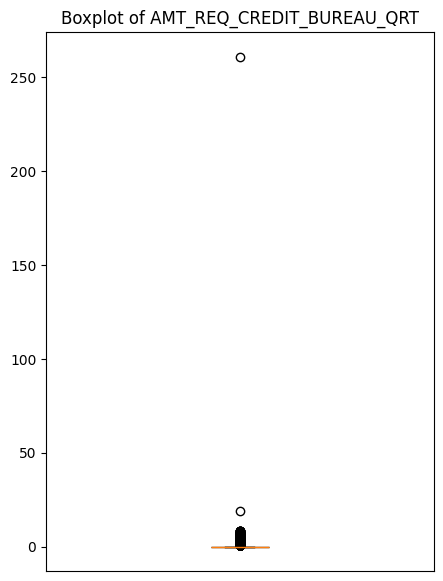

In [161]:
plt.figure(figsize=(5, 7))
plt.boxplot(train['AMT_REQ_CREDIT_BUREAU_QRT'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.title("Boxplot of AMT_REQ_CREDIT_BUREAU_QRT")
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.show()

In [162]:
train[train['AMT_REQ_CREDIT_BUREAU_QRT'] > 10]['AMT_REQ_CREDIT_BUREAU_QRT']

239474   261.000
253541    19.000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

In [163]:
# Manual Cap
cap_value = 10

In [164]:
train['AMT_REQ_CREDIT_BUREAU_QRT'] = np.where(
    train['AMT_REQ_CREDIT_BUREAU_QRT'] > cap_value, 
    cap_value, 
    train['AMT_REQ_CREDIT_BUREAU_QRT']
)

test['AMT_REQ_CREDIT_BUREAU_QRT'] = np.where(
    test['AMT_REQ_CREDIT_BUREAU_QRT'] > cap_value, 
    cap_value, 
    test['AMT_REQ_CREDIT_BUREAU_QRT']
)

In [165]:
train[train['AMT_REQ_CREDIT_BUREAU_QRT'] > 10]['AMT_REQ_CREDIT_BUREAU_QRT']

Series([], Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64)

**Verify Again**

In [166]:
float_features = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "DAYS_EMPLOYED",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_QRT"
]

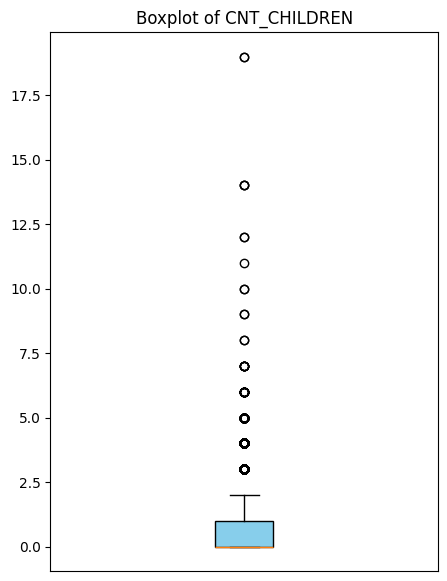

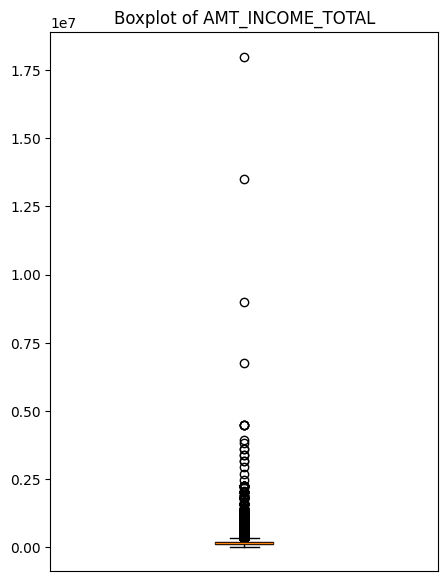

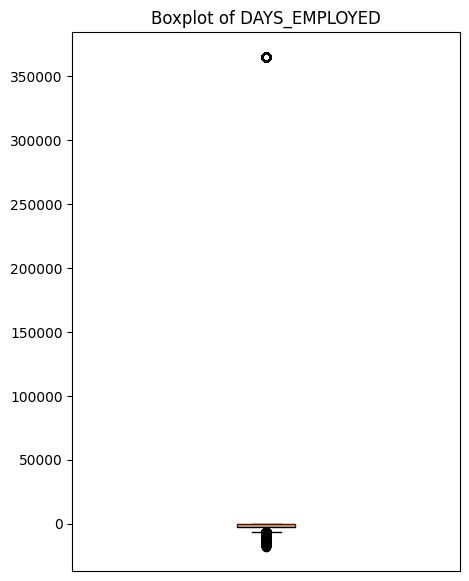

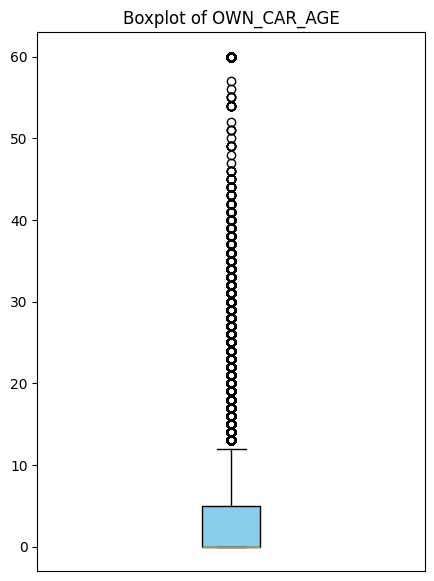

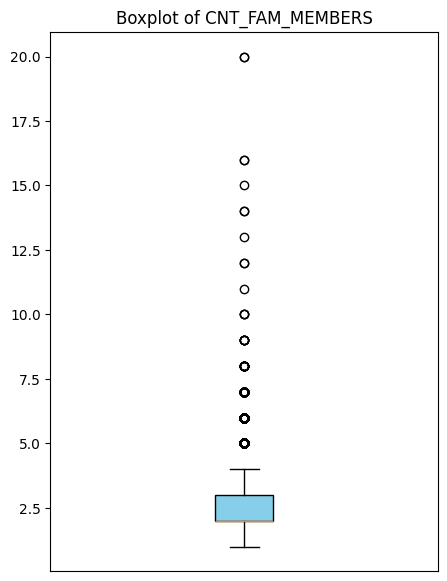

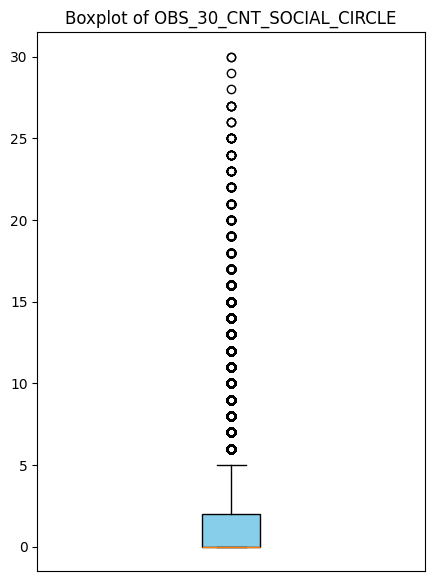

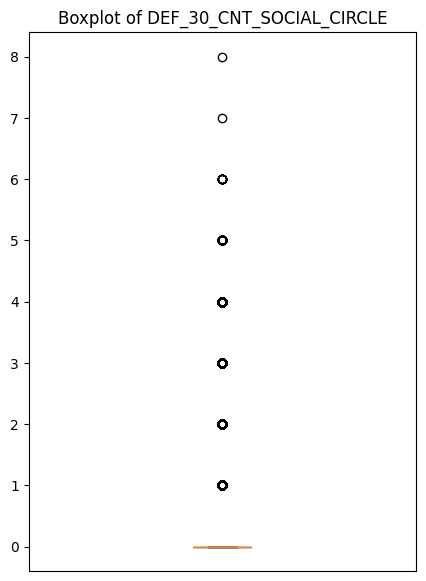

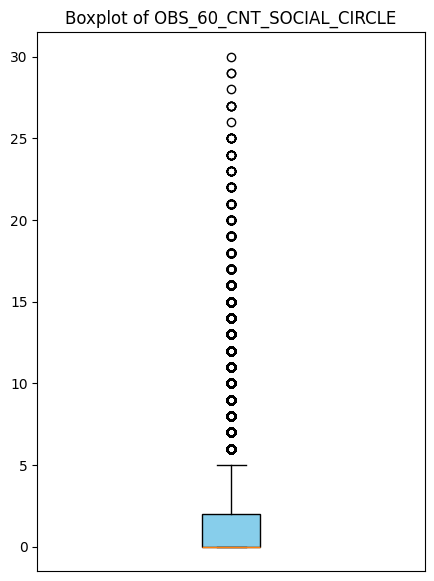

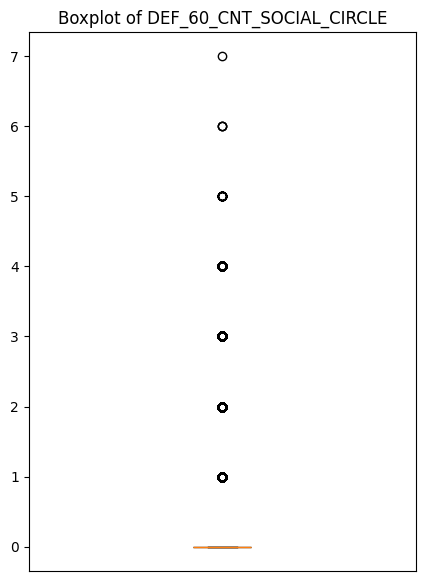

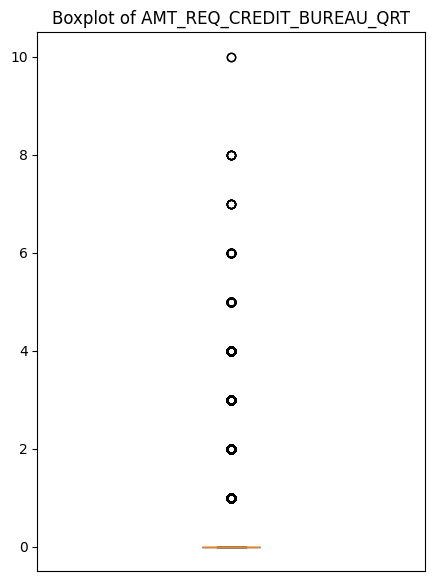

In [167]:
# Create individual boxplots
for feature in float_features:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

## Handling Skewness

Skewness Interpretation
- 0 to ±0.5 → Nearly symmetric (No transformation needed)
- ±0.5 to ±1.0 → Moderately skewed (Mild transformation)
- \>±1.0 → Strongly skewed (Stronger transformation required)

**Exclude the Binary Features**

In [168]:
# Filter numeric columns first
numeric_cols = train.select_dtypes(include='number')

In [169]:
# Drop binary columns (only two unique values)
non_binary_cols = [col for col in numeric_cols.columns if train[col].nunique() > 2]

In [170]:
# Compute skew only for non-binary numeric columns
skewed = train[non_binary_cols].skew().sort_values(ascending=True)
print(skewed)

YEARS_EMPLOYED               -1.664
EXT_SOURCE_2                 -0.796
DAYS_LAST_PHONE_CHANGE       -0.714
DAYS_REGISTRATION            -0.591
EXT_SOURCE_3                 -0.538
                              ...  
AMT_REQ_CREDIT_BUREAU_MON     8.371
AMT_REQ_CREDIT_BUREAU_WEEK   10.009
AMT_REQ_CREDIT_BUREAU_HOUR   15.642
AMT_INCOME_TOTAL             26.978
AMT_REQ_CREDIT_BUREAU_DAY    29.081
Length: 78, dtype: float64


While skewness transformations can improve the performance of some machine learning models, they are generally less critical for tree-based models like DecisionTree, RandomForest, LightGBM, and XGBoost.

# Data Visualization

## Target Distribution

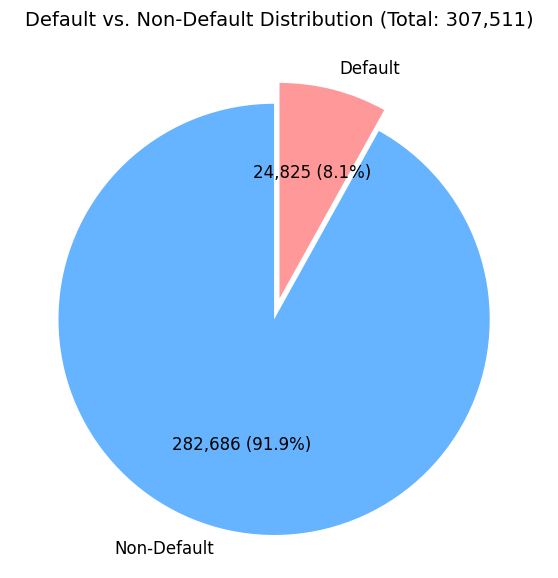

In [171]:
# Calculate the frequency of each class
target_counts = df['TARGET'].value_counts()

colors = ['#66b3ff', '#ff9999']

# Exploding the largest segment for emphasis
explode = [0.1 if i == target_counts.idxmax() else 0 for i in target_counts.index]

# Map the target values (1, 0) to their respective labels
label_map = {1: 'Default', 0: 'Non-Default'}

# Function to format the autopct with both number and percentage
def func(pct, allvalues):
    absolute = round(pct / 100. * sum(allvalues))
    return f"{absolute:,} ({pct:.1f}%)"

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    target_counts,
    labels=[label_map[i] for i in target_counts.index],
    autopct=lambda pct: func(pct, target_counts),
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'none'},
    textprops={'fontsize': 12}
)

plt.title(f'Default vs. Non-Default Distribution (Total: {target_counts.sum():,})', fontsize=14, pad=0)
plt.show()

## Categorical Data vs Target

In [172]:
train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 307499 entries, 0 to 307510
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   SK_ID_CURR                  307499 non-null  object
 1   TARGET                      307499 non-null  object
 2   NAME_CONTRACT_TYPE          307499 non-null  object
 3   CODE_GENDER                 307499 non-null  object
 4   FLAG_OWN_CAR                307499 non-null  object
 5   FLAG_OWN_REALTY             307499 non-null  object
 6   NAME_TYPE_SUITE             307499 non-null  object
 7   NAME_INCOME_TYPE            307499 non-null  object
 8   NAME_EDUCATION_TYPE         307499 non-null  object
 9   NAME_FAMILY_STATUS          307499 non-null  object
 10  NAME_HOUSING_TYPE           307499 non-null  object
 11  OCCUPATION_TYPE             307499 non-null  object
 12  WEEKDAY_APPR_PROCESS_START  307499 non-null  object
 13  ORGANIZATION_TYPE           307499

In [173]:
def prop_agg(train, y, x):
  temp_train = train.groupby([y,x], as_index = False).size()
  temp_train['prop'] = temp_train['size'] / temp_train.groupby(y)['size'].transform('sum')
  return temp_train

In [174]:
prop_agg(train, "NAME_CONTRACT_TYPE", "TARGET")

NAME_CONTRACT_TYPE  TARGET    size  prop
0         Cash loans       0  255010 0.917
1         Cash loans       1   23220 0.083
2    Revolving loans       0   27665 0.945
3    Revolving loans       1    1604 0.055

**NAME_CONTRACT_TYPE vs TARGET**

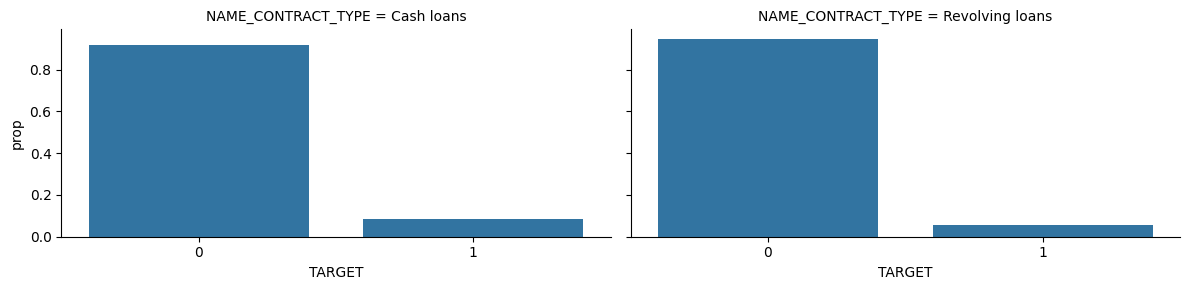

In [175]:
g = sns.FacetGrid(
    data = prop_agg(train, "NAME_CONTRACT_TYPE", "TARGET"),
    col = "NAME_CONTRACT_TYPE",
    aspect = 2
)
g.map(sns.barplot, "TARGET", "prop");

Applicants with contract type Cash loans show slightly higher churn than Revolving loans. The difference is small, but it suggests that NAME_CONTRACT_TYPE has a moderate predictive effect on churn.

**CODE_GENDER vs TARGET**

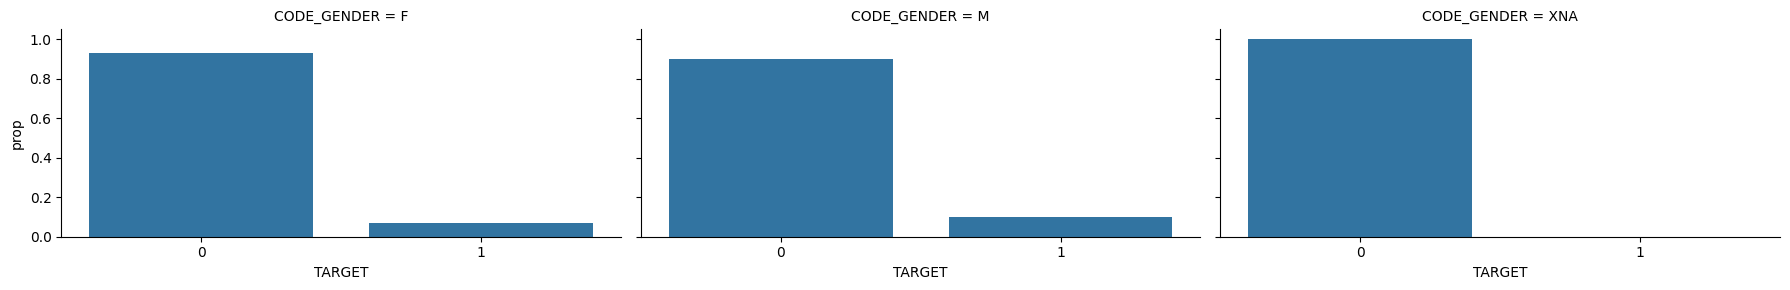

In [176]:
g = sns.FacetGrid(
    data = prop_agg(train, "CODE_GENDER", "TARGET"),
    col = "CODE_GENDER",
    aspect = 2
)
g.map(sns.barplot, "TARGET", "prop");

Male applicants have higher churn than females, indicating that CODE_GENDER also has a moderate predictive effect.

**NAME_TYPE_SUITE vs TARGET**

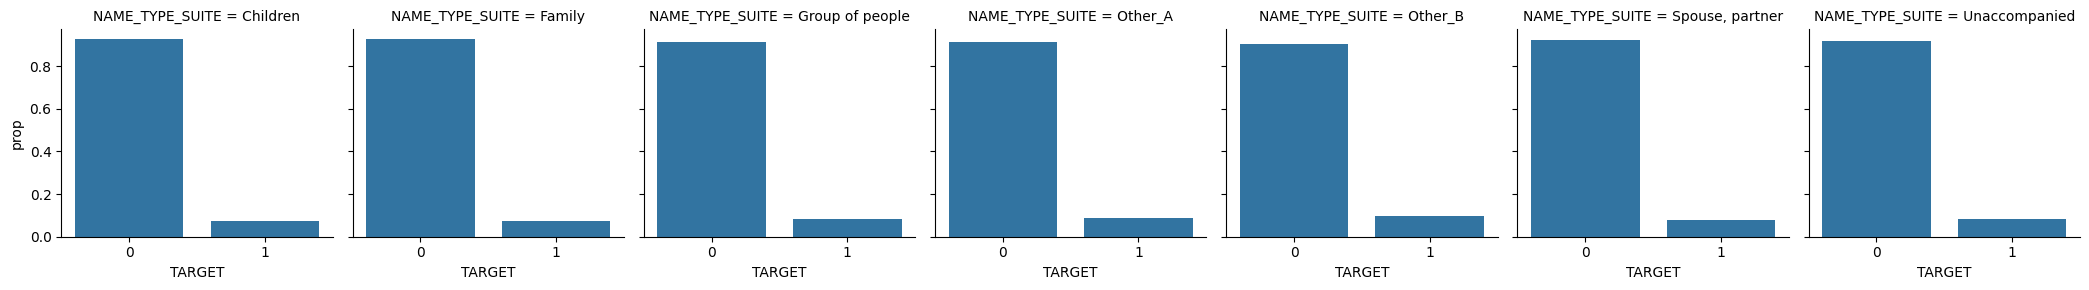

In [177]:
g = sns.FacetGrid(
    data = prop_agg(train, "NAME_TYPE_SUITE", "TARGET"),
    col = "NAME_TYPE_SUITE"
)
g.map(sns.barplot, "TARGET", "prop");

For NAME_TYPE_SUITE, churn and non-churn proportions are similar, making it a weak predictor.

**NAME_INCOME_TYPE vs TARGET**

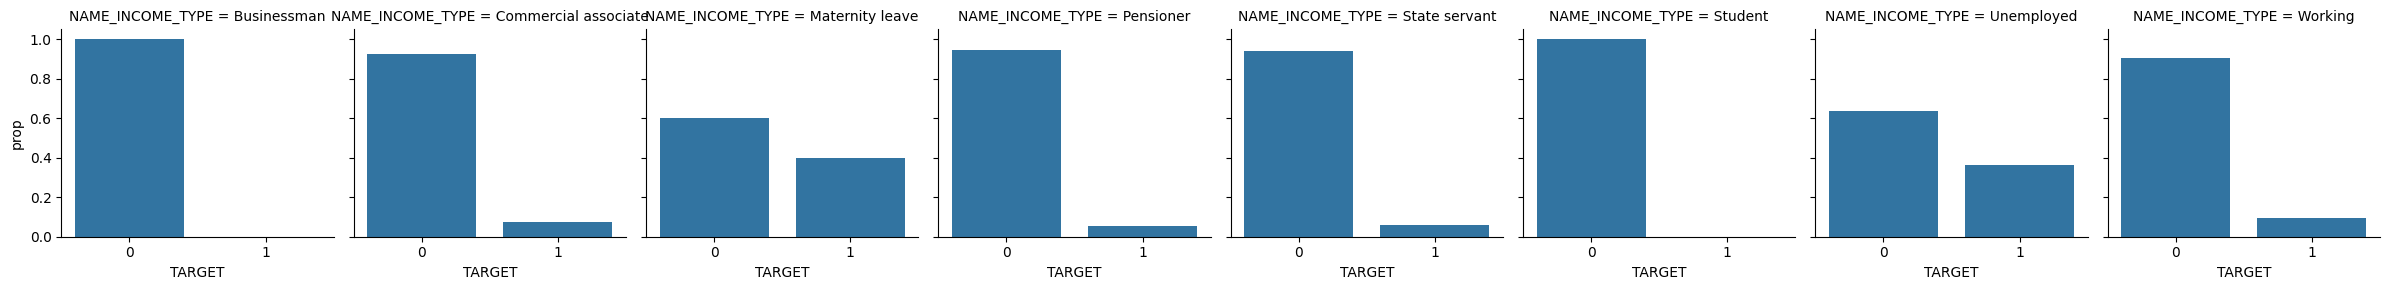

In [178]:
g = sns.FacetGrid(
    data = prop_agg(train, "NAME_INCOME_TYPE", "TARGET"),
    col = "NAME_INCOME_TYPE"
)
g.map(sns.barplot, "TARGET", "prop");

In NAME_INCOME_TYPE, churn rates fluctuate across categories due to uneven distribution, so it is considered a weak predictor.

In [179]:
train['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 158770
Commercial associate     71616
Pensioner                55358
State servant            21700
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

**NAME_EDUCATION_TYPE vs TARGET**

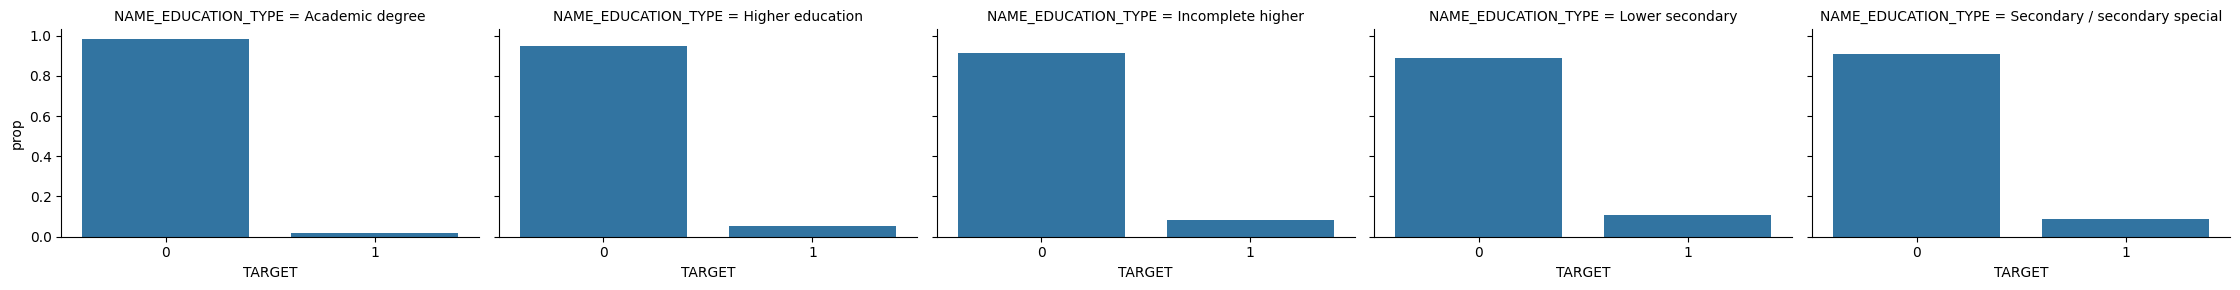

In [180]:
g = sns.FacetGrid(
    data = prop_agg(train, "NAME_EDUCATION_TYPE", "TARGET"),
    col = "NAME_EDUCATION_TYPE",
    aspect = 1.5
)
g.map(sns.barplot, "TARGET", "prop");

The same applies to NAME_EDUCATION_TYPE: churn patterns are inconsistent across categories, suggesting weak predictive power.

In [181]:
train['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    218383
Higher education                  74860
Incomplete higher                 10277
Lower secondary                    3815
Academic degree                     164
Name: count, dtype: int64

**NAME_FAMILY_STATUS vs TARGET**

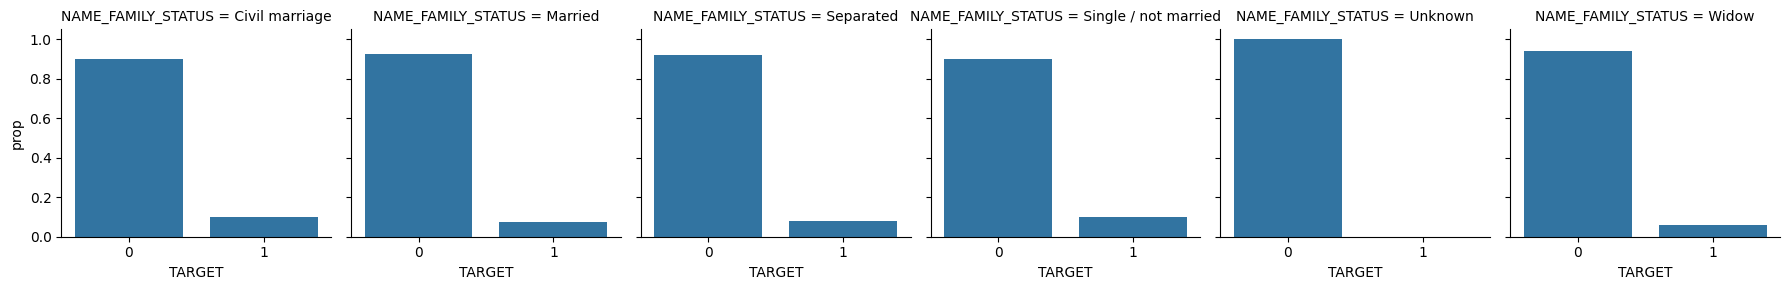

In [182]:
g = sns.FacetGrid(
    data = prop_agg(train, "NAME_FAMILY_STATUS", "TARGET"),
    col = "NAME_FAMILY_STATUS"
)
g.map(sns.barplot, "TARGET", "prop");

NAME_FAMILY_STATUS shows nearly equal churn and non-churn distribution across categories, so it is a weak predictor.

In [183]:
train['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196426
Single / not married     45439
Civil marriage           29775
Separated                19770
Widow                    16087
Unknown                      2
Name: count, dtype: int64

**NAME_HOUSING_TYPE vs TARGET**

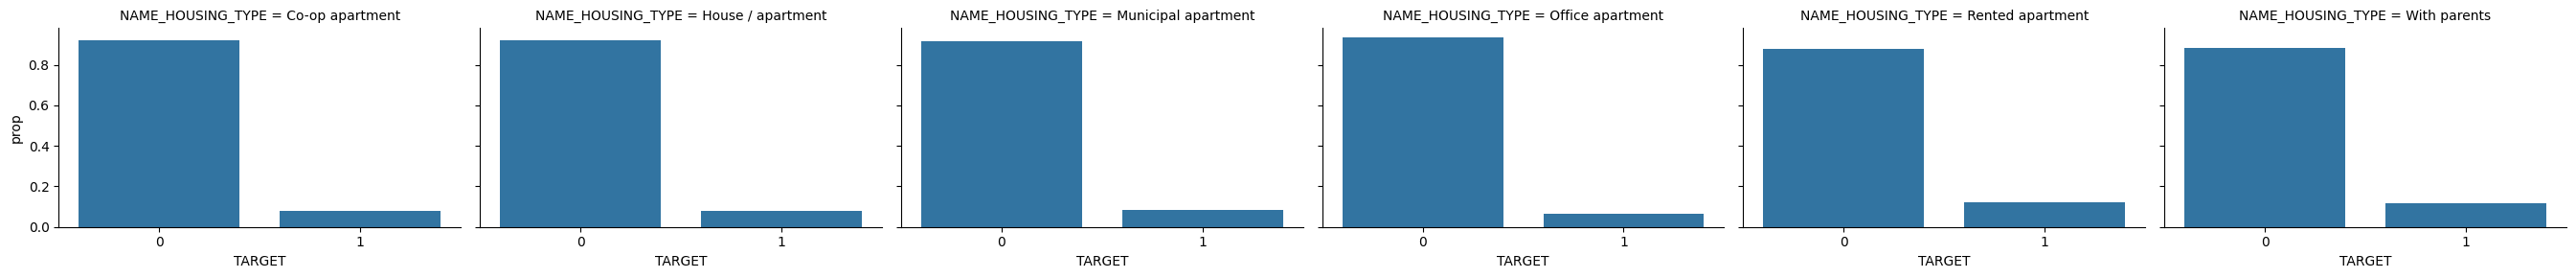

In [184]:
g = sns.FacetGrid(
    data = prop_agg(train, "NAME_HOUSING_TYPE", "TARGET"),
    col = "NAME_HOUSING_TYPE",
    aspect = 1.5
)
g.map(sns.barplot, "TARGET", "prop");

For NAME_HOUSING_TYPE, applicants renting apartments or living with parents have higher churn, indicating moderate predictive power.

In [185]:
train['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      272859
With parents            14839
Municipal apartment     11182
Rented apartment         4880
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

**OCCUPATION_TYPE vs TARGET**

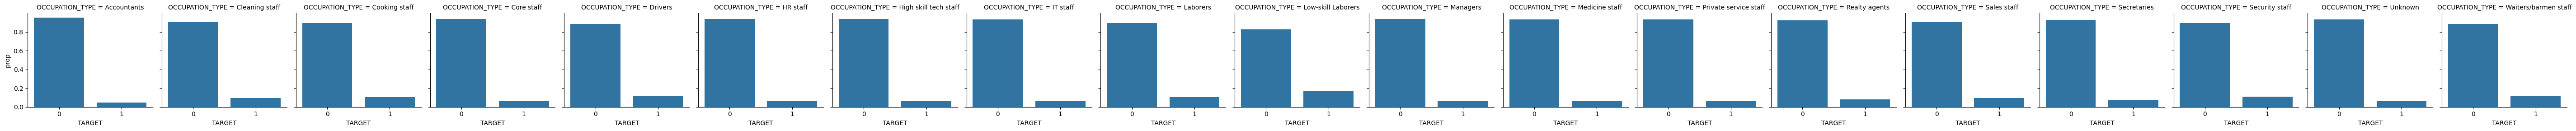

In [186]:
g = sns.FacetGrid(
    data = prop_agg(train, "OCCUPATION_TYPE", "TARGET"),
    col = "OCCUPATION_TYPE"
)
g.map(sns.barplot, "TARGET", "prop");

In OCCUPATION_TYPE, Low-skill Laborers show higher churn, and proportions vary across occupations. This makes it a moderate predictor.

In [187]:
train['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Unknown                  96382
Laborers                 55184
Sales staff              32102
Core staff               27569
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

## Numerical Data vs Target

In [188]:
# Select numeric columns
numeric_df = train.select_dtypes(include='number')

# Exclude binary columns (columns with exactly 2 unique values)
non_binary_df = numeric_df.loc[:, numeric_df.nunique() > 2]

# Display info
non_binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307499 entries, 0 to 307510
Data columns (total 78 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CNT_CHILDREN                  307499 non-null  int64  
 1   AMT_INCOME_TOTAL              307499 non-null  float64
 2   AMT_CREDIT                    307499 non-null  float64
 3   AMT_ANNUITY                   307499 non-null  float64
 4   AMT_GOODS_PRICE               307499 non-null  float64
 5   REGION_POPULATION_RELATIVE    307499 non-null  float64
 6   DAYS_BIRTH                    307499 non-null  int64  
 7   DAYS_EMPLOYED                 307499 non-null  int64  
 8   DAYS_REGISTRATION             307499 non-null  float64
 9   DAYS_ID_PUBLISH               307499 non-null  int64  
 10  OWN_CAR_AGE                   307499 non-null  float64
 11  CNT_FAM_MEMBERS               307499 non-null  float64
 12  REGION_RATING_CLIENT          307499 non-null  in

**AMT_INCOME_TOTAL vs TARGET**

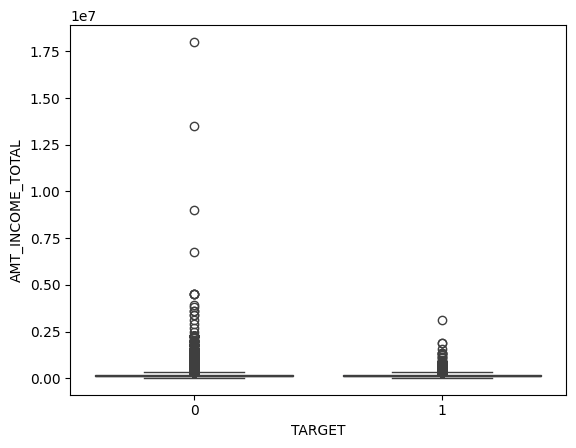

In [189]:
sns.boxplot(x = "TARGET", y = "AMT_INCOME_TOTAL", data = train);

In AMT_INCOME_TOTAL, applicants with lower income tend to churn, suggesting it is a moderate to strong predictor.

**AMT_CREDIT vs TARGET**

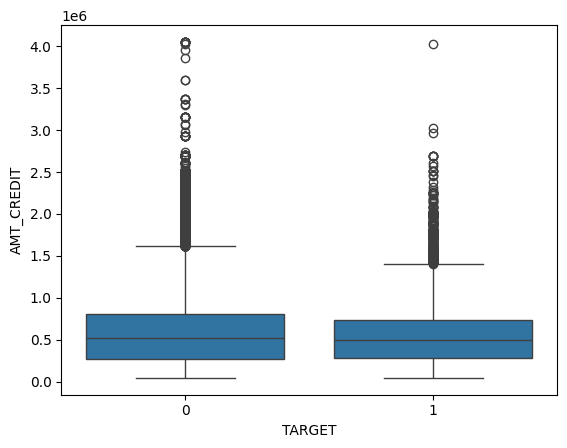

In [190]:
sns.boxplot(x = "TARGET", y = "AMT_CREDIT", data = train);

In AMT_CREDIT, churn and non-churn distributions are similar, making it a weak predictor.

**AMT_ANNUITY vs TARGET**

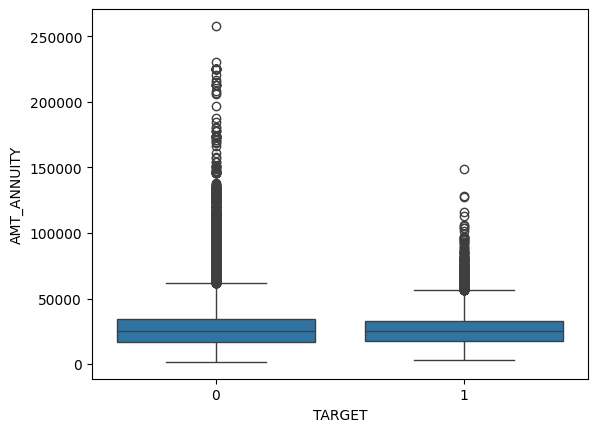

In [191]:
sns.boxplot(x = "TARGET", y = "AMT_ANNUITY", data = train);

In AMT_ANNUITY, applicants with lower annuity values tend to churn more, suggesting moderate predictive power.

**AMT_GOODS_PRICE vs TARGET**

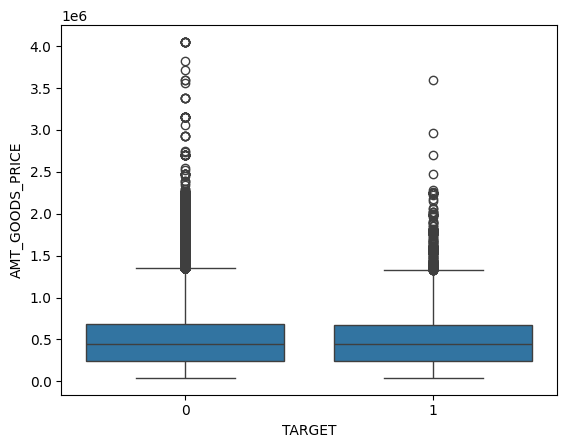

In [192]:
sns.boxplot(x = "TARGET", y = "AMT_GOODS_PRICE", data = train);

In AMT_GOODS_PRICE, the distributions are also similar, suggesting weak predictive power.

**AGE_YEARS vs TARGET**

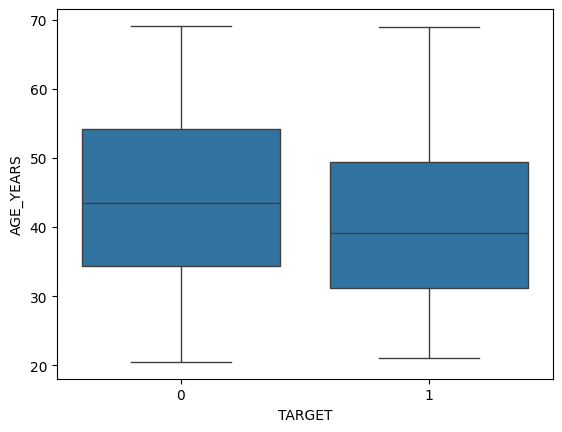

In [193]:
sns.boxplot(x = "TARGET", y = "AGE_YEARS", data = train);

In AGE_YEARS, younger applicants show higher churn, indicating a moderate predictor.

# Dropping Unused Column

This column is not important for building machine learning models, as it is merely an identifier.

In [194]:
# train = train.drop(columns=['SK_ID_CURR'])
# test = test.drop(columns=['SK_ID_CURR'])

# Replacing Some Values

Since there are only 4 “Unknown” out of more than 350,000 records, replacing XNA with the most frequent category avoids creating an almost-empty category that adds no real predictive power.

**CODE_GENDER**

In [195]:
train["CODE_GENDER"].value_counts().sort_index()

CODE_GENDER
F      202442
M      105053
XNA         4
Name: count, dtype: int64

In [196]:
most_freq = train['CODE_GENDER'].mode()[0]
print(f'Most Freq. Code Gender: {most_freq}')

Most Freq. Code Gender: F


In [197]:
# train n test

train['CODE_GENDER'] = train['CODE_GENDER'].replace('XNA', most_freq)
test['CODE_GENDER'] = test['CODE_GENDER'].replace('XNA', most_freq)

In [198]:
train["CODE_GENDER"].value_counts().sort_index()

CODE_GENDER
F    202446
M    105053
Name: count, dtype: int64

In [199]:
test["CODE_GENDER"].value_counts().sort_index()

CODE_GENDER
F    32676
M    16064
Name: count, dtype: int64

**ORGANIZATION_TYPE**

In [200]:
train["ORGANIZATION_TYPE"].value_counts().sort_index()

ORGANIZATION_TYPE
Advertising                 429
Agriculture                2454
Bank                       2507
Business Entity Type 1     5984
Business Entity Type 2    10553
Business Entity Type 3    67991
Cleaning                    260
Construction               6721
Culture                     379
Electricity                 950
Emergency                   560
Government                10403
Hotel                       966
Housing                    2958
Industry: type 1           1039
Industry: type 10           109
Industry: type 11          2704
Industry: type 12           369
Industry: type 13            67
Industry: type 2            458
Industry: type 3           3278
Industry: type 4            876
Industry: type 5            599
Industry: type 6            112
Industry: type 7           1307
Industry: type 8             24
Industry: type 9           3368
Insurance                   597
Kindergarten               6880
Legal Services              305
Medicine              

In [201]:
# train, test, df

train['ORGANIZATION_TYPE'] = train['ORGANIZATION_TYPE'].replace('XNA', 'Unknown')
test['ORGANIZATION_TYPE'] = test['ORGANIZATION_TYPE'].replace('XNA', 'Unknown')
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace('XNA', 'Unknown')

In [202]:
df["ORGANIZATION_TYPE"].value_counts().sort_index()

ORGANIZATION_TYPE
Advertising                 500
Agriculture                2746
Bank                       2881
Business Entity Type 1     6871
Business Entity Type 2    12032
Business Entity Type 3    78832
Cleaning                    303
Construction               7760
Culture                     440
Electricity                1106
Emergency                   651
Government                11912
Hotel                      1100
Housing                    3393
Industry: type 1           1217
Industry: type 10           133
Industry: type 11          3120
Industry: type 12           446
Industry: type 13            73
Industry: type 2            535
Industry: type 3           3767
Industry: type 4           1044
Industry: type 5            696
Industry: type 6            139
Industry: type 7           1524
Industry: type 8             27
Industry: type 9           3867
Insurance                   677
Kindergarten               7918
Legal Services              358
Medicine              

# Feature Encoding

In [203]:
train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 307499 entries, 0 to 307510
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   SK_ID_CURR                  307499 non-null  object
 1   TARGET                      307499 non-null  object
 2   NAME_CONTRACT_TYPE          307499 non-null  object
 3   CODE_GENDER                 307499 non-null  object
 4   FLAG_OWN_CAR                307499 non-null  object
 5   FLAG_OWN_REALTY             307499 non-null  object
 6   NAME_TYPE_SUITE             307499 non-null  object
 7   NAME_INCOME_TYPE            307499 non-null  object
 8   NAME_EDUCATION_TYPE         307499 non-null  object
 9   NAME_FAMILY_STATUS          307499 non-null  object
 10  NAME_HOUSING_TYPE           307499 non-null  object
 11  OCCUPATION_TYPE             307499 non-null  object
 12  WEEKDAY_APPR_PROCESS_START  307499 non-null  object
 13  ORGANIZATION_TYPE           307499

## Binary Encoding

**2 Unique Values**

In [204]:
contract_type_map = {'Cash loans': 0, 'Revolving loans': 1}

In [205]:
train['NAME_CONTRACT_TYPE'] = train['NAME_CONTRACT_TYPE'].map(contract_type_map)
test['NAME_CONTRACT_TYPE'] = test['NAME_CONTRACT_TYPE'].map(contract_type_map)

In [206]:
train['CODE_GENDER'] = train['CODE_GENDER'].apply(lambda x: 1 if x == 'F' else 0)
test['CODE_GENDER'] = test['CODE_GENDER'].apply(lambda x: 1 if x == 'F' else 0)

In [207]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})

In [208]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

**3 Unique Values**

In [209]:
# Binary encode "Yes" and keep "Missing" as a separate flag
train['EMERGENCY_YES'] = (train['EMERGENCYSTATE_MODE'] == 'Yes').astype(int)
train['EMERGENCY_MISSING'] = (train['EMERGENCYSTATE_MODE'] == 'Missing').astype(int)
train.drop('EMERGENCYSTATE_MODE', axis=1, inplace=True)

In [210]:
test['EMERGENCY_YES'] = (test['EMERGENCYSTATE_MODE'] == 'Yes').astype(int)
test['EMERGENCY_MISSING'] = (test['EMERGENCYSTATE_MODE'] == 'Missing').astype(int)
test.drop('EMERGENCYSTATE_MODE', axis=1, inplace=True)

## Ordinal Encoding

In [211]:
education_order = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

In [212]:
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].map(education_order)
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].map(education_order)

## Cyclical Encoding

In [213]:
weekday_map = {
    'MONDAY': 0,
    'TUESDAY': 1,
    'WEDNESDAY': 2,
    'THURSDAY': 3,
    'FRIDAY': 4,
    'SATURDAY': 5,
    'SUNDAY': 6
}

In [214]:
for xf in [train, test]:
    xf['WEEKDAY_APPR_PROCESS_START'] = xf['WEEKDAY_APPR_PROCESS_START'].map(weekday_map)
    xf['WEEKDAY_SIN'] = np.sin(2 * np.pi * xf['WEEKDAY_APPR_PROCESS_START'] / 7)
    xf['WEEKDAY_COS'] = np.cos(2 * np.pi * xf['WEEKDAY_APPR_PROCESS_START'] / 7)
    xf.drop('WEEKDAY_APPR_PROCESS_START', axis=1, inplace=True)

## One-Hot Encoding (Dummy Encoding Version)

In [215]:
categorical_columns = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                       'FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMPLOYMENT_STATUS']

In [216]:
# Reset index to avoid index misalignment during concat/split
train_reset = train.reset_index(drop=True)
test_reset = test.reset_index(drop=True)

# Combine, encode, and split back
combined = pd.concat([train_reset, test_reset], axis=0)
combined = pd.get_dummies(combined, columns=categorical_columns, dtype=int, drop_first=True)

# Split back while preserving row order
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].copy()

## Frequency Encoding (High Cardinality)

In [217]:
occupation_freq = train['OCCUPATION_TYPE'].value_counts(normalize=True)

In [218]:
for xf in [train, test]:
    xf['OCCUPATION_TYPE'] = xf['OCCUPATION_TYPE'].map(occupation_freq)

## Target Encoding (Very High Cardinality)

In [219]:
# from train
org_means = train.groupby('ORGANIZATION_TYPE')['TARGET'].mean()

In [220]:
for xf in [train, test]:
    xf['ORGANIZATION_TYPE_ENCODED'] = xf['ORGANIZATION_TYPE'].map(org_means)
    xf.drop('ORGANIZATION_TYPE', axis=1, inplace=True)

In [221]:
org_means.to_json("../dataset/org_means.json", orient="index", indent=4)

In [222]:
train['ORGANIZATION_TYPE_ENCODED'].isna().sum()

0

In [223]:
train['ORGANIZATION_TYPE_ENCODED'] = train['ORGANIZATION_TYPE_ENCODED'].astype(float)
test['ORGANIZATION_TYPE_ENCODED'] = test['ORGANIZATION_TYPE_ENCODED'].astype(float)

In [224]:
train['ORGANIZATION_TYPE_ENCODED']

0        0.093
1        0.059
2        0.070
3        0.093
4        0.059
          ... 
307494   0.066
307495   0.054
307496   0.059
307497   0.081
307498   0.093
Name: ORGANIZATION_TYPE_ENCODED, Length: 307499, dtype: float64

---

In [225]:
train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 307499 entries, 0 to 307498
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SK_ID_CURR  307499 non-null  object
 1   TARGET      307499 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


In [226]:
test.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 48740 entries, 0 to 48739
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SK_ID_CURR  48740 non-null  object
 1   TARGET      0 non-null      object
dtypes: object(2)
memory usage: 1.1+ MB


In [227]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307499 entries, 0 to 307498
Data columns (total 177 columns):
 #    Column                                    Non-Null Count   Dtype  
---   ------                                    --------------   -----  
 0    SK_ID_CURR                                307499 non-null  object 
 1    TARGET                                    307499 non-null  object 
 2    NAME_CONTRACT_TYPE                        307499 non-null  int64  
 3    CODE_GENDER                               307499 non-null  int64  
 4    FLAG_OWN_CAR                              307499 non-null  int64  
 5    FLAG_OWN_REALTY                           307499 non-null  int64  
 6    CNT_CHILDREN                              307499 non-null  int64  
 7    AMT_INCOME_TOTAL                          307499 non-null  float64
 8    AMT_CREDIT                                307499 non-null  float64
 9    AMT_ANNUITY                               307499 non-null  float64
 10   AMT_GOODS_P

In [228]:
test.shape

(48740, 177)

# Multicollinearity Check

## Correlation Matrix

I group the correlation strength into the following categories:
- Strong: Correlation strength ≥ 0.8 or ≤ -0.8
- Moderate: 0.3 < correlation strength < 0.8 or -0.8 < correlation strength < -0.3
- Weak: Correlation strength ≤ 0.3 and ≥ -0.3

In [229]:
def num_corr(df, corr_name='Correlation Matrix'):
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6))
    correlation = df.corr(numeric_only=True)
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', annot_kws={"size": 11})
    sns.despine(left=True, bottom=True)
    plt.grid(False)
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.title(f"{corr_name}", fontsize=16, fontweight='bold')

In [230]:
train[['AMT_CREDIT', 'AMT_GOODS_PRICE']].sample(10)

AMT_CREDIT  AMT_GOODS_PRICE
297280  675000.000       675000.000
194736  810000.000       810000.000
271816  411813.000       355500.000
38584   381528.000       315000.000
221008  180000.000       180000.000
262147 1928304.000      1800000.000
78977   749349.000       625500.000
122499  748467.000       706500.000
211389  755190.000       675000.000
234361  180000.000       180000.000

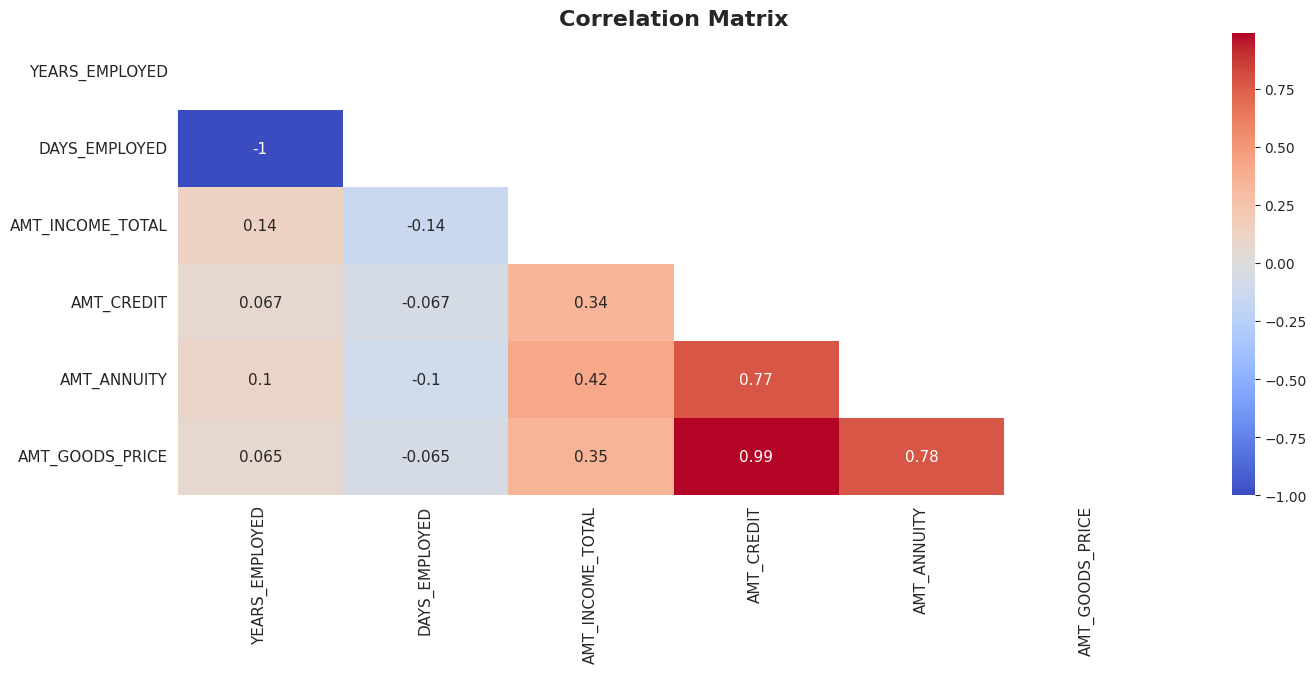

In [231]:
num_corr(train[['YEARS_EMPLOYED', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']])

In [232]:
def get_strong_correlations(df, threshold=0.8):

    # Select only numeric columns
    df_numeric = df.select_dtypes(include=['number'])
    
    # Calculate correlation matrix
    corr_matrix = df_numeric.corr()
    
    # Get upper triangle of correlation matrix without diagonal (to avoid self/redundant pairs)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Unstack and sort by absolute correlation
    corr_pairs = upper_triangle.unstack().dropna().sort_values(key=abs, ascending=False)
    
    # Filter by threshold
    strong_corrs = corr_pairs[(corr_pairs >= threshold) | (corr_pairs <= -threshold)]
    
    # Convert to DataFrame for better presentation
    result_df = pd.DataFrame(strong_corrs).reset_index()
    result_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # Sort by absolute correlation value
    result_df['Abs_Correlation'] = result_df['Correlation'].abs()
    result_df = result_df.sort_values('Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)
    
    return result_df

In [233]:
pd.set_option("display.max_rows", None)

In [234]:
get_strong_correlations(train)

Feature 1                      Feature 2  Correlation
0                        AGE_YEARS                     DAYS_BIRTH       -1.000
1     EMPLOYMENT_STATUS_Unemployed                FLAG_UNEMPLOYED        1.000
2                   YEARS_EMPLOYED                  DAYS_EMPLOYED       -1.000
3                 YEARS_BUILD_MEDI                YEARS_BUILD_AVG        1.000
4         NONLIVINGAPARTMENTS_MEDI        NONLIVINGAPARTMENTS_AVG        1.000
5                  COMMONAREA_MEDI                 COMMONAREA_AVG        1.000
6     YEARS_BEGINEXPLUATATION_MEDI    YEARS_BEGINEXPLUATATION_AVG        1.000
7                   ENTRANCES_MEDI                  ENTRANCES_AVG        1.000
8                BASEMENTAREA_MEDI               BASEMENTAREA_AVG        1.000
9         NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_MODE        1.000
10           LIVINGAPARTMENTS_MEDI           LIVINGAPARTMENTS_AVG        1.000
11              NONLIVINGAREA_MEDI              NONLIVINGAREA_AVG        1.000
12                   LANDAREA_MEDI                   LANDAREA_AVG        1.000
13        NONLIVINGAPARTMENTS_MODE        NONLIVINGAPARTMENTS_AVG        1.000
14                  FLOORSMIN_MEDI                  FLOORSMIN_AVG        1.000
15                 LIVINGAREA_MEDI                 LIVINGAREA_AVG        1.000
16                 APARTMENTS_MEDI                 APARTMENTS_AVG        1.000
17                  FLOORSMAX_MEDI                  FLOORSMAX_AVG        1.000
18                  ELEVATORS_MEDI                  ELEVATORS_AVG        1.000
19                 COMMONAREA_MEDI                COMMONAREA_MODE        1.000
20                 COMMONAREA_MODE                 COMMONAREA_AVG        1.000
21                YEARS_BUILD_MEDI               YEARS_BUILD_MODE        1.000
22                YEARS_BUILD_MODE                YEARS_BUILD_AVG        1.000
23              NONLIVINGAREA_MEDI             NONLIVINGAREA_MODE        1.000
24                   LANDAREA_MEDI                  LANDAREA_MODE        1.000
25    YEARS_BEGINEXPLUATATION_MODE    YEARS_BEGINEXPLUATATION_AVG        1.000
26               BASEMENTAREA_MEDI              BASEMENTAREA_MODE        1.000
27                   LANDAREA_MODE                   LANDAREA_AVG        1.000
28              NONLIVINGAREA_MODE              NONLIVINGAREA_AVG        1.000
29    YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_MODE        1.000
30               BASEMENTAREA_MODE               BASEMENTAREA_AVG        1.000
31           LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_MODE        1.000
32                  ENTRANCES_MEDI                 ENTRANCES_MODE        1.000
33           LIVINGAPARTMENTS_MODE           LIVINGAPARTMENTS_AVG        1.000
34                  FLOORSMIN_MEDI                 FLOORSMIN_MODE        1.000
35                  ENTRANCES_MODE                  ENTRANCES_AVG        1.000
36                  FLOORSMAX_MEDI                 FLOORSMAX_MODE        1.000
37                 APARTMENTS_MEDI                APARTMENTS_MODE        1.000
38                  FLOORSMIN_MODE                  FLOORSMIN_AVG        1.000
39                  ELEVATORS_MEDI                 ELEVATORS_MODE        1.000
40                  FLOORSMAX_MODE                  FLOORSMAX_AVG        1.000
41                 APARTMENTS_MODE                 APARTMENTS_AVG        1.000
42                 LIVINGAREA_MEDI                LIVINGAREA_MODE        1.000
43                 LIVINGAREA_MODE                 LIVINGAREA_AVG        1.000
44                  ELEVATORS_MODE                  ELEVATORS_AVG        1.000
45                     FLAG_NO_CAR                   FLAG_OWN_CAR       -1.000
47                 FLAG_UNEMPLOYED                  DAYS_EMPLOYED        1.000
46    EMPLOYMENT_STATUS_Unemployed                  DAYS_EMPLOYED        1.000
48    EMPLOYMENT_STATUS_Unemployed                 YEARS_EMPLOYED       -1.000
49                  YEARS_EMPLOYED                FLAG_UNEMPLOYED       -1.

In [235]:
col_to_drop = ['YEARS_EMPLOYED','AGE_YEARS','YEARS_BUILD_AVG','NONLIVINGAPARTMENTS_AVG','COMMONAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','ENTRANCES_AVG',
               'BASEMENTAREA_AVG','NONLIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_AVG']

In [236]:
col_to_drop.extend(['NONLIVINGAREA_AVG','LANDAREA_AVG','FLOORSMIN_AVG','LIVINGAREA_AVG','APARTMENTS_AVG','FLOORSMAX_AVG',
               'ELEVATORS_AVG','COMMONAREA_MODE','YEARS_BUILD_MODE','NONLIVINGAREA_MODE','LANDAREA_MODE','BASEMENTAREA_MODE'])

In [237]:
col_to_drop.extend(['YEARS_BEGINEXPLUATATION_MODE','LIVINGAPARTMENTS_MODE','ENTRANCES_MODE','FLOORSMIN_MODE','FLOORSMAX_MODE','APARTMENTS_MODE',
               'ELEVATORS_MODE','LIVINGAREA_MODE'])

In [238]:
col_to_drop.extend(['OBS_60_CNT_SOCIAL_CIRCLE','YEARS_BEGINEXPLUATATION_MEDI','AMT_GOODS_PRICE','GTI_RATIO','FLOORSMAX_MEDI', 'ENTRANCES_MEDI', 'REGION_RATING_CLIENT'])

In [239]:
col_to_drop.extend(['FLOORSMIN_MEDI','ELEVATORS_MEDI','COMMONAREA_MEDI','NONLIVINGAREA_MEDI','DEF_60_CNT_SOCIAL_CIRCLE','BASEMENTAREA_MEDI'])

In [240]:
col_to_drop.extend(['NONLIVINGAPARTMENTS_MEDI','TOTALAREA_MODE','YEARS_BUILD_MEDI','LANDAREA_MEDI'])

In [241]:
col_to_drop.extend(['APARTMENTS_MEDI','CNT_CHILDREN'])

In [242]:
col_to_drop.extend(['EMPLOYMENT_STATUS_Unknown','FLAG_NO_CAR','NAME_INCOME_TYPE_Pensioner','FLAG_EMP_PHONE','WALLSMATERIAL_MODE_Missing',
                    'EMERGENCY_MISSING','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY'])

In [243]:
col_to_drop.extend(['HOUSETYPE_MODE_block of flats', 'FLAG_BUILDING_INFO_MISSING', 'NAME_TYPE_SUITE_Family'])

In [244]:
col_to_drop.extend(['EMPLOYMENT_STATUS_Unemployed', 'FLAG_UNEMPLOYED'])

In [245]:
train = train.drop(col_to_drop, axis=1)
test = test.drop(col_to_drop, axis=1)

**Now there are no correlations greater than 0.8**

In [246]:
get_strong_correlations(train)

Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []

Keep only one from each pair (typically keep the more intuitive version)
- For age-related features, **DAYS_BIRTH** and **DAYS_EMPLOYED** are commonly used in credit scoring
- Person A: 12,000 days old (32.87 years)
- Person B: 12,400 days old (33.97 years)
- The model can see this 400-day difference if we use days, but would see both as "33" if we use years **(AGE_YEARS)**
- Model Performance: In Home Credit's own benchmarks, days consistently outperform years
- Industry Standard: FICO and other scoring systems use days for finer gradations

In [247]:
# Correlation greater than 0.7
get_strong_correlations(train, threshold=0.7)

Feature 1                   Feature 2  \
0            FLAG_EXT_SOURCE_3_MISSING  FLAG_CREDIT_BUREAU_MISSING   
1                            ATI_RATIO                   CTI_RATIO   
2                          AMT_ANNUITY                  AMT_CREDIT   
3  FONDKAPREMONT_MODE_reg oper account       LIVINGAPARTMENTS_MEDI   

   Correlation  
0        0.794  
1        0.788  
2        0.770  
3        0.759

## VIF

I group the strength of VIF into the following categories:
- No multicollinearity: VIF = 1
- Moderate multicollinearity: 5 ≤ VIF ≤ 10
- Severe multicollinearity: VIF > 10

In [248]:
train.isna().sum()[train.isna().sum() > 0]

Series([], dtype: int64)

Calculate the VIF only for variables with a correlation strength greater than 0.3

The difference in VIF scores between correlation thresholds of 0.2 and 0.3 is small, so I choose 0.3 for better speed.

In [249]:
def calculate_vif(data, target_col='TARGET', corr_threshold=0.3):

    # Drop the target column and keep only numeric features
    X = data.drop(columns=target_col, errors='ignore')
    X = X.select_dtypes(include='number')
    
    # Correlation matrix and selecting highly correlated features
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [col for col in upper_tri.columns if any(upper_tri[col] > corr_threshold)]
    
    # Subset and clean the data
    X_vif = X[high_corr_features]

    # Handle infs and NaNs
    # Temporary imputation for missing values (just for VIF)
    X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(X_vif.median(numeric_only=True))
    
    # Add constant for VIF computation
    X_vif = add_constant(X_vif)
    
    # Compute VIF
    vif_df = pd.DataFrame({
        "feature": X_vif.columns,
        "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    })
    
    # Drop the constant and sort by VIF
    vif_df = vif_df[vif_df.feature != 'const'].sort_values(by='VIF', ascending=False).reset_index(drop=True)
    
    return vif_df

In [250]:
%%time
vif_results = calculate_vif(train, target_col='TARGET')

CPU times: user 2min 39s, sys: 1min 6s, total: 3min 46s
Wall time: 1min 25s


In [251]:
vif_results

feature    VIF
0                                 CTI_RATIO 12.494
1                                AMT_CREDIT 11.570
2                                 ATI_RATIO  9.382
3                               AMT_ANNUITY  8.082
4                             DAYS_EMPLOYED  3.674
5                           LIVINGAREA_MEDI  3.410
6                NAME_FAMILY_STATUS_Married  2.808
7                 FLAG_EXT_SOURCE_3_MISSING  2.726
8                FLAG_CREDIT_BUREAU_MISSING  2.718
9                  WALLSMATERIAL_MODE_Panel  2.585
10          WALLSMATERIAL_MODE_Stone, brick  2.525
11                          FLAG_DOCUMENT_3  2.383
12                          FLAG_DOCUMENT_6  2.295
13  NAME_FAMILY_STATUS_Single / not married  2.176
14               EMPLOYMENT_STATUS_Mid_Term  2.146
15                             FLAG_OWN_CAR  1.928
16             EMPLOYMENT_STATUS_Short_Term  1.887
17                ORGANIZATION_TYPE_ENCODED  1.778
18                              OWN_CAR_AGE  1.755
19                          FLAG_DOCUMENT_8  1.738
20                          OCCUPATION_TYPE  1.652
21             NAME_FAMILY_STATUS_Separated  1.569
22                 NAME_FAMILY_STATUS_Widow  1.551
23      FONDKAPREMONT_MODE_reg oper account  1.482
24                 NAME_INCOME_TYPE_Working  1.375
25                            HIGH_ATI_RISK  1.240
26                       GOODS_CREDIT_RATIO  1.133
27              REGION_RATING_CLIENT_W_CITY  1.113
28                             EXT_SOURCE_1  1.095
29                        DAYS_REGISTRATION  1.094
30                   REG_CITY_NOT_LIVE_CITY  1.090
31           NAME_HOUSING_TYPE_With parents  1.051
32       NAME_HOUSING_TYPE_Rented apartment  1.040
33                            HIGH_GTI_RISK  1.034
34    NAME_HOUSING_TYPE_Municipal apartment  1.019
35            NAME_TYPE_SUITE_Unaccompanied  1.015
36                 DEF_30_CNT_SOCIAL_CIRCLE  1.003

In [252]:
col_to_drop = ['CTI_RATIO']

train = train.drop(col_to_drop, axis=1)
test = test.drop(col_to_drop, axis=1)

In [253]:
vif_results = calculate_vif(train, target_col='TARGET')

In [254]:
vif_results

feature   VIF
0                             DAYS_EMPLOYED 3.674
1                           LIVINGAREA_MEDI 3.410
2                               AMT_ANNUITY 3.054
3                NAME_FAMILY_STATUS_Married 2.808
4                 FLAG_EXT_SOURCE_3_MISSING 2.726
5                FLAG_CREDIT_BUREAU_MISSING 2.718
6                  WALLSMATERIAL_MODE_Panel 2.585
7                                AMT_CREDIT 2.537
8           WALLSMATERIAL_MODE_Stone, brick 2.525
9                           FLAG_DOCUMENT_3 2.376
10                          FLAG_DOCUMENT_6 2.294
11  NAME_FAMILY_STATUS_Single / not married 2.176
12               EMPLOYMENT_STATUS_Mid_Term 2.146
13                             FLAG_OWN_CAR 1.928
14             EMPLOYMENT_STATUS_Short_Term 1.887
15                                ATI_RATIO 1.813
16                ORGANIZATION_TYPE_ENCODED 1.778
17                              OWN_CAR_AGE 1.755
18                          FLAG_DOCUMENT_8 1.735
19                          OCCUPATION_TYPE 1.652
20             NAME_FAMILY_STATUS_Separated 1.569
21                 NAME_FAMILY_STATUS_Widow 1.551
22      FONDKAPREMONT_MODE_reg oper account 1.482
23                 NAME_INCOME_TYPE_Working 1.375
24                            HIGH_ATI_RISK 1.240
25                       GOODS_CREDIT_RATIO 1.131
26              REGION_RATING_CLIENT_W_CITY 1.113
27                             EXT_SOURCE_1 1.095
28                        DAYS_REGISTRATION 1.094
29                   REG_CITY_NOT_LIVE_CITY 1.090
30           NAME_HOUSING_TYPE_With parents 1.051
31       NAME_HOUSING_TYPE_Rented apartment 1.040
32                            HIGH_GTI_RISK 1.020
33    NAME_HOUSING_TYPE_Municipal apartment 1.019
34            NAME_TYPE_SUITE_Unaccompanied 1.015
35                 DEF_30_CNT_SOCIAL_CIRCLE 1.003

The VIF values are all below 0.4, so multicollinearity is not a problem.

# Data Preprocessing III

## Handling Missing Values

In [255]:
train.shape, test.shape, df.shape

((307499, 114), (48740, 114), (356255, 143))

In [256]:
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

In [257]:
test.isnull().sum()[test.isnull().sum() > 0]

TARGET    48740
dtype: int64

In [258]:
df.isnull().sum()[df.isnull().sum() > 0]

TARGET                       48744
AMT_ANNUITY                     36
AMT_GOODS_PRICE                278
NAME_TYPE_SUITE               2203
CNT_FAM_MEMBERS                  2
EXT_SOURCE_1                193910
EXT_SOURCE_2                   668
EXT_SOURCE_3                 69633
OBS_30_CNT_SOCIAL_CIRCLE      1050
DEF_30_CNT_SOCIAL_CIRCLE      1050
OBS_60_CNT_SOCIAL_CIRCLE      1050
DEF_60_CNT_SOCIAL_CIRCLE      1050
DAYS_LAST_PHONE_CHANGE           1
GOODS_CREDIT_RATIO             278
ATI_RATIO                       36
GTI_RATIO                      278
dtype: int64

---

In [259]:
train.isnull().sum().sum()

0

In [260]:
test.isnull().sum().sum()

48740

In [261]:
df.isnull().sum().sum()

320267

# Feature Scaling

I'll try this in the ML notebook

# Save the PARQUET Files to HDFS (Machine Learning Dataset)

In [262]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307499 entries, 0 to 307498
Data columns (total 114 columns):
 #    Column                                    Non-Null Count   Dtype  
---   ------                                    --------------   -----  
 0    SK_ID_CURR                                307499 non-null  object 
 1    TARGET                                    307499 non-null  object 
 2    NAME_CONTRACT_TYPE                        307499 non-null  int64  
 3    CODE_GENDER                               307499 non-null  int64  
 4    FLAG_OWN_CAR                              307499 non-null  int64  
 5    FLAG_OWN_REALTY                           307499 non-null  int64  
 6    AMT_INCOME_TOTAL                          307499 non-null  float64
 7    AMT_CREDIT                                307499 non-null  float64
 8    AMT_ANNUITY                               307499 non-null  float64
 9    NAME_EDUCATION_TYPE                       307499 non-null  int64  
 10   REGION_POPU

In [263]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48740 entries, 0 to 48739
Data columns (total 114 columns):
 #    Column                                    Non-Null Count  Dtype  
---   ------                                    --------------  -----  
 0    SK_ID_CURR                                48740 non-null  object 
 1    TARGET                                    0 non-null      object 
 2    NAME_CONTRACT_TYPE                        48740 non-null  int64  
 3    CODE_GENDER                               48740 non-null  int64  
 4    FLAG_OWN_CAR                              48740 non-null  int64  
 5    FLAG_OWN_REALTY                           48740 non-null  int64  
 6    AMT_INCOME_TOTAL                          48740 non-null  float64
 7    AMT_CREDIT                                48740 non-null  float64
 8    AMT_ANNUITY                               48740 non-null  float64
 9    NAME_EDUCATION_TYPE                       48740 non-null  int64  
 10   REGION_POPULATION_RELATIV

In [264]:
train.shape, test.shape

((307499, 114), (48740, 114))

In [265]:
# Ubuntu
local_path = '../tmp_dataset/'

train.to_csv(local_path + 'train.csv', index=False)
test.to_csv(local_path + 'test.csv', index=False)

train.to_parquet(local_path + 'train.parquet', index=False)
test.to_parquet(local_path + 'test.parquet', index=False)

**Disable the Safe Mode**

In [266]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


**Make Directory in hdfs**

In [267]:
!hdfs dfs -mkdir -p /user/jihadakbr/credit_risk/ml_data

**Move or Put the PARQUET Files from Local to HDFS**

In [268]:
!hdfs dfs -put -f /home/jihadakbr/Project/Home_Credit_Default_Risk/tmp_dataset/train.parquet /user/jihadakbr/credit_risk/ml_data/train.parquet

In [269]:
!hdfs dfs -put -f /home/jihadakbr/Project/Home_Credit_Default_Risk/tmp_dataset/test.parquet /user/jihadakbr/credit_risk/ml_data/test.parquet

**My file inside HDFS system (virtual file system)**

In [270]:
!hdfs dfs -ls /user/jihadakbr/credit_risk/ml_data

Found 2 items
-rw-r--r--   1 jihadakbr supergroup    3102285 2025-09-05 22:00 /user/jihadakbr/credit_risk/ml_data/test.parquet
-rw-r--r--   1 jihadakbr supergroup   15756340 2025-09-05 22:00 /user/jihadakbr/credit_risk/ml_data/train.parquet


# Save the Clean Data to PostgreSQL

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 143 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    356255 non-null  object 
 1    TARGET                        307511 non-null  object 
 2    NAME_CONTRACT_TYPE            356255 non-null  object 
 3    CODE_GENDER                   356255 non-null  object 
 4    FLAG_OWN_CAR                  356255 non-null  object 
 5    FLAG_OWN_REALTY               356255 non-null  object 
 6    CNT_CHILDREN                  356255 non-null  int64  
 7    AMT_INCOME_TOTAL              356255 non-null  float64
 8    AMT_CREDIT                    356255 non-null  float64
 9    AMT_ANNUITY                   356219 non-null  float64
 10   AMT_GOODS_PRICE               355977 non-null  float64
 11   NAME_TYPE_SUITE               354052 non-null  object 
 12   NAME_INCOME_TYPE            

In [272]:
df.shape

(356255, 143)

In [273]:
# import pandas as pd

# train = [{'x': 2, 'y': 3}]
# test = [{'x': 2}]

# train = pd.DataFrame(train)
# test = pd.DataFrame(test)


In [274]:
# Go one directory up
env_path = Path.cwd().parent / ".env"
# print(f"env_path: {env_path}")

In [275]:
# Load environment variables (credentials) from the .env file
load_dotenv(dotenv_path=env_path, override=True)

True

In [276]:
# Connection configuration for creating a new database
admin_dbname = os.getenv('DB_ADMIN_NAME')  # PostgreSQL template database
user = os.getenv('DB_USER')                # PostgreSQL username
password = os.getenv('DB_PASSWORD')        # PostgreSQL password
host = os.getenv('DB_HOST')                # Host
port = os.getenv('DB_PORT')                # Default PostgreSQL port

In [277]:
# Use 'with' statement to ensure the connection is always closed
try:
    with connect(
        dbname=admin_dbname,
        user=user,
        password=password,
        host=host,
        port=port
    ) as conn_admin:
        print("Connection successful")
except Exception as e:
    print(f"Failed to connect to database: {e}")

Connection successful


In [278]:
# Create a cursor to execute SQL commands
conn_admin.autocommit = True  # Needed to execute CREATE DATABASE
cur = conn_admin.cursor()     # Create cursor from connection

# Name of the new database
new_dbname = 'credit_risk'

# Create the new database if it doesn't already exist
try:
    cur.execute(f"CREATE DATABASE {new_dbname}")
    print(f"Database '{new_dbname}' created successfully!")
except psycopg2.errors.DuplicateDatabase:
    print(f"Database '{new_dbname}' already exists.")

# Close the admin connection
cur.close()
conn_admin.close()

Database 'credit_risk' already exists.


In [279]:
try:
    # Open a connection to the new database
    conn = connect(
        dbname=new_dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    print(f"Connected successfully to database {new_dbname}")
except psycopg2.OperationalError as e:
    print(f"Failed to connect to database: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Connected successfully to database credit_risk


In [280]:
# Create a SQLAlchemy engine for connecting to PostgreSQL
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{new_dbname}')

In [281]:
%%time
# Save DataFrame to PostgreSQL using pandas.to_sql()
# 10-15 mins to run
df.to_sql('clean_data', engine, if_exists='replace', index=False)

print("Data successfully inserted into PostgreSQL!")

Data successfully inserted into PostgreSQL!
CPU times: user 5min 38s, sys: 1min 25s, total: 7min 3s
Wall time: 13min 3s


In [282]:
# Close the database connection
conn.close()